In [45]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic' # 폰트 변경
plt.rcParams['axes.unicode_minus'] = False # 축 값 마이너스 깨짐 해결
import numpy as np
from torch.nn import Transformer
from torch import nn
import torch
import math
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_percentage_error ,mean_squared_error

In [46]:
#path = '~/workplace/datas/energy/'
path = '~/Desktop/workplace/datas/energy/'

In [47]:
train_df = pd.read_csv(path + 'encoded_train_df.csv', index_col=0)
test_df = pd.read_csv(path + 'encoded_test_df.csv', index_col=0)

In [48]:
X = train_df.iloc[:, :-1]
X.drop(['5분전_현재수요(MW)', '1시간전_현재수요(MW)'], axis=1, inplace=True)
y = train_df.iloc[:, -1]

In [49]:
X_test = test_df.iloc[:, :-1]
X_test.drop(['5분전_현재수요(MW)', '1시간전_현재수요(MW)'], axis=1, inplace=True)
y_test = test_df.iloc[:, -1]

In [50]:
X.shape, y.shape, X_test.shape, y_test.shape

((546035, 17), (546035,), (2016, 17), (2016,))

# mRMR

In [51]:
#mRMR
from mrmr import mrmr_classif, mrmr_regression
selected_features = mrmr_regression(X=X, y=y, K=20, return_scores=True)

100%|███████████████████████████████████████████| 17/17 [00:19<00:00,  1.16s/it]


In [52]:
selected_features

(['하루전_현재수요(MW)',
  'Hour',
  '휴일',
  '적설(cm)',
  'smp(원/kWh)',
  '풍속(m/s)',
  '습도(%)',
  '일조(hr)',
  '발전량',
  '현지기압(hPa)',
  'Year',
  'Month',
  '일사(MJ/m2)',
  '기온(°C)',
  'Day',
  '지면온도(°C)',
  '강수량(mm)'],
 Year              2860.884629
 Month             1682.232189
 Day                151.384261
 Hour             66369.451132
 기온(°C)            4006.375704
 풍속(m/s)          22691.984785
 습도(%)            25356.101253
 현지기압(hPa)         3340.531774
 지면온도(°C)           871.292241
 강수량(mm)             44.465668
 적설(cm)           42858.655050
 일조(hr)           12527.003168
 일사(MJ/m2)         6372.065627
 smp(원/kWh)       43467.539457
 발전량               8353.840599
 휴일               27191.463755
 하루전_현재수요(MW)    783073.146561
 dtype: float64,
                   Year     Month       Day      Hour    기온(°C)   풍속(m/s)  \
 Year          0.001000  0.001000  0.001000  0.001000  0.001000  0.020105   
 Month         0.099795  0.001000  0.001000  0.001000  0.001000  0.139199   
 Day           0

In [53]:
mrmr = []

for i , j in enumerate(selected_features[0]):
    mrmr.append([(i+1),j])

In [54]:
mrmr = pd.DataFrame(mrmr, columns=['rank', 'features'])

In [55]:
mrmr

,rank,features
0,1,하루전_현재수요(MW)
1,2,Hour
2,3,휴일
3,4,적설(cm)
4,5,smp(원/kWh)
5,6,풍속(m/s)
6,7,습도(%)
7,8,일조(hr)
8,9,발전량
9,10,현지기압(hPa)


# SAHP

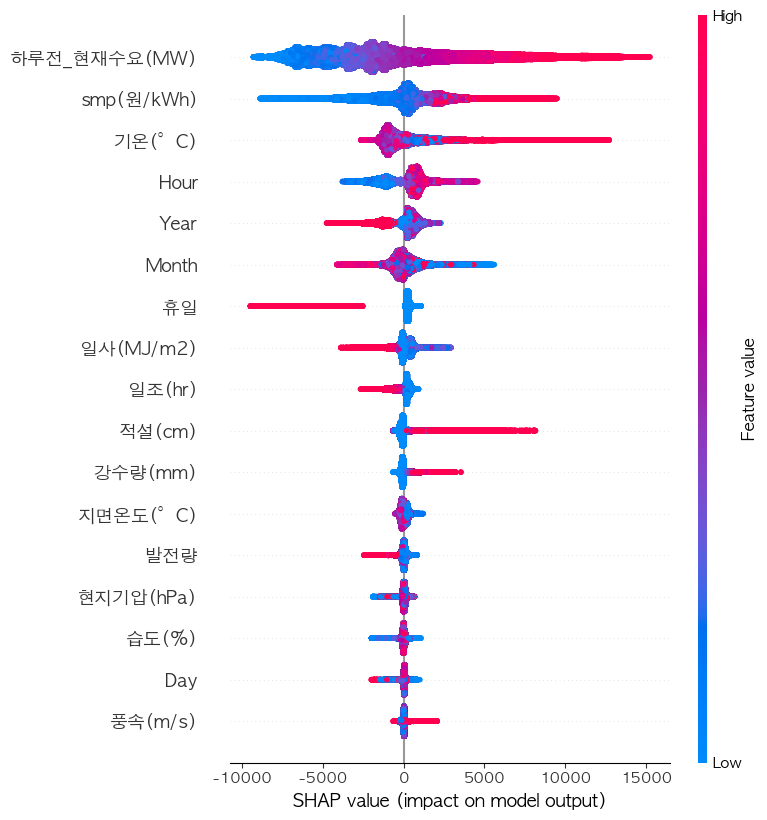

In [56]:
import shap
import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(X, y)


explainer = shap.Explainer(model)



shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

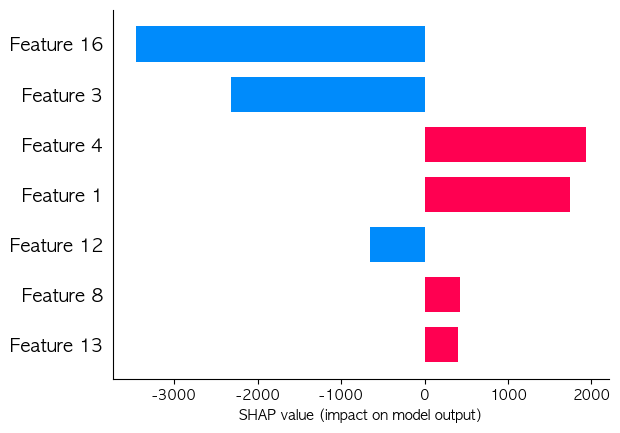

In [57]:
shap.bar_plot(shap_values[0])

In [58]:
import numpy as np

# Calculate mean absolute SHAP values
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# Print feature importance
shap = []
for feature_name, mean_value in zip(X.keys(), mean_shap_values):
    print(f"{feature_name}: {mean_value}")
    shap.append([mean_value,feature_name])


Year: 719.313814712678
Month: 542.650949205574
Day: 77.04384260414355
Hour: 1000.9766935109452
기온(°C): 1106.7750976267416
풍속(m/s): 76.86485513611495
습도(%): 79.58238694273108
현지기압(hPa): 84.53280097790875
지면온도(°C): 153.71255804031412
강수량(mm): 180.35373807191087
적설(cm): 237.76292465430305
일조(hr): 346.44804487159405
일사(MJ/m2): 362.93868823402585
smp(원/kWh): 1626.1287881065525
발전량: 106.7906934845639
휴일: 471.5528616848872
하루전_현재수요(MW): 3929.752665554796


In [59]:
shap = pd.DataFrame(shap, columns=['value', 'features'])

In [60]:
shap.sort_values('value', ascending=False, inplace=True)

In [61]:
shap['rank'] = [i for i in range(1, len(shap) + 1)]

In [62]:
shap.rename(columns={'rank':'shap_rank'}, inplace=True)

In [63]:
mrmr.set_index(['features'], inplace=True)
shap.set_index(['features'], inplace=True)

In [64]:
shap

,value,shap_rank
features,,
하루전_현재수요(MW),3929.752666,1
smp(원/kWh),1626.128788,2
기온(°C),1106.775098,3
Hour,1000.976694,4
Year,719.313815,5
Month,542.650949,6
휴일,471.552862,7
일사(MJ/m2),362.938688,8
일조(hr),346.448045,9


In [65]:
merge_df = pd.merge(mrmr, shap, left_index=True, right_index=True)
merge_df.drop('value', axis=1, inplace=True)

In [66]:
merge_df['sum'] = (merge_df['rank'] ** 2) + (merge_df['shap_rank'] **2)

In [67]:
merge_df.sort_values('sum', ascending=True, inplace=True)

In [68]:
merge_df

,rank,shap_rank,sum
features,,,
하루전_현재수요(MW),1,1,2
Hour,2,4,20
smp(원/kWh),5,2,29
휴일,3,7,58
적설(cm),4,10,116
일조(hr),8,9,145
Year,11,5,146
Month,12,6,180
기온(°C),14,3,205


# 인덱스 순위

In [69]:
merge_df.index

Index(['하루전_현재수요(MW)', 'Hour', 'smp(원/kWh)', '휴일', '적설(cm)', '일조(hr)', 'Year',
       'Month', '기온(°C)', '일사(MJ/m2)', '발전량', '습도(%)', '현지기압(hPa)', '풍속(m/s)',
       '지면온도(°C)', '강수량(mm)', 'Day'],
      dtype='object', name='features')

In [70]:
index = ['하루전_현재수요(MW)', 'Hour', 'smp(원/kWh)', '휴일', '적설(cm)', '일조(hr)', 'Year',
       'Month', '기온(°C)', '일사(MJ/m2)', '발전량','Day']

In [71]:
X = X[index]
X

,하루전_현재수요(MW),Hour,smp(원/kWh),휴일,적설(cm),일조(hr),Year,Month,기온(°C),일사(MJ/m2),발전량,Day
일시,,,,,,,,,,,,
2018-01-02 01:05:00,58194.60,1,91.991667,0,0.022105,0.0,2018,1,-2.955526,0.0,5246.400000,2
2018-01-02 01:10:00,57830.60,1,91.723333,0,0.022105,0.0,2018,1,-2.994211,0.0,5246.400000,2
2018-01-02 01:15:00,57745.30,1,91.455000,0,0.022105,0.0,2018,1,-3.032895,0.0,10428.000000,2
2018-01-02 01:20:00,57329.60,1,91.186667,0,0.022105,0.0,2018,1,-3.071579,0.0,5731.200000,2
2018-01-02 01:25:00,57219.70,1,90.918333,0,0.022105,0.0,2018,1,-3.110263,0.0,6254.400000,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-12 23:35:00,58773.93,23,220.551667,0,0.011491,0.0,2023,3,1.765000,0.0,39745.380277,12
2023-03-12 23:40:00,58326.83,23,223.523333,0,0.011930,0.0,2023,3,1.720000,0.0,39745.380277,12
2023-03-12 23:45:00,58038.45,23,226.495000,0,0.012368,0.0,2023,3,1.675000,0.0,39745.380277,12


In [72]:
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2 , random_state=33, shuffle=False)

In [73]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((436828, 12), (109207, 12), (436828,), (109207,))

In [74]:
X_test = X_test.reindex(columns=index)

X_test = X_test.iloc[:, :]

In [75]:
X.shape, X_test.shape, y.shape, y_test.shape

((546035, 12), (2016, 12), (546035,), (2016,))

# XGBoost

In [82]:
import xgboost as xgb


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_val, label=y_val)


def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mape',
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'eta': trial.suggest_loguniform('eta', 0.01, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
    }

    bst = xgb.train(params, dtrain)
    preds = bst.predict(xgb.DMatrix(X_val))
    mape = mean_absolute_percentage_error(y_val, preds)
    print("MAPE: {}".format(mape))
    return mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

print(study.best_trial)
print(study.best_value)

[I 2023-07-20 22:25:58,305] A new study created in memory with name: no-name-66ec2f58-edc5-47d5-8c64-796533db13c4
[I 2023-07-20 22:25:59,394] Trial 0 finished with value: 0.8973268162067827 and parameters: {'max_depth': 8, 'eta': 0.010256845256331904, 'gamma': 0.5497468363713897, 'subsample': 0.2759218050708978, 'colsample_bytree': 0.999978360640889}. Best is trial 0 with value: 0.8973268162067827.


MAPE: 0.8973268162067827


[I 2023-07-20 22:26:00,462] Trial 1 finished with value: 0.11553125660484276 and parameters: {'max_depth': 9, 'eta': 0.7815549535539903, 'gamma': 0.9808242067448799, 'subsample': 0.6795470076211046, 'colsample_bytree': 0.2968843156233931}. Best is trial 1 with value: 0.11553125660484276.
[I 2023-07-20 22:26:00,656] Trial 2 finished with value: 0.30900976826410953 and parameters: {'max_depth': 1, 'eta': 0.10929390020885292, 'gamma': 0.04627880108143197, 'subsample': 0.2947341096232904, 'colsample_bytree': 0.42793704857628656}. Best is trial 1 with value: 0.11553125660484276.


MAPE: 0.11553125660484276
MAPE: 0.30900976826410953


[I 2023-07-20 22:26:01,421] Trial 3 finished with value: 0.7457268070767595 and parameters: {'max_depth': 7, 'eta': 0.027327977439797473, 'gamma': 0.7564025785811366, 'subsample': 0.417440224892174, 'colsample_bytree': 0.40363682636569054}. Best is trial 1 with value: 0.11553125660484276.


MAPE: 0.7457268070767595


[I 2023-07-20 22:26:02,264] Trial 4 finished with value: 0.5996719241158163 and parameters: {'max_depth': 7, 'eta': 0.04654107190877677, 'gamma': 0.020949209871998657, 'subsample': 0.7826367430593909, 'colsample_bytree': 0.3470097328171376}. Best is trial 1 with value: 0.11553125660484276.


MAPE: 0.5996719241158163


[I 2023-07-20 22:26:02,482] Trial 5 finished with value: 0.6478942459595783 and parameters: {'max_depth': 1, 'eta': 0.04248926001189752, 'gamma': 0.02670601014936892, 'subsample': 0.7908793850535664, 'colsample_bytree': 0.23470421181187012}. Best is trial 1 with value: 0.11553125660484276.


MAPE: 0.6478942459595783


[I 2023-07-20 22:26:03,412] Trial 6 finished with value: 0.8575077763429367 and parameters: {'max_depth': 8, 'eta': 0.014489680918453186, 'gamma': 0.12995372531278668, 'subsample': 0.7734461822235046, 'colsample_bytree': 0.37275158860114466}. Best is trial 1 with value: 0.11553125660484276.


MAPE: 0.8575077763429367


[I 2023-07-20 22:26:03,768] Trial 7 finished with value: 0.06691082728496586 and parameters: {'max_depth': 3, 'eta': 0.3491776016732414, 'gamma': 0.7249667680292065, 'subsample': 0.16189200007192928, 'colsample_bytree': 0.9998935976598898}. Best is trial 7 with value: 0.06691082728496586.


MAPE: 0.06691082728496586


[I 2023-07-20 22:26:04,561] Trial 8 finished with value: 0.6839578784123628 and parameters: {'max_depth': 7, 'eta': 0.035645539110436296, 'gamma': 0.3491855992833708, 'subsample': 0.35655871459142774, 'colsample_bytree': 0.6528066059602533}. Best is trial 7 with value: 0.06691082728496586.


MAPE: 0.6839578784123628


[I 2023-07-20 22:26:04,800] Trial 9 finished with value: 0.1040485600475757 and parameters: {'max_depth': 3, 'eta': 0.6188439871486227, 'gamma': 0.010073579854526801, 'subsample': 0.12450521823705141, 'colsample_bytree': 0.22687176090187455}. Best is trial 7 with value: 0.06691082728496586.


MAPE: 0.1040485600475757


[I 2023-07-20 22:26:05,494] Trial 10 finished with value: 0.0727487178916755 and parameters: {'max_depth': 4, 'eta': 0.283187809324162, 'gamma': 0.20394892792508557, 'subsample': 0.5270275715265021, 'colsample_bytree': 0.9728927539574649}. Best is trial 7 with value: 0.06691082728496586.


MAPE: 0.0727487178916755


[I 2023-07-20 22:26:06,174] Trial 11 finished with value: 0.069088565846482 and parameters: {'max_depth': 4, 'eta': 0.30600398295093, 'gamma': 0.2378488267320007, 'subsample': 0.9724498035255302, 'colsample_bytree': 0.9798516949420667}. Best is trial 7 with value: 0.06691082728496586.


MAPE: 0.069088565846482


[I 2023-07-20 22:26:06,740] Trial 12 finished with value: 0.07465780596366582 and parameters: {'max_depth': 4, 'eta': 0.24802942135922978, 'gamma': 0.3432898966618017, 'subsample': 0.995081539332338, 'colsample_bytree': 0.8329111417942425}. Best is trial 7 with value: 0.06691082728496586.


MAPE: 0.07465780596366582


[I 2023-07-20 22:26:07,052] Trial 13 finished with value: 0.07356680911995585 and parameters: {'max_depth': 3, 'eta': 0.28818824474763516, 'gamma': 0.18889536941800758, 'subsample': 0.13285045719646638, 'colsample_bytree': 0.8238207273922538}. Best is trial 7 with value: 0.06691082728496586.


MAPE: 0.07356680911995585


[I 2023-07-20 22:26:07,510] Trial 14 finished with value: 0.18408264471661448 and parameters: {'max_depth': 5, 'eta': 0.15233848688245238, 'gamma': 0.44424261871082465, 'subsample': 0.5355249980058656, 'colsample_bytree': 0.10279248436244987}. Best is trial 7 with value: 0.06691082728496586.


MAPE: 0.18408264471661448


[I 2023-07-20 22:26:07,802] Trial 15 finished with value: 0.07703657113099542 and parameters: {'max_depth': 2, 'eta': 0.4843422349368276, 'gamma': 0.9948579989367685, 'subsample': 0.9660536429153593, 'colsample_bytree': 0.630842787819857}. Best is trial 7 with value: 0.06691082728496586.


MAPE: 0.07703657113099542


[I 2023-07-20 22:26:08,560] Trial 16 finished with value: 0.09952641944620175 and parameters: {'max_depth': 5, 'eta': 0.8537677210465275, 'gamma': 0.09200929532112012, 'subsample': 0.6194037261142205, 'colsample_bytree': 0.874842600429374}. Best is trial 7 with value: 0.06691082728496586.


MAPE: 0.09952641944620175


[I 2023-07-20 22:26:09,023] Trial 17 finished with value: 0.07366011391480616 and parameters: {'max_depth': 3, 'eta': 0.42498777657484166, 'gamma': 0.5378300659510779, 'subsample': 0.8804731141023929, 'colsample_bytree': 0.7110860661168982}. Best is trial 7 with value: 0.06691082728496586.


MAPE: 0.07366011391480616


[I 2023-07-20 22:26:10,019] Trial 18 finished with value: 0.16204149303752216 and parameters: {'max_depth': 6, 'eta': 0.15306169612445944, 'gamma': 0.31413187166029466, 'subsample': 0.4450852185955472, 'colsample_bytree': 0.9314356495244441}. Best is trial 7 with value: 0.06691082728496586.


MAPE: 0.16204149303752216


[I 2023-07-20 22:26:10,597] Trial 19 finished with value: 0.10440670867277649 and parameters: {'max_depth': 4, 'eta': 0.9036864368400479, 'gamma': 0.235287164915154, 'subsample': 0.6452212683613568, 'colsample_bytree': 0.7588367968564763}. Best is trial 7 with value: 0.06691082728496586.


MAPE: 0.10440670867277649


[I 2023-07-20 22:26:10,911] Trial 20 finished with value: 0.07023116678161376 and parameters: {'max_depth': 2, 'eta': 0.4133560396786197, 'gamma': 0.6286811851880302, 'subsample': 0.2463058336100381, 'colsample_bytree': 0.921080676718387}. Best is trial 7 with value: 0.06691082728496586.


MAPE: 0.07023116678161376


[I 2023-07-20 22:26:11,209] Trial 21 finished with value: 0.06593662489577927 and parameters: {'max_depth': 2, 'eta': 0.45447372276632547, 'gamma': 0.5829619170480367, 'subsample': 0.20818573163076737, 'colsample_bytree': 0.9261938010921792}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.06593662489577927


[I 2023-07-20 22:26:11,443] Trial 22 finished with value: 0.06950460678757558 and parameters: {'max_depth': 2, 'eta': 0.5356738963475745, 'gamma': 0.463312083088722, 'subsample': 0.19434559426176534, 'colsample_bytree': 0.9820490819838755}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.06950460678757558


[I 2023-07-20 22:26:11,777] Trial 23 finished with value: 0.09441320526887459 and parameters: {'max_depth': 3, 'eta': 0.21003711745840742, 'gamma': 0.7089990170096268, 'subsample': 0.1070170103619528, 'colsample_bytree': 0.8795150339516854}. Best is trial 21 with value: 0.06593662489577927.
[I 2023-07-20 22:26:11,975] Trial 24 finished with value: 0.06914934643081685 and parameters: {'max_depth': 1, 'eta': 0.3464831798729499, 'gamma': 0.2837419655963441, 'subsample': 0.20803559624573864, 'colsample_bytree': 0.7900465086843457}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.09441320526887459
MAPE: 0.06914934643081685


[I 2023-07-20 22:26:12,502] Trial 25 finished with value: 0.090406372523598 and parameters: {'max_depth': 4, 'eta': 0.6428493854801712, 'gamma': 0.4598694948577061, 'subsample': 0.3428727238903494, 'colsample_bytree': 0.8965104709104313}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.090406372523598


[I 2023-07-20 22:26:12,785] Trial 26 finished with value: 0.07356997523623884 and parameters: {'max_depth': 2, 'eta': 0.42728588375985344, 'gamma': 0.16128425631511267, 'subsample': 0.19568310713809095, 'colsample_bytree': 0.9342167425899617}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.07356997523623884


[I 2023-07-20 22:26:13,604] Trial 27 finished with value: 0.09427127215281154 and parameters: {'max_depth': 5, 'eta': 0.20574986919633104, 'gamma': 0.2566341434696884, 'subsample': 0.4480110361262961, 'colsample_bytree': 0.9945332926511159}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.09427127215281154


[I 2023-07-20 22:26:14,438] Trial 28 finished with value: 0.07394619652803064 and parameters: {'max_depth': 6, 'eta': 0.34288726467541036, 'gamma': 0.3775112049859146, 'subsample': 0.3386012086047737, 'colsample_bytree': 0.8499650965891389}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.07394619652803064


[I 2023-07-20 22:26:14,837] Trial 29 finished with value: 0.0758498124273181 and parameters: {'max_depth': 3, 'eta': 0.5423435777289773, 'gamma': 0.6293854360798328, 'subsample': 0.233054684649855, 'colsample_bytree': 0.9880388950649012}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.0758498124273181


[I 2023-07-20 22:26:15,868] Trial 30 finished with value: 0.41145764920183403 and parameters: {'max_depth': 10, 'eta': 0.07899780664191329, 'gamma': 0.4884658588173485, 'subsample': 0.2780326934714201, 'colsample_bytree': 0.7556482120176304}. Best is trial 21 with value: 0.06593662489577927.
[I 2023-07-20 22:26:16,033] Trial 31 finished with value: 0.069023018942964 and parameters: {'max_depth': 1, 'eta': 0.3484153663960934, 'gamma': 0.29784004019442095, 'subsample': 0.17541215402149657, 'colsample_bytree': 0.8133474058911941}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.41145764920183403
MAPE: 0.069023018942964


[I 2023-07-20 22:26:16,209] Trial 32 finished with value: 0.06922301257959089 and parameters: {'max_depth': 1, 'eta': 0.6999932453326313, 'gamma': 0.8374823695999645, 'subsample': 0.15382194855319148, 'colsample_bytree': 0.9014901662828144}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.06922301257959089


[I 2023-07-20 22:26:16,435] Trial 33 finished with value: 0.0767780417067136 and parameters: {'max_depth': 2, 'eta': 0.9243771852219332, 'gamma': 0.5935670388140197, 'subsample': 0.1010964192275281, 'colsample_bytree': 0.9435132263457093}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.0767780417067136


[I 2023-07-20 22:26:16,665] Trial 34 finished with value: 0.07087707530700486 and parameters: {'max_depth': 1, 'eta': 0.3205335462749895, 'gamma': 0.8397280314015958, 'subsample': 0.28873818089047626, 'colsample_bytree': 0.8391185980340209}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.07087707530700486


[I 2023-07-20 22:26:16,947] Trial 35 finished with value: 0.07314095002733124 and parameters: {'max_depth': 2, 'eta': 0.6709853198798861, 'gamma': 0.2597717232207168, 'subsample': 0.18961000958503493, 'colsample_bytree': 0.995880901633982}. Best is trial 21 with value: 0.06593662489577927.
[I 2023-07-20 22:26:17,136] Trial 36 finished with value: 0.0688524579759245 and parameters: {'max_depth': 1, 'eta': 0.3820559095347515, 'gamma': 0.9993251723067528, 'subsample': 0.1623043416864721, 'colsample_bytree': 0.9259305238295092}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.07314095002733124
MAPE: 0.0688524579759245


[I 2023-07-20 22:26:17,338] Trial 37 finished with value: 0.06941752607172748 and parameters: {'max_depth': 1, 'eta': 0.4145519388244336, 'gamma': 0.9187804520076784, 'subsample': 0.162204708859575, 'colsample_bytree': 0.889678071460441}. Best is trial 21 with value: 0.06593662489577927.
[I 2023-07-20 22:26:17,527] Trial 38 finished with value: 0.09383135578686365 and parameters: {'max_depth': 1, 'eta': 0.2276634261438372, 'gamma': 0.7251415877985733, 'subsample': 0.24886690202532888, 'colsample_bytree': 0.802525395426325}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.06941752607172748
MAPE: 0.09383135578686365


[I 2023-07-20 22:26:17,773] Trial 39 finished with value: 0.08656749985447 and parameters: {'max_depth': 2, 'eta': 0.98680706760579, 'gamma': 0.986703754095253, 'subsample': 0.1528729235620632, 'colsample_bytree': 0.5010001894352362}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.08656749985447


[I 2023-07-20 22:26:17,976] Trial 40 finished with value: 0.0694182411786594 and parameters: {'max_depth': 1, 'eta': 0.56609462267867, 'gamma': 0.6265240648770524, 'subsample': 0.2974759595698484, 'colsample_bytree': 0.8526135469966805}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.0694182411786594


[I 2023-07-20 22:26:18,385] Trial 41 finished with value: 0.06857106945947389 and parameters: {'max_depth': 3, 'eta': 0.3611960664789093, 'gamma': 0.3859109686702539, 'subsample': 0.2154954824581047, 'colsample_bytree': 0.9470904632493027}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.06857106945947389


[I 2023-07-20 22:26:18,793] Trial 42 finished with value: 0.06808812299996887 and parameters: {'max_depth': 3, 'eta': 0.3596193220529115, 'gamma': 0.38907729992355644, 'subsample': 0.23588663748311084, 'colsample_bytree': 0.9383691766486687}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.06808812299996887


[I 2023-07-20 22:26:19,187] Trial 43 finished with value: 0.07207808223944345 and parameters: {'max_depth': 3, 'eta': 0.47105978965363293, 'gamma': 0.4161740512063177, 'subsample': 0.21951069026008327, 'colsample_bytree': 0.9449537992688574}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.07207808223944345


[I 2023-07-20 22:26:19,600] Trial 44 finished with value: 0.0841490648580656 and parameters: {'max_depth': 3, 'eta': 0.7056247424655243, 'gamma': 0.761897612283335, 'subsample': 0.24283406539872499, 'colsample_bytree': 0.9456802496469563}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.0841490648580656


[I 2023-07-20 22:26:20,039] Trial 45 finished with value: 0.07357311193677306 and parameters: {'max_depth': 4, 'eta': 0.25516340070450344, 'gamma': 0.5267157226252575, 'subsample': 0.1414485012695722, 'colsample_bytree': 0.9076557655537404}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.07357311193677306


[I 2023-07-20 22:26:20,389] Trial 46 finished with value: 0.13605022410076154 and parameters: {'max_depth': 2, 'eta': 0.17854755794057373, 'gamma': 0.3600219002153885, 'subsample': 0.38463709090214454, 'colsample_bytree': 0.8715817805745542}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.13605022410076154


[I 2023-07-20 22:26:20,820] Trial 47 finished with value: 0.07626775010965066 and parameters: {'max_depth': 3, 'eta': 0.24717618824098642, 'gamma': 0.7937967029248313, 'subsample': 0.30052630244660167, 'colsample_bytree': 0.9617021774038963}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.07626775010965066


[I 2023-07-20 22:26:21,249] Trial 48 finished with value: 0.0689767257388225 and parameters: {'max_depth': 4, 'eta': 0.28584969283971634, 'gamma': 0.38985122404043704, 'subsample': 0.12069661285859051, 'colsample_bytree': 0.9984464097223269}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.0689767257388225


[I 2023-07-20 22:26:21,560] Trial 49 finished with value: 0.06642763790197201 and parameters: {'max_depth': 2, 'eta': 0.37127833572994573, 'gamma': 0.5755583292343424, 'subsample': 0.2637714495992902, 'colsample_bytree': 0.9352994914396057}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.06642763790197201


[I 2023-07-20 22:26:22,575] Trial 50 finished with value: 0.0920711281586067 and parameters: {'max_depth': 8, 'eta': 0.527046511840006, 'gamma': 0.5368803695484349, 'subsample': 0.2630730245898924, 'colsample_bytree': 0.8655669496579695}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.0920711281586067


[I 2023-07-20 22:26:22,858] Trial 51 finished with value: 0.06612759154389417 and parameters: {'max_depth': 2, 'eta': 0.4006179932066429, 'gamma': 0.6937333213979394, 'subsample': 0.21560187801743627, 'colsample_bytree': 0.9196694135393929}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.06612759154389417


[I 2023-07-20 22:26:23,260] Trial 52 finished with value: 0.06739395462153733 and parameters: {'max_depth': 3, 'eta': 0.30111866823249295, 'gamma': 0.6484887621838816, 'subsample': 0.2150666282492309, 'colsample_bytree': 0.9558817273437804}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.06739395462153733


[I 2023-07-20 22:26:23,562] Trial 53 finished with value: 0.06780232359151828 and parameters: {'max_depth': 2, 'eta': 0.4620416254985746, 'gamma': 0.7056347240985317, 'subsample': 0.3185447660474052, 'colsample_bytree': 0.90492778788278}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.06780232359151828


[I 2023-07-20 22:26:23,879] Trial 54 finished with value: 0.06796753477262887 and parameters: {'max_depth': 2, 'eta': 0.5101382180642454, 'gamma': 0.6355630624780805, 'subsample': 0.3148813080428567, 'colsample_bytree': 0.8996328266693095}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.06796753477262887


[I 2023-07-20 22:26:24,202] Trial 55 finished with value: 0.07242398048563779 and parameters: {'max_depth': 2, 'eta': 0.2714894096606087, 'gamma': 0.708676095443784, 'subsample': 0.2678637485693918, 'colsample_bytree': 0.9605098106800749}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.07242398048563779


[I 2023-07-20 22:26:24,472] Trial 56 finished with value: 0.08203429699666548 and parameters: {'max_depth': 2, 'eta': 0.771380726248127, 'gamma': 0.5252308210904599, 'subsample': 0.19070688361338584, 'colsample_bytree': 0.8375823804082909}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.08203429699666548


[I 2023-07-20 22:26:24,904] Trial 57 finished with value: 0.07819865819653835 and parameters: {'max_depth': 3, 'eta': 0.44193723613954916, 'gamma': 0.8356785656355886, 'subsample': 0.3325100602729781, 'colsample_bytree': 0.9114269474491858}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.07819865819653835


[I 2023-07-20 22:26:25,502] Trial 58 finished with value: 0.06829311996882123 and parameters: {'max_depth': 4, 'eta': 0.31667034292429436, 'gamma': 0.6804784849259071, 'subsample': 0.37143383984451256, 'colsample_bytree': 0.9678243068217324}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.06829311996882123


[I 2023-07-20 22:26:25,810] Trial 59 finished with value: 0.07324042180482089 and parameters: {'max_depth': 2, 'eta': 0.6017847212929164, 'gamma': 0.4451552289138018, 'subsample': 0.31552180300644245, 'colsample_bytree': 0.8667189737348595}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.07324042180482089


[I 2023-07-20 22:26:26,139] Trial 60 finished with value: 0.07455298838389916 and parameters: {'max_depth': 3, 'eta': 0.47448138722623856, 'gamma': 0.5780612636441383, 'subsample': 0.13083651229783555, 'colsample_bytree': 0.7811288035907867}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.07455298838389916


[I 2023-07-20 22:26:26,454] Trial 61 finished with value: 0.06725847807698816 and parameters: {'max_depth': 2, 'eta': 0.4812518614130095, 'gamma': 0.6388087686620971, 'subsample': 0.2726716230220545, 'colsample_bytree': 0.9047358040731216}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.06725847807698816


[I 2023-07-20 22:26:26,720] Trial 62 finished with value: 0.08528623047389883 and parameters: {'max_depth': 2, 'eta': 0.4197652524374409, 'gamma': 0.7241098385256318, 'subsample': 0.20659508563984735, 'colsample_bytree': 0.9117862889788051}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.08528623047389883


[I 2023-07-20 22:26:27,036] Trial 63 finished with value: 0.0673308585835336 and parameters: {'max_depth': 2, 'eta': 0.5926082661785981, 'gamma': 0.482298510043802, 'subsample': 0.27259332942713455, 'colsample_bytree': 0.9706430284186675}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.0673308585835336


[I 2023-07-20 22:26:27,355] Trial 64 finished with value: 0.07666233789006546 and parameters: {'max_depth': 2, 'eta': 0.623324007784852, 'gamma': 0.48817814806679194, 'subsample': 0.26906024449460164, 'colsample_bytree': 0.963218925256382}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.07666233789006546


[I 2023-07-20 22:26:28,544] Trial 65 finished with value: 0.10414544478985355 and parameters: {'max_depth': 9, 'eta': 0.8366196838420203, 'gamma': 0.5629294525328371, 'subsample': 0.1789697048717039, 'colsample_bytree': 0.9745901028286778}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.10414544478985355


[I 2023-07-20 22:26:28,948] Trial 66 finished with value: 0.06689006885587259 and parameters: {'max_depth': 3, 'eta': 0.30894695536217437, 'gamma': 0.46351668406615637, 'subsample': 0.23996273721141329, 'colsample_bytree': 0.9989601565021954}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.06689006885587259


[I 2023-07-20 22:26:29,642] Trial 67 finished with value: 0.07094793312098892 and parameters: {'max_depth': 5, 'eta': 0.3885800958129983, 'gamma': 0.34372335114486696, 'subsample': 0.28583537343533527, 'colsample_bytree': 0.9862981614823872}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.07094793312098892


[I 2023-07-20 22:26:29,870] Trial 68 finished with value: 0.06763851127635638 and parameters: {'max_depth': 1, 'eta': 0.5549646751575368, 'gamma': 0.44872994885775436, 'subsample': 0.2456584171954923, 'colsample_bytree': 0.9999216247130881}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.06763851127635638


[I 2023-07-20 22:26:30,663] Trial 69 finished with value: 0.09446732245819221 and parameters: {'max_depth': 7, 'eta': 0.7370183146547579, 'gamma': 0.2978185154162398, 'subsample': 0.10327012612670053, 'colsample_bytree': 0.9262993588417574}. Best is trial 21 with value: 0.06593662489577927.


MAPE: 0.09446732245819221


[I 2023-07-20 22:26:31,099] Trial 70 finished with value: 0.06496497870081397 and parameters: {'max_depth': 3, 'eta': 0.32374576351924017, 'gamma': 0.5073899857831389, 'subsample': 0.3556228382368175, 'colsample_bytree': 0.8848747816058495}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.06496497870081397


[I 2023-07-20 22:26:31,488] Trial 71 finished with value: 0.06581640944807685 and parameters: {'max_depth': 3, 'eta': 0.30376669972093573, 'gamma': 0.49197132214197914, 'subsample': 0.27102494578803604, 'colsample_bytree': 0.8779394753446043}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.06581640944807685


[I 2023-07-20 22:26:31,854] Trial 72 finished with value: 0.06861815504711379 and parameters: {'max_depth': 3, 'eta': 0.3284772584380771, 'gamma': 0.8711007780812505, 'subsample': 0.2254024117522241, 'colsample_bytree': 0.822943826412106}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.06861815504711379


[I 2023-07-20 22:26:32,413] Trial 73 finished with value: 0.08105272527763176 and parameters: {'max_depth': 4, 'eta': 0.2282028530141624, 'gamma': 0.5882113850164595, 'subsample': 0.36120221581960804, 'colsample_bytree': 0.8804394193951454}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.08105272527763176


[I 2023-07-20 22:26:32,755] Trial 74 finished with value: 0.0701556378685067 and parameters: {'max_depth': 3, 'eta': 0.2758926129995972, 'gamma': 0.3277949204913834, 'subsample': 0.16023948183186362, 'colsample_bytree': 0.8443874299798555}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.0701556378685067


[I 2023-07-20 22:26:33,190] Trial 75 finished with value: 0.07255795238860964 and parameters: {'max_depth': 4, 'eta': 0.3683975898389849, 'gamma': 0.42903305774429673, 'subsample': 0.1755936162634335, 'colsample_bytree': 0.8796494002513744}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.07255795238860964


[I 2023-07-20 22:26:33,624] Trial 76 finished with value: 0.06976031394783128 and parameters: {'max_depth': 3, 'eta': 0.30810694604439187, 'gamma': 0.786795208091939, 'subsample': 0.25667430429810156, 'colsample_bytree': 0.9239630016871035}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.06976031394783128


[I 2023-07-20 22:26:34,289] Trial 77 finished with value: 0.07917647927948981 and parameters: {'max_depth': 6, 'eta': 0.41178553259072415, 'gamma': 0.5302732112832168, 'subsample': 0.20008529070199302, 'colsample_bytree': 0.8161533199743276}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.07917647927948981


[I 2023-07-20 22:26:34,583] Trial 78 finished with value: 0.06859061998875919 and parameters: {'max_depth': 2, 'eta': 0.4852231569972, 'gamma': 0.878476737635879, 'subsample': 0.28935003252608626, 'colsample_bytree': 0.8908713708588147}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.06859061998875919


[I 2023-07-20 22:26:34,922] Trial 79 finished with value: 0.10136080827115647 and parameters: {'max_depth': 3, 'eta': 0.19706343036447946, 'gamma': 0.6074061157803045, 'subsample': 0.23032123928595635, 'colsample_bytree': 0.8558392372545429}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.10136080827115647


[I 2023-07-20 22:26:35,550] Trial 80 finished with value: 0.07024252567896377 and parameters: {'max_depth': 4, 'eta': 0.3771727635437201, 'gamma': 0.4916862606281317, 'subsample': 0.40162482634908175, 'colsample_bytree': 0.9277277435899031}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.07024252567896377


[I 2023-07-20 22:26:35,937] Trial 81 finished with value: 0.07444827550723572 and parameters: {'max_depth': 2, 'eta': 0.5997747356004522, 'gamma': 0.48850738925027815, 'subsample': 0.26905800820764253, 'colsample_bytree': 0.9720243430700302}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.07444827550723572


[I 2023-07-20 22:26:36,290] Trial 82 finished with value: 0.06863970680819216 and parameters: {'max_depth': 2, 'eta': 0.5085057227031262, 'gamma': 0.4169498583573912, 'subsample': 0.3562959557272135, 'colsample_bytree': 0.9543316579449747}. Best is trial 70 with value: 0.06496497870081397.
[I 2023-07-20 22:26:36,489] Trial 83 finished with value: 0.07088517145713184 and parameters: {'max_depth': 1, 'eta': 0.330835393417881, 'gamma': 0.657565659009299, 'subsample': 0.23799878727432208, 'colsample_bytree': 0.9764638699707784}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.06863970680819216
MAPE: 0.07088517145713184


[I 2023-07-20 22:26:36,796] Trial 84 finished with value: 0.06749538364345085 and parameters: {'max_depth': 2, 'eta': 0.43889397654495865, 'gamma': 0.5633640385494364, 'subsample': 0.30813033932374523, 'colsample_bytree': 0.9397570650346021}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.06749538364345085


[I 2023-07-20 22:26:37,002] Trial 85 finished with value: 0.08191749005758706 and parameters: {'max_depth': 1, 'eta': 0.2567971671057196, 'gamma': 0.7698853702413088, 'subsample': 0.3307914938796762, 'colsample_bytree': 0.8922395404236829}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.08191749005758706


[I 2023-07-20 22:26:37,410] Trial 86 finished with value: 0.06830718989803702 and parameters: {'max_depth': 3, 'eta': 0.37881159892689764, 'gamma': 0.3449452297853312, 'subsample': 0.28185066120077823, 'colsample_bytree': 0.9178962909620887}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.06830718989803702


[I 2023-07-20 22:26:37,694] Trial 87 finished with value: 0.07481500630388468 and parameters: {'max_depth': 2, 'eta': 0.6757747041711879, 'gamma': 0.9050601869756367, 'subsample': 0.20765522287490018, 'colsample_bytree': 0.9968863781823984}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.07481500630388468


[I 2023-07-20 22:26:37,920] Trial 88 finished with value: 0.07532956165944911 and parameters: {'max_depth': 1, 'eta': 0.28383513059533383, 'gamma': 0.3980754601057829, 'subsample': 0.2557812881680719, 'colsample_bytree': 0.9447100612710504}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.07532956165944911


[I 2023-07-20 22:26:38,203] Trial 89 finished with value: 0.07294447669732287 and parameters: {'max_depth': 3, 'eta': 0.5814522147979139, 'gamma': 0.45412526716150364, 'subsample': 0.17752355142095816, 'colsample_bytree': 0.8546479812560233}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.07294447669732287


[I 2023-07-20 22:26:38,430] Trial 90 finished with value: 0.06680548706815055 and parameters: {'max_depth': 2, 'eta': 0.3446767815676252, 'gamma': 0.6494359379681268, 'subsample': 0.14434378956472665, 'colsample_bytree': 0.9743133081026327}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.06680548706815055


[I 2023-07-20 22:26:38,725] Trial 91 finished with value: 0.06706982341243065 and parameters: {'max_depth': 2, 'eta': 0.3380528595680445, 'gamma': 0.6723111383883651, 'subsample': 0.2225554733786288, 'colsample_bytree': 0.9766822008451155}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.06706982341243065


[I 2023-07-20 22:26:39,008] Trial 92 finished with value: 0.06661921497752792 and parameters: {'max_depth': 2, 'eta': 0.3423405676045453, 'gamma': 0.6730754694916073, 'subsample': 0.15461393956003724, 'colsample_bytree': 0.9240546694382231}. Best is trial 70 with value: 0.06496497870081397.


MAPE: 0.06661921497752792


[I 2023-07-20 22:26:39,374] Trial 93 finished with value: 0.06461683461420206 and parameters: {'max_depth': 3, 'eta': 0.33889171014160335, 'gamma': 0.9985752396427786, 'subsample': 0.1406030654174551, 'colsample_bytree': 0.9807210152279597}. Best is trial 93 with value: 0.06461683461420206.


MAPE: 0.06461683461420206


[I 2023-07-20 22:26:39,716] Trial 94 finished with value: 0.06869663752429758 and parameters: {'max_depth': 3, 'eta': 0.29917776367916227, 'gamma': 0.9478125207285713, 'subsample': 0.13551426348590925, 'colsample_bytree': 0.9404858926596072}. Best is trial 93 with value: 0.06461683461420206.


MAPE: 0.06869663752429758


[I 2023-07-20 22:26:40,057] Trial 95 finished with value: 0.07939922584082709 and parameters: {'max_depth': 3, 'eta': 0.2423786631315504, 'gamma': 0.7784630718649421, 'subsample': 0.1470525659181996, 'colsample_bytree': 0.9566779534459614}. Best is trial 93 with value: 0.06461683461420206.


MAPE: 0.07939922584082709


[I 2023-07-20 22:26:40,375] Trial 96 finished with value: 0.06817768613041685 and parameters: {'max_depth': 3, 'eta': 0.4021814214935883, 'gamma': 0.847157912697759, 'subsample': 0.15387384271002452, 'colsample_bytree': 0.998490549380108}. Best is trial 93 with value: 0.06461683461420206.


MAPE: 0.06817768613041685


[I 2023-07-20 22:26:40,811] Trial 97 finished with value: 0.06757084463809035 and parameters: {'max_depth': 4, 'eta': 0.3490448778607944, 'gamma': 0.7238001981725749, 'subsample': 0.12689970116045812, 'colsample_bytree': 0.9206028945522454}. Best is trial 93 with value: 0.06461683461420206.


MAPE: 0.06757084463809035


[I 2023-07-20 22:26:41,084] Trial 98 finished with value: 0.06875898880066633 and parameters: {'max_depth': 2, 'eta': 0.29013646438228247, 'gamma': 0.9753147715004671, 'subsample': 0.19060156438738135, 'colsample_bytree': 0.8793502066394238}. Best is trial 93 with value: 0.06461683461420206.


MAPE: 0.06875898880066633


[I 2023-07-20 22:26:41,455] Trial 99 finished with value: 0.08343815279124461 and parameters: {'max_depth': 4, 'eta': 0.43740262010731285, 'gamma': 0.594343859539673, 'subsample': 0.11836749802905402, 'colsample_bytree': 0.9792696744438294}. Best is trial 93 with value: 0.06461683461420206.


MAPE: 0.08343815279124461


[I 2023-07-20 22:26:41,834] Trial 100 finished with value: 0.06977059554139094 and parameters: {'max_depth': 3, 'eta': 0.3182217111164377, 'gamma': 0.8001969182549385, 'subsample': 0.17094960885285293, 'colsample_bytree': 0.9376095892958484}. Best is trial 93 with value: 0.06461683461420206.


MAPE: 0.06977059554139094


[I 2023-07-20 22:26:42,179] Trial 101 finished with value: 0.06692123805828694 and parameters: {'max_depth': 2, 'eta': 0.34519895686988633, 'gamma': 0.6759633089434858, 'subsample': 0.22232064625721865, 'colsample_bytree': 0.971573110186323}. Best is trial 93 with value: 0.06461683461420206.


MAPE: 0.06692123805828694
MAPE: 0.07875172054638067


[I 2023-07-20 22:26:42,380] Trial 102 finished with value: 0.07875172054638067 and parameters: {'max_depth': 1, 'eta': 0.2666897719910698, 'gamma': 0.6735318128572965, 'subsample': 0.19265871481284172, 'colsample_bytree': 0.9584584516641002}. Best is trial 93 with value: 0.06461683461420206.
[I 2023-07-20 22:26:42,642] Trial 103 finished with value: 0.06697285615086206 and parameters: {'max_depth': 2, 'eta': 0.3894231010195496, 'gamma': 0.5323548047132527, 'subsample': 0.1435138102010772, 'colsample_bytree': 0.9042515110436337}. Best is trial 93 with value: 0.06461683461420206.


MAPE: 0.06697285615086206


[I 2023-07-20 22:26:42,906] Trial 104 finished with value: 0.0643011622017439 and parameters: {'max_depth': 2, 'eta': 0.3541094560872518, 'gamma': 0.7354434092086214, 'subsample': 0.16435697494144327, 'colsample_bytree': 0.9837313251315768}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.0643011622017439


[I 2023-07-20 22:26:43,239] Trial 105 finished with value: 0.08161969611410158 and parameters: {'max_depth': 3, 'eta': 0.23498969703085654, 'gamma': 0.753886681355297, 'subsample': 0.1668845940252635, 'colsample_bytree': 0.9301447810140124}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.08161969611410158


[I 2023-07-20 22:26:43,777] Trial 106 finished with value: 0.07392913582934826 and parameters: {'max_depth': 5, 'eta': 0.4578220391731024, 'gamma': 0.5957422180462465, 'subsample': 0.11446390399479761, 'colsample_bytree': 0.9877279587011843}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.07392913582934826


[I 2023-07-20 22:26:44,023] Trial 107 finished with value: 0.0675345793874458 and parameters: {'max_depth': 2, 'eta': 0.3100678353675187, 'gamma': 0.8990595210800648, 'subsample': 0.2071538521451285, 'colsample_bytree': 0.9536502816903459}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.0675345793874458


[I 2023-07-20 22:26:44,336] Trial 108 finished with value: 0.07244484063019878 and parameters: {'max_depth': 3, 'eta': 0.2691990766379349, 'gamma': 0.5204366946136159, 'subsample': 0.1445783266776343, 'colsample_bytree': 0.8900255087147969}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.07244484063019878


[I 2023-07-20 22:26:44,546] Trial 109 finished with value: 0.07016933941783818 and parameters: {'max_depth': 2, 'eta': 0.36629239088315535, 'gamma': 0.8381675375859299, 'subsample': 0.18085090647620877, 'colsample_bytree': 0.9155178722504939}. Best is trial 104 with value: 0.0643011622017439.
[I 2023-07-20 22:26:44,709] Trial 110 finished with value: 0.06907836311142185 and parameters: {'max_depth': 1, 'eta': 0.5060933616131068, 'gamma': 0.9990428148528758, 'subsample': 0.1018572318665265, 'colsample_bytree': 0.8679636303189466}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.07016933941783818
MAPE: 0.06907836311142185


[I 2023-07-20 22:26:44,979] Trial 111 finished with value: 0.06706410359063425 and parameters: {'max_depth': 2, 'eta': 0.3459969547772464, 'gamma': 0.6963208187765455, 'subsample': 0.23307812026120078, 'colsample_bytree': 0.9841171712638307}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06706410359063425


[I 2023-07-20 22:26:45,235] Trial 112 finished with value: 0.07166798359989658 and parameters: {'max_depth': 2, 'eta': 0.42631783682118624, 'gamma': 0.6293351994983334, 'subsample': 0.21889615895910305, 'colsample_bytree': 0.9657181065036944}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.07166798359989658


[I 2023-07-20 22:26:45,503] Trial 113 finished with value: 0.068030064678383 and parameters: {'max_depth': 2, 'eta': 0.3893855471206347, 'gamma': 0.5647108212448134, 'subsample': 0.2494000607976396, 'colsample_bytree': 0.9982703354429031}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.068030064678383


[I 2023-07-20 22:26:45,819] Trial 114 finished with value: 0.0691201446393215 and parameters: {'max_depth': 3, 'eta': 0.29690029216200703, 'gamma': 0.7235297055291748, 'subsample': 0.16223308326696073, 'colsample_bytree': 0.9453120213185341}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.0691201446393215


[I 2023-07-20 22:26:46,054] Trial 115 finished with value: 0.06644805197612859 and parameters: {'max_depth': 2, 'eta': 0.3390853107608474, 'gamma': 0.6421793882570717, 'subsample': 0.19741120706088558, 'colsample_bytree': 0.9735977388053727}. Best is trial 104 with value: 0.0643011622017439.
[I 2023-07-20 22:26:46,239] Trial 116 finished with value: 0.08355877367536098 and parameters: {'max_depth': 1, 'eta': 0.2519077979853806, 'gamma': 0.4552435961891566, 'subsample': 0.1286720064694276, 'colsample_bytree': 0.9280733819185512}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06644805197612859
MAPE: 0.08355877367536098


[I 2023-07-20 22:26:46,560] Trial 117 finished with value: 0.09431857018085131 and parameters: {'max_depth': 3, 'eta': 0.21310942270308117, 'gamma': 0.5032345291115022, 'subsample': 0.1976787089172302, 'colsample_bytree': 0.9585700702925487}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.09431857018085131


[I 2023-07-20 22:26:46,788] Trial 118 finished with value: 0.06763181191117655 and parameters: {'max_depth': 2, 'eta': 0.3216600630459245, 'gamma': 0.37069549320133166, 'subsample': 0.18165552766773502, 'colsample_bytree': 0.9045134219748471}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06763181191117655


[I 2023-07-20 22:26:47,164] Trial 119 finished with value: 0.07140550573578267 and parameters: {'max_depth': 3, 'eta': 0.5327689038803265, 'gamma': 0.5695893953428054, 'subsample': 0.19940807523934195, 'colsample_bytree': 0.9828647383155337}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.07140550573578267


[I 2023-07-20 22:26:47,428] Trial 120 finished with value: 0.07104543177554108 and parameters: {'max_depth': 2, 'eta': 0.4089856818771281, 'gamma': 0.8071181614489287, 'subsample': 0.16220172844011352, 'colsample_bytree': 0.8363250889817573}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.07104543177554108


[I 2023-07-20 22:26:47,718] Trial 121 finished with value: 0.06986071084357938 and parameters: {'max_depth': 2, 'eta': 0.3460509870190812, 'gamma': 0.6656695868234174, 'subsample': 0.22304667420893615, 'colsample_bytree': 0.973680052509692}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06986071084357938


[I 2023-07-20 22:26:48,025] Trial 122 finished with value: 0.0662387510440137 and parameters: {'max_depth': 2, 'eta': 0.3625574275620889, 'gamma': 0.6328183601265217, 'subsample': 0.24594386192759612, 'colsample_bytree': 0.9425789008054811}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.0662387510440137


[I 2023-07-20 22:26:48,357] Trial 123 finished with value: 0.06593881143365034 and parameters: {'max_depth': 2, 'eta': 0.4587476481099396, 'gamma': 0.6154657643073311, 'subsample': 0.2504044129647373, 'colsample_bytree': 0.9369093285104882}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06593881143365034


[I 2023-07-20 22:26:48,635] Trial 124 finished with value: 0.06781155889591595 and parameters: {'max_depth': 2, 'eta': 0.45416610576064337, 'gamma': 0.607088682833544, 'subsample': 0.29609236295902275, 'colsample_bytree': 0.8834800955230779}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06781155889591595


[I 2023-07-20 22:26:48,852] Trial 125 finished with value: 0.06837868864286847 and parameters: {'max_depth': 1, 'eta': 0.37795810464232643, 'gamma': 0.423504274869424, 'subsample': 0.24836483229298023, 'colsample_bytree': 0.9224789747108544}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06837868864286847


[I 2023-07-20 22:26:49,157] Trial 126 finished with value: 0.06896819802889599 and parameters: {'max_depth': 2, 'eta': 0.28662642062257154, 'gamma': 0.510150037355686, 'subsample': 0.25609107580770063, 'colsample_bytree': 0.9468680502635254}. Best is trial 104 with value: 0.0643011622017439.
[I 2023-07-20 22:26:49,344] Trial 127 finished with value: 0.06942279736400066 and parameters: {'max_depth': 1, 'eta': 0.4663603165890798, 'gamma': 0.7521202884460895, 'subsample': 0.23477799897406332, 'colsample_bytree': 0.9001200525245132}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06896819802889599
MAPE: 0.06942279736400066


[I 2023-07-20 22:26:49,687] Trial 128 finished with value: 0.0718048913708954 and parameters: {'max_depth': 2, 'eta': 0.4038706579674254, 'gamma': 0.5443754135098177, 'subsample': 0.2814878081545839, 'colsample_bytree': 0.9401495040097789}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.0718048913708954


[I 2023-07-20 22:26:50,005] Trial 129 finished with value: 0.0689702352127487 and parameters: {'max_depth': 2, 'eta': 0.3173068080831675, 'gamma': 0.6402218898084929, 'subsample': 0.29840106635095237, 'colsample_bytree': 0.8644575144582441}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.0689702352127487


[I 2023-07-20 22:26:50,264] Trial 130 finished with value: 0.06794290148743506 and parameters: {'max_depth': 2, 'eta': 0.5176711560510303, 'gamma': 0.47580908139407263, 'subsample': 0.21060288891994638, 'colsample_bytree': 0.9108946318966548}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06794290148743506


[I 2023-07-20 22:26:50,634] Trial 131 finished with value: 0.06538393224966761 and parameters: {'max_depth': 3, 'eta': 0.3578930927873965, 'gamma': 0.7260879812392693, 'subsample': 0.18578818001713215, 'colsample_bytree': 0.9644521960069242}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06538393224966761


[I 2023-07-20 22:26:50,991] Trial 132 finished with value: 0.06883194330157083 and parameters: {'max_depth': 3, 'eta': 0.3685229709669866, 'gamma': 0.8544568278944302, 'subsample': 0.1858415556134241, 'colsample_bytree': 0.9657568731667602}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06883194330157083


[I 2023-07-20 22:26:51,368] Trial 133 finished with value: 0.07220240062509817 and parameters: {'max_depth': 3, 'eta': 0.27106206373364294, 'gamma': 0.60825018162549, 'subsample': 0.14743190354936386, 'colsample_bytree': 0.9339795765716395}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.07220240062509817


[I 2023-07-20 22:26:51,677] Trial 134 finished with value: 0.07096929856711671 and parameters: {'max_depth': 2, 'eta': 0.42043359978579464, 'gamma': 0.915855799995423, 'subsample': 0.2433955555391031, 'colsample_bytree': 0.9539527153647722}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.07096929856711671


[I 2023-07-20 22:26:51,970] Trial 135 finished with value: 0.06646277898409332 and parameters: {'max_depth': 2, 'eta': 0.33760974707583763, 'gamma': 0.7724311280976324, 'subsample': 0.20474985838832774, 'colsample_bytree': 0.9810692343362897}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06646277898409332


[I 2023-07-20 22:26:52,227] Trial 136 finished with value: 0.06478336194124935 and parameters: {'max_depth': 2, 'eta': 0.35229918851322045, 'gamma': 0.7496565114808305, 'subsample': 0.1680323521610031, 'colsample_bytree': 0.9144464406844788}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06478336194124935
MAPE: 0.06945886583148092


[I 2023-07-20 22:26:52,428] Trial 137 finished with value: 0.06945886583148092 and parameters: {'max_depth': 1, 'eta': 0.4840383450613672, 'gamma': 0.7449838180022855, 'subsample': 0.2089455776510622, 'colsample_bytree': 0.8892870538462125}. Best is trial 104 with value: 0.0643011622017439.
[I 2023-07-20 22:26:52,711] Trial 138 finished with value: 0.06627622734525707 and parameters: {'max_depth': 2, 'eta': 0.44210869509296846, 'gamma': 0.8101823011353105, 'subsample': 0.1773793812185712, 'colsample_bytree': 0.9178071483558622}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06627622734525707


[I 2023-07-20 22:26:52,959] Trial 139 finished with value: 0.076530748467426 and parameters: {'max_depth': 2, 'eta': 0.4332955046452852, 'gamma': 0.8248631909282947, 'subsample': 0.16875425994322887, 'colsample_bytree': 0.8652568512748079}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.076530748467426


[I 2023-07-20 22:26:53,238] Trial 140 finished with value: 0.06751887924071397 and parameters: {'max_depth': 2, 'eta': 0.5430797422572023, 'gamma': 0.8929017875599677, 'subsample': 0.19221421234235567, 'colsample_bytree': 0.909721642991323}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06751887924071397


[I 2023-07-20 22:26:53,577] Trial 141 finished with value: 0.06653412901024279 and parameters: {'max_depth': 2, 'eta': 0.36927000634729895, 'gamma': 0.7396978001211667, 'subsample': 0.26252375031446884, 'colsample_bytree': 0.9236817596554836}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06653412901024279


[I 2023-07-20 22:26:53,902] Trial 142 finished with value: 0.07037548682962348 and parameters: {'max_depth': 2, 'eta': 0.39855591400440843, 'gamma': 0.7581448907946955, 'subsample': 0.26627224915301695, 'colsample_bytree': 0.9305007615002983}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.07037548682962348


[I 2023-07-20 22:26:54,188] Trial 143 finished with value: 0.08154702489583836 and parameters: {'max_depth': 2, 'eta': 0.36982052315787683, 'gamma': 0.7317326919589484, 'subsample': 0.31964929557790095, 'colsample_bytree': 0.7089742653595801}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.08154702489583836


[I 2023-07-20 22:26:54,436] Trial 144 finished with value: 0.066853690683909 and parameters: {'max_depth': 2, 'eta': 0.4620078925294632, 'gamma': 0.9620509273927458, 'subsample': 0.2303177254274231, 'colsample_bytree': 0.8944779752753242}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.066853690683909


[I 2023-07-20 22:26:54,734] Trial 145 finished with value: 0.06809882831603026 and parameters: {'max_depth': 2, 'eta': 0.3165924743490848, 'gamma': 0.81450771745757, 'subsample': 0.2665837417118365, 'colsample_bytree': 0.9447324796990015}. Best is trial 104 with value: 0.0643011622017439.
[I 2023-07-20 22:26:54,919] Trial 146 finished with value: 0.06949770733371613 and parameters: {'max_depth': 1, 'eta': 0.3765136195833042, 'gamma': 0.5684322022337608, 'subsample': 0.20667452158817948, 'colsample_bytree': 0.8510331848053909}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06809882831603026
MAPE: 0.06949770733371613


[I 2023-07-20 22:26:55,152] Trial 147 finished with value: 0.06906496240588199 and parameters: {'max_depth': 2, 'eta': 0.28752975140702125, 'gamma': 0.6820847549579578, 'subsample': 0.17517103482840563, 'colsample_bytree': 0.8769536909004905}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06906496240588199


[I 2023-07-20 22:26:55,433] Trial 148 finished with value: 0.07409160182068428 and parameters: {'max_depth': 2, 'eta': 0.6426736339639401, 'gamma': 0.8839121285457737, 'subsample': 0.2815002779198257, 'colsample_bytree': 0.9112125494407036}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.07409160182068428


[I 2023-07-20 22:26:55,817] Trial 149 finished with value: 0.0712776808269328 and parameters: {'max_depth': 3, 'eta': 0.4310859825483571, 'gamma': 0.6135530999420704, 'subsample': 0.25462676890967906, 'colsample_bytree': 0.9616937194687134}. Best is trial 104 with value: 0.0643011622017439.
[I 2023-07-20 22:26:56,010] Trial 150 finished with value: 0.06791893462929642 and parameters: {'max_depth': 1, 'eta': 0.49591259564572526, 'gamma': 0.7969316416156462, 'subsample': 0.21928460316822806, 'colsample_bytree': 0.9844482401177117}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.0712776808269328
MAPE: 0.06791893462929642


[I 2023-07-20 22:26:56,268] Trial 151 finished with value: 0.07028361941387522 and parameters: {'max_depth': 2, 'eta': 0.3436571710697568, 'gamma': 0.6898166445773164, 'subsample': 0.1288246712215188, 'colsample_bytree': 0.9237550038035899}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.07028361941387522


[I 2023-07-20 22:26:56,511] Trial 152 finished with value: 0.06804180352288437 and parameters: {'max_depth': 2, 'eta': 0.3275641051629716, 'gamma': 0.6798222045455136, 'subsample': 0.1591313405049834, 'colsample_bytree': 0.9330993870934261}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06804180352288437


[I 2023-07-20 22:26:56,894] Trial 153 finished with value: 0.06750126218517004 and parameters: {'max_depth': 3, 'eta': 0.40444178114919066, 'gamma': 0.5380367492382595, 'subsample': 0.18899190886861297, 'colsample_bytree': 0.9174856193385298}. Best is trial 104 with value: 0.0643011622017439.


MAPE: 0.06750126218517004


[I 2023-07-20 22:26:57,174] Trial 154 finished with value: 0.0642596654599014 and parameters: {'max_depth': 2, 'eta': 0.3556098729060968, 'gamma': 0.9974818883161422, 'subsample': 0.1953160923900163, 'colsample_bytree': 0.9596698092069799}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.0642596654599014


[I 2023-07-20 22:26:57,451] Trial 155 finished with value: 0.07410892039215881 and parameters: {'max_depth': 2, 'eta': 0.2597905933704152, 'gamma': 0.9975867208774453, 'subsample': 0.2324323002750477, 'colsample_bytree': 0.9573525287657694}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.07410892039215881


[I 2023-07-20 22:26:58,673] Trial 156 finished with value: 0.08158124977291066 and parameters: {'max_depth': 10, 'eta': 0.29745868731271835, 'gamma': 0.9137716080385148, 'subsample': 0.20366995030396984, 'colsample_bytree': 0.9805161329602493}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.08158124977291066


[I 2023-07-20 22:26:58,929] Trial 157 finished with value: 0.06426865471498189 and parameters: {'max_depth': 2, 'eta': 0.357183894798682, 'gamma': 0.792906798605674, 'subsample': 0.17795985043090712, 'colsample_bytree': 0.9438301399495437}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.06426865471498189


[I 2023-07-20 22:26:59,284] Trial 158 finished with value: 0.08646784916286133 and parameters: {'max_depth': 3, 'eta': 0.5666515538833112, 'gamma': 0.8417672484219522, 'subsample': 0.1753550320959611, 'colsample_bytree': 0.9470264270528347}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.08646784916286133


[I 2023-07-20 22:26:59,585] Trial 159 finished with value: 0.06597071560522297 and parameters: {'max_depth': 2, 'eta': 0.4487873695757988, 'gamma': 0.7967263516156047, 'subsample': 0.18747955655086268, 'colsample_bytree': 0.9966338036240314}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.06597071560522297


[I 2023-07-20 22:26:59,791] Trial 160 finished with value: 0.06854276634889352 and parameters: {'max_depth': 2, 'eta': 0.4758102438172863, 'gamma': 0.10095162637824716, 'subsample': 0.13917486795249545, 'colsample_bytree': 0.5930827513469367}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.06854276634889352


[I 2023-07-20 22:27:00,084] Trial 161 finished with value: 0.07174618905408299 and parameters: {'max_depth': 2, 'eta': 0.42440823536687156, 'gamma': 0.7885165400210336, 'subsample': 0.19303476788307253, 'colsample_bytree': 0.9985451737393957}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.07174618905408299


[I 2023-07-20 22:27:00,383] Trial 162 finished with value: 0.06730266126076824 and parameters: {'max_depth': 2, 'eta': 0.3326218240655384, 'gamma': 0.9317498088658581, 'subsample': 0.2177741334413268, 'colsample_bytree': 0.9673774973148643}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.06730266126076824


[I 2023-07-20 22:27:00,625] Trial 163 finished with value: 0.06787618620821809 and parameters: {'max_depth': 2, 'eta': 0.39109738757173335, 'gamma': 0.6223782500993067, 'subsample': 0.16555240868795967, 'colsample_bytree': 0.9829626625307204}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.06787618620821809


[I 2023-07-20 22:27:00,862] Trial 164 finished with value: 0.06954234781566274 and parameters: {'max_depth': 2, 'eta': 0.3582553603345062, 'gamma': 0.7223365230449952, 'subsample': 0.18238227740030896, 'colsample_bytree': 0.951540362187481}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.06954234781566274


[I 2023-07-20 22:27:01,068] Trial 165 finished with value: 0.06832882224906504 and parameters: {'max_depth': 1, 'eta': 0.45072803121853466, 'gamma': 0.8001843981567234, 'subsample': 0.20380662423829257, 'colsample_bytree': 0.9740071068596432}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.06832882224906504


[I 2023-07-20 22:27:01,379] Trial 166 finished with value: 0.06849684477306058 and parameters: {'max_depth': 2, 'eta': 0.293553187620712, 'gamma': 0.8736061850003203, 'subsample': 0.43145083336801804, 'colsample_bytree': 0.9002186316622414}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.06849684477306058


[I 2023-07-20 22:27:01,731] Trial 167 finished with value: 0.06881064602048613 and parameters: {'max_depth': 3, 'eta': 0.3215099119628854, 'gamma': 0.5699857485353438, 'subsample': 0.23981024905609397, 'colsample_bytree': 0.9996704656454292}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.06881064602048613


[I 2023-07-20 22:27:01,960] Trial 168 finished with value: 0.24876070970305456 and parameters: {'max_depth': 2, 'eta': 0.12689922299408, 'gamma': 0.9837808324102377, 'subsample': 0.12671906131217753, 'colsample_bytree': 0.9412949844148027}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.24876070970305456


[I 2023-07-20 22:27:02,294] Trial 169 finished with value: 0.07980145983039087 and parameters: {'max_depth': 3, 'eta': 0.2415386312878587, 'gamma': 0.6390421045393093, 'subsample': 0.15188227653379854, 'colsample_bytree': 0.9566161906193447}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.07980145983039087


[I 2023-07-20 22:27:02,911] Trial 170 finished with value: 0.07861226016656167 and parameters: {'max_depth': 6, 'eta': 0.39319876868276193, 'gamma': 0.20885980174009885, 'subsample': 0.2213178205784188, 'colsample_bytree': 0.883170063012359}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.07861226016656167


[I 2023-07-20 22:27:03,188] Trial 171 finished with value: 0.06574575161096671 and parameters: {'max_depth': 2, 'eta': 0.3586717408399243, 'gamma': 0.7280579074979248, 'subsample': 0.25716678229600887, 'colsample_bytree': 0.9279872050920588}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.06574575161096671


[I 2023-07-20 22:27:03,535] Trial 172 finished with value: 0.06460952000006503 and parameters: {'max_depth': 2, 'eta': 0.34663023656421765, 'gamma': 0.7383294688454822, 'subsample': 0.3420371688128287, 'colsample_bytree': 0.9663651033434978}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.06460952000006503


[I 2023-07-20 22:27:03,860] Trial 173 finished with value: 0.06571263265485396 and parameters: {'max_depth': 2, 'eta': 0.3677712069887341, 'gamma': 0.6949766606117311, 'subsample': 0.3467475867280263, 'colsample_bytree': 0.9329722794358593}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.06571263265485396


[I 2023-07-20 22:27:04,213] Trial 174 finished with value: 0.06680203290887744 and parameters: {'max_depth': 2, 'eta': 0.4405785571378136, 'gamma': 0.7037314428695369, 'subsample': 0.3580267098967659, 'colsample_bytree': 0.935286240032956}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.06680203290887744


[I 2023-07-20 22:27:04,522] Trial 175 finished with value: 0.06935641133226436 and parameters: {'max_depth': 2, 'eta': 0.512927620040734, 'gamma': 0.8568207715793817, 'subsample': 0.3136591028049468, 'colsample_bytree': 0.9190534630863307}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.06935641133226436


[I 2023-07-20 22:27:04,815] Trial 176 finished with value: 0.06594530673794602 and parameters: {'max_depth': 2, 'eta': 0.3665443077862513, 'gamma': 0.7335390029457994, 'subsample': 0.3833090917977149, 'colsample_bytree': 0.8991055140406373}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.06594530673794602


[I 2023-07-20 22:27:05,112] Trial 177 finished with value: 0.0704971595051801 and parameters: {'max_depth': 2, 'eta': 0.3686066421933018, 'gamma': 0.7061054144804326, 'subsample': 0.3467590682153716, 'colsample_bytree': 0.8286650256179622}. Best is trial 154 with value: 0.0642596654599014.


MAPE: 0.0704971595051801


[I 2023-07-20 22:27:05,483] Trial 178 finished with value: 0.06413263998328826 and parameters: {'max_depth': 3, 'eta': 0.4129222187976923, 'gamma': 0.783306614203101, 'subsample': 0.3294147004884017, 'colsample_bytree': 0.895021881740527}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06413263998328826


[I 2023-07-20 22:27:05,869] Trial 179 finished with value: 0.0679158004046408 and parameters: {'max_depth': 3, 'eta': 0.4065075118986853, 'gamma': 0.2714787288812249, 'subsample': 0.36312771825292145, 'colsample_bytree': 0.8941046918723531}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.0679158004046408


[I 2023-07-20 22:27:06,242] Trial 180 finished with value: 0.06695303831832082 and parameters: {'max_depth': 3, 'eta': 0.30293716948260463, 'gamma': 0.9998612048084173, 'subsample': 0.3374623570048907, 'colsample_bytree': 0.8542025620531764}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06695303831832082


[I 2023-07-20 22:27:06,588] Trial 181 finished with value: 0.0676854021658605 and parameters: {'max_depth': 2, 'eta': 0.458138961767952, 'gamma': 0.7683420586053167, 'subsample': 0.35245944094757026, 'colsample_bytree': 0.9060696690222769}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.0676854021658605


[I 2023-07-20 22:27:06,882] Trial 182 finished with value: 0.06650459560101477 and parameters: {'max_depth': 2, 'eta': 0.362908953242301, 'gamma': 0.8995143494781536, 'subsample': 0.37337238008788837, 'colsample_bytree': 0.8730224556415481}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06650459560101477


[I 2023-07-20 22:27:07,688] Trial 183 finished with value: 0.08169983288822427 and parameters: {'max_depth': 7, 'eta': 0.41138665603628055, 'gamma': 0.8207981995133279, 'subsample': 0.328116341745952, 'colsample_bytree': 0.8892703948585554}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.08169983288822427


[I 2023-07-20 22:27:08,110] Trial 184 finished with value: 0.0727257469675731 and parameters: {'max_depth': 3, 'eta': 0.48884513138318464, 'gamma': 0.7330821013374195, 'subsample': 0.3735729831990684, 'colsample_bytree': 0.9399434320381085}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.0727257469675731


[I 2023-07-20 22:27:08,618] Trial 185 finished with value: 0.0791031520672027 and parameters: {'max_depth': 4, 'eta': 0.5463666645125363, 'gamma': 0.5998453722003996, 'subsample': 0.3841520618639298, 'colsample_bytree': 0.9145069313184346}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.0791031520672027


[I 2023-07-20 22:27:08,893] Trial 186 finished with value: 0.07471371936109539 and parameters: {'max_depth': 2, 'eta': 0.38629185591979776, 'gamma': 0.6599938664519821, 'subsample': 0.4100554035575808, 'colsample_bytree': 0.4091993405152617}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.07471371936109539


[I 2023-07-20 22:27:09,573] Trial 187 finished with value: 0.07860647094357219 and parameters: {'max_depth': 8, 'eta': 0.35175040393444457, 'gamma': 0.8359445274829294, 'subsample': 0.2972624172996209, 'colsample_bytree': 0.5020433997794165}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.07860647094357219


[I 2023-07-20 22:27:09,972] Trial 188 finished with value: 0.06834903266767191 and parameters: {'max_depth': 3, 'eta': 0.27377844155963227, 'gamma': 0.17016304333622095, 'subsample': 0.3386554943777259, 'colsample_bytree': 0.9557929950651666}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06834903266767191


[I 2023-07-20 22:27:10,254] Trial 189 finished with value: 0.0676835492307552 and parameters: {'max_depth': 2, 'eta': 0.4405390574948812, 'gamma': 0.7638751316089586, 'subsample': 0.30327150881476445, 'colsample_bytree': 0.9292816525034967}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.0676835492307552


[I 2023-07-20 22:27:10,541] Trial 190 finished with value: 0.06625353887813497 and parameters: {'max_depth': 2, 'eta': 0.307176792913914, 'gamma': 0.7100530455342092, 'subsample': 0.3975691230513642, 'colsample_bytree': 0.8098119123297439}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06625353887813497


[I 2023-07-20 22:27:10,841] Trial 191 finished with value: 0.06513900302909022 and parameters: {'max_depth': 2, 'eta': 0.3108493750548628, 'gamma': 0.691310520144742, 'subsample': 0.4786369402366927, 'colsample_bytree': 0.7765966536276507}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06513900302909022


[I 2023-07-20 22:27:11,137] Trial 192 finished with value: 0.06697866239601885 and parameters: {'max_depth': 2, 'eta': 0.3069271347313913, 'gamma': 0.6510022989398118, 'subsample': 0.4037383094149424, 'colsample_bytree': 0.8377795400267072}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06697866239601885


[I 2023-07-20 22:27:11,447] Trial 193 finished with value: 0.0652686267771856 and parameters: {'max_depth': 2, 'eta': 0.32685506486392835, 'gamma': 0.7088279178204406, 'subsample': 0.4677794049475803, 'colsample_bytree': 0.8656099149405602}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.0652686267771856


[I 2023-07-20 22:27:11,746] Trial 194 finished with value: 0.0649562829043975 and parameters: {'max_depth': 2, 'eta': 0.33381569575079567, 'gamma': 0.5184308172962382, 'subsample': 0.4683746650912898, 'colsample_bytree': 0.7917956565670062}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.0649562829043975


[I 2023-07-20 22:27:12,048] Trial 195 finished with value: 0.06476831042532744 and parameters: {'max_depth': 2, 'eta': 0.3279280974884159, 'gamma': 0.5159416721581489, 'subsample': 0.48099284969435696, 'colsample_bytree': 0.8040345252600397}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06476831042532744


[I 2023-07-20 22:27:12,360] Trial 196 finished with value: 0.07147254043558893 and parameters: {'max_depth': 2, 'eta': 0.2755988800926448, 'gamma': 0.5129500040382007, 'subsample': 0.47114614327567267, 'colsample_bytree': 0.8008896736604584}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.07147254043558893


[I 2023-07-20 22:27:12,692] Trial 197 finished with value: 0.06584635006939565 and parameters: {'max_depth': 2, 'eta': 0.33025969673925776, 'gamma': 0.43154429189267957, 'subsample': 0.4687594097675009, 'colsample_bytree': 0.7544349317840024}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06584635006939565


[I 2023-07-20 22:27:13,086] Trial 198 finished with value: 0.0652717171014608 and parameters: {'max_depth': 3, 'eta': 0.3319169297479385, 'gamma': 0.4251388268102983, 'subsample': 0.4904250262870109, 'colsample_bytree': 0.7382626279674934}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.0652717171014608


[I 2023-07-20 22:27:13,467] Trial 199 finished with value: 0.06614748118119847 and parameters: {'max_depth': 3, 'eta': 0.32596488706207477, 'gamma': 0.4231605111203747, 'subsample': 0.4881989167358102, 'colsample_bytree': 0.7465927959017573}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06614748118119847


[I 2023-07-20 22:27:13,876] Trial 200 finished with value: 0.0720312531264916 and parameters: {'max_depth': 3, 'eta': 0.25904444358020917, 'gamma': 0.38135246753433777, 'subsample': 0.5081174780492428, 'colsample_bytree': 0.8159844883234175}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.0720312531264916


[I 2023-07-20 22:27:14,259] Trial 201 finished with value: 0.0671134099388132 and parameters: {'max_depth': 3, 'eta': 0.3260486778186461, 'gamma': 0.5185605288764248, 'subsample': 0.4588020619968253, 'colsample_bytree': 0.7619014312569131}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.0671134099388132


[I 2023-07-20 22:27:14,550] Trial 202 finished with value: 0.06678376733436132 and parameters: {'max_depth': 2, 'eta': 0.3002232111556868, 'gamma': 0.47094838612507284, 'subsample': 0.42829829761662136, 'colsample_bytree': 0.7814490241365979}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06678376733436132


[I 2023-07-20 22:27:14,940] Trial 203 finished with value: 0.06634073224850207 and parameters: {'max_depth': 3, 'eta': 0.3466528312860783, 'gamma': 0.31318149778497206, 'subsample': 0.4746422177040583, 'colsample_bytree': 0.7825101342382095}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06634073224850207


[I 2023-07-20 22:27:15,251] Trial 204 finished with value: 0.07116478027670886 and parameters: {'max_depth': 2, 'eta': 0.2797235123303541, 'gamma': 0.44025399049939756, 'subsample': 0.5000274749358502, 'colsample_bytree': 0.7572924667785114}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.07116478027670886


[I 2023-07-20 22:27:15,671] Trial 205 finished with value: 0.08645921717777041 and parameters: {'max_depth': 3, 'eta': 0.22568466630974804, 'gamma': 0.5580809709515064, 'subsample': 0.5317469305234626, 'colsample_bytree': 0.8010333214508097}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.08645921717777041


[I 2023-07-20 22:27:15,978] Trial 206 finished with value: 0.06964186624544282 and parameters: {'max_depth': 2, 'eta': 0.347554870549628, 'gamma': 0.45930444949893, 'subsample': 0.4475300979863011, 'colsample_bytree': 0.8252199143424639}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06964186624544282


[I 2023-07-20 22:27:16,308] Trial 207 finished with value: 0.06643392351429787 and parameters: {'max_depth': 2, 'eta': 0.3176053912755234, 'gamma': 0.40869447210664556, 'subsample': 0.47183797634403557, 'colsample_bytree': 0.8679324964565203}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06643392351429787


[I 2023-07-20 22:27:17,548] Trial 208 finished with value: 0.3998369358577846 and parameters: {'max_depth': 9, 'eta': 0.08076811951075709, 'gamma': 0.581582574786973, 'subsample': 0.5163925645731586, 'colsample_bytree': 0.8388939161973179}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.3998369358577846


[I 2023-07-20 22:27:17,863] Trial 209 finished with value: 0.06847800379242264 and parameters: {'max_depth': 2, 'eta': 0.38071052462834515, 'gamma': 0.49792847324049283, 'subsample': 0.45362562725026684, 'colsample_bytree': 0.7949690716258202}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06847800379242264


[I 2023-07-20 22:27:18,088] Trial 210 finished with value: 0.07585906663266839 and parameters: {'max_depth': 1, 'eta': 0.28423461691803353, 'gamma': 0.36641247544539957, 'subsample': 0.49338262299037566, 'colsample_bytree': 0.7381581677316579}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.07585906663266839


[I 2023-07-20 22:27:18,435] Trial 211 finished with value: 0.06580289173522604 and parameters: {'max_depth': 2, 'eta': 0.36397884175899015, 'gamma': 0.5519257091092635, 'subsample': 0.5354757631983504, 'colsample_bytree': 0.7893961907328311}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06580289173522604


[I 2023-07-20 22:27:18,767] Trial 212 finished with value: 0.0697158432376725 and parameters: {'max_depth': 2, 'eta': 0.3560865386598987, 'gamma': 0.5184691843651519, 'subsample': 0.5486600403433488, 'colsample_bytree': 0.7787050442832445}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.0697158432376725


[I 2023-07-20 22:27:19,126] Trial 213 finished with value: 0.06901796833328888 and parameters: {'max_depth': 2, 'eta': 0.3290964547952256, 'gamma': 0.5740113149486856, 'subsample': 0.5145625956614402, 'colsample_bytree': 0.768718345759974}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06901796833328888


[I 2023-07-20 22:27:19,440] Trial 214 finished with value: 0.06981680032731614 and parameters: {'max_depth': 2, 'eta': 0.3900974071923522, 'gamma': 0.4759643138509684, 'subsample': 0.4308985599393872, 'colsample_bytree': 0.7345979757000239}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06981680032731614


[I 2023-07-20 22:27:19,989] Trial 215 finished with value: 0.07317720546673584 and parameters: {'max_depth': 4, 'eta': 0.3648779936830266, 'gamma': 0.6231685665724633, 'subsample': 0.4969027160801399, 'colsample_bytree': 0.8123199892910798}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.07317720546673584


[I 2023-07-20 22:27:20,310] Trial 216 finished with value: 0.1447271347213443 and parameters: {'max_depth': 2, 'eta': 0.1690223189897975, 'gamma': 0.5585606610415724, 'subsample': 0.561106885033697, 'colsample_bytree': 0.7162011069635217}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.1447271347213443


[I 2023-07-20 22:27:20,678] Trial 217 finished with value: 0.06555464660706316 and parameters: {'max_depth': 2, 'eta': 0.3181251192814997, 'gamma': 0.028004039167721387, 'subsample': 0.48414956372419005, 'colsample_bytree': 0.7956085104687054}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06555464660706316


[I 2023-07-20 22:27:21,095] Trial 218 finished with value: 0.06811339266683734 and parameters: {'max_depth': 3, 'eta': 0.30566933825969583, 'gamma': 0.3378415027918157, 'subsample': 0.4748649702199718, 'colsample_bytree': 0.7705967108750554}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06811339266683734


[I 2023-07-20 22:27:21,421] Trial 219 finished with value: 0.07502232106658688 and parameters: {'max_depth': 2, 'eta': 0.2527297074914022, 'gamma': 0.2810301728229925, 'subsample': 0.4549722906155958, 'colsample_bytree': 0.7931396423737361}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.07502232106658688


[I 2023-07-20 22:27:21,749] Trial 220 finished with value: 0.06894483094017088 and parameters: {'max_depth': 2, 'eta': 0.32739864414207487, 'gamma': 0.15662475183813007, 'subsample': 0.5185635540734896, 'colsample_bytree': 0.7884505608814183}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06894483094017088


[I 2023-07-20 22:27:22,075] Trial 221 finished with value: 0.07098327065833693 and parameters: {'max_depth': 2, 'eta': 0.39411891960061207, 'gamma': 0.12737010800363355, 'subsample': 0.48428642339998484, 'colsample_bytree': 0.7628886666089546}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.07098327065833693


[I 2023-07-20 22:27:22,408] Trial 222 finished with value: 0.06749121660830998 and parameters: {'max_depth': 2, 'eta': 0.3453044831935313, 'gamma': 0.023847427447836755, 'subsample': 0.47008974340495147, 'colsample_bytree': 0.8504596648414611}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06749121660830998


[I 2023-07-20 22:27:22,733] Trial 223 finished with value: 0.06626463766598199 and parameters: {'max_depth': 2, 'eta': 0.3074072235789172, 'gamma': 0.7097985657311441, 'subsample': 0.5001529499926509, 'colsample_bytree': 0.8281664579085665}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06626463766598199


[I 2023-07-20 22:27:22,989] Trial 224 finished with value: 0.06766429993192058 and parameters: {'max_depth': 2, 'eta': 0.3636356489590804, 'gamma': 0.0717998282241238, 'subsample': 0.32401093018773053, 'colsample_bytree': 0.8123752971031458}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06766429993192058


[I 2023-07-20 22:27:23,280] Trial 225 finished with value: 0.07014575093464655 and parameters: {'max_depth': 2, 'eta': 0.407628814452869, 'gamma': 0.03262722034941917, 'subsample': 0.44231319713259626, 'colsample_bytree': 0.7454688140344956}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.07014575093464655


[I 2023-07-20 22:27:23,703] Trial 226 finished with value: 0.7333182554022356 and parameters: {'max_depth': 3, 'eta': 0.029852997139341884, 'gamma': 0.05835664440143507, 'subsample': 0.45781701174360484, 'colsample_bytree': 0.8681312090453848}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.7333182554022356


[I 2023-07-20 22:27:23,995] Trial 227 finished with value: 0.07107541196482974 and parameters: {'max_depth': 2, 'eta': 0.2809572340663342, 'gamma': 0.24702596390780962, 'subsample': 0.4257154049144708, 'colsample_bytree': 0.776671963380619}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.07107541196482974


[I 2023-07-20 22:27:24,287] Trial 228 finished with value: 0.06632431745691507 and parameters: {'max_depth': 2, 'eta': 0.33124795148393615, 'gamma': 0.016209993710215805, 'subsample': 0.3830699134686962, 'colsample_bytree': 0.6573955164114045}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06632431745691507


[I 2023-07-20 22:27:24,641] Trial 229 finished with value: 0.06424866424746338 and parameters: {'max_depth': 3, 'eta': 0.37516602866985155, 'gamma': 0.039484632679819436, 'subsample': 0.3477066607961261, 'colsample_bytree': 0.8860826482144599}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06424866424746338


[I 2023-07-20 22:27:24,992] Trial 230 finished with value: 0.06766239991013327 and parameters: {'max_depth': 3, 'eta': 0.29361830501229597, 'gamma': 0.41722117625443755, 'subsample': 0.3467400009216707, 'colsample_bytree': 0.8479322739460634}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06766239991013327


[I 2023-07-20 22:27:25,364] Trial 231 finished with value: 0.06506277176815875 and parameters: {'max_depth': 3, 'eta': 0.3654738203612431, 'gamma': 0.04947806034196899, 'subsample': 0.36192919532207124, 'colsample_bytree': 0.8891023897785416}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06506277176815875


[I 2023-07-20 22:27:25,712] Trial 232 finished with value: 0.06787730051007099 and parameters: {'max_depth': 3, 'eta': 0.4075411736163303, 'gamma': 0.040710396800073705, 'subsample': 0.34061887388885626, 'colsample_bytree': 0.8761250196647209}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06787730051007099


[I 2023-07-20 22:27:26,121] Trial 233 finished with value: 0.0680352299096094 and parameters: {'max_depth': 3, 'eta': 0.3340472917071808, 'gamma': 0.0349787457894177, 'subsample': 0.486457503614484, 'colsample_bytree': 0.8895475693502131}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.0680352299096094


[I 2023-07-20 22:27:26,502] Trial 234 finished with value: 0.0644448844957452 and parameters: {'max_depth': 3, 'eta': 0.36720579843708173, 'gamma': 0.5378039453389504, 'subsample': 0.358206257763957, 'colsample_bytree': 0.7951426348089712}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.0644448844957452


[I 2023-07-20 22:27:26,857] Trial 235 finished with value: 0.0674722070819086 and parameters: {'max_depth': 3, 'eta': 0.36553878137580914, 'gamma': 0.027342207202956926, 'subsample': 0.31892517624517874, 'colsample_bytree': 0.7889178274098726}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.0674722070819086


[I 2023-07-20 22:27:27,240] Trial 236 finished with value: 0.06568071486274875 and parameters: {'max_depth': 3, 'eta': 0.3109293770124318, 'gamma': 0.05621970210064672, 'subsample': 0.3701576600155305, 'colsample_bytree': 0.7988878449006311}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06568071486274875


[I 2023-07-20 22:27:27,644] Trial 237 finished with value: 0.07516273761665393 and parameters: {'max_depth': 3, 'eta': 0.3128337805045522, 'gamma': 0.04220026496174934, 'subsample': 0.3494662225694835, 'colsample_bytree': 0.80095949170726}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.07516273761665393


[I 2023-07-20 22:27:28,057] Trial 238 finished with value: 0.07546786357607366 and parameters: {'max_depth': 3, 'eta': 0.34480681154590204, 'gamma': 0.04615087626054833, 'subsample': 0.36791973806708994, 'colsample_bytree': 0.8105491833161323}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.07546786357607366


[I 2023-07-20 22:27:28,563] Trial 239 finished with value: 0.07118118529325819 and parameters: {'max_depth': 4, 'eta': 0.2713307870076136, 'gamma': 0.07006746304708844, 'subsample': 0.3958893372063733, 'colsample_bytree': 0.8289211214464215}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.07118118529325819


[I 2023-07-20 22:27:28,952] Trial 240 finished with value: 0.06608385712840288 and parameters: {'max_depth': 3, 'eta': 0.30802259820249167, 'gamma': 0.05362167555444278, 'subsample': 0.361789297115804, 'colsample_bytree': 0.7658013120855143}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06608385712840288


[I 2023-07-20 22:27:29,333] Trial 241 finished with value: 0.06478650216190061 and parameters: {'max_depth': 3, 'eta': 0.38007782876550567, 'gamma': 0.5024857408822617, 'subsample': 0.3328110490776835, 'colsample_bytree': 0.7787255637449848}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06478650216190061


[I 2023-07-20 22:27:29,727] Trial 242 finished with value: 0.07456842624420378 and parameters: {'max_depth': 3, 'eta': 0.81248430816547, 'gamma': 0.48317236604493374, 'subsample': 0.3292034626866119, 'colsample_bytree': 0.7879217275584357}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.07456842624420378


[I 2023-07-20 22:27:30,197] Trial 243 finished with value: 0.06469398281964199 and parameters: {'max_depth': 3, 'eta': 0.3801692419594559, 'gamma': 0.43529179112172495, 'subsample': 0.35551223595250664, 'colsample_bytree': 0.7780444652549274}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06469398281964199


[I 2023-07-20 22:27:30,581] Trial 244 finished with value: 0.06823012956642421 and parameters: {'max_depth': 3, 'eta': 0.38888067546497745, 'gamma': 0.5345516265705771, 'subsample': 0.3422677884194081, 'colsample_bytree': 0.8029436466139535}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06823012956642421


[I 2023-07-20 22:27:30,980] Trial 245 finished with value: 0.6020045996260134 and parameters: {'max_depth': 3, 'eta': 0.04808940117908533, 'gamma': 0.4855154288008117, 'subsample': 0.3649442605610411, 'colsample_bytree': 0.7867324390677435}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.6020045996260134


[I 2023-07-20 22:27:31,330] Trial 246 finished with value: 0.06795647567757965 and parameters: {'max_depth': 3, 'eta': 0.3707026131523825, 'gamma': 0.9052906630079672, 'subsample': 0.3206171250415021, 'colsample_bytree': 0.8218748670868161}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06795647567757965


[I 2023-07-20 22:27:31,760] Trial 247 finished with value: 0.07041525461609882 and parameters: {'max_depth': 3, 'eta': 0.351010443190464, 'gamma': 0.04794681643279646, 'subsample': 0.38544735112352785, 'colsample_bytree': 0.8528623055272316}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.07041525461609882


[I 2023-07-20 22:27:32,150] Trial 248 finished with value: 0.06990379706795039 and parameters: {'max_depth': 3, 'eta': 0.41110605614312773, 'gamma': 0.3910466528102867, 'subsample': 0.3537858020494356, 'colsample_bytree': 0.7661968507669598}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06990379706795039


[I 2023-07-20 22:27:32,536] Trial 249 finished with value: 0.06450216102757228 and parameters: {'max_depth': 3, 'eta': 0.37124253663794726, 'gamma': 0.5117008623280414, 'subsample': 0.3076983089917629, 'colsample_bytree': 0.7811945504085835}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06450216102757228


[I 2023-07-20 22:27:32,906] Trial 250 finished with value: 0.0647123838805327 and parameters: {'max_depth': 3, 'eta': 0.3816696165983051, 'gamma': 0.5369747788490618, 'subsample': 0.34113292237272935, 'colsample_bytree': 0.7747462008232916}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.0647123838805327


[I 2023-07-20 22:27:33,295] Trial 251 finished with value: 0.06440779718937562 and parameters: {'max_depth': 3, 'eta': 0.38948872365381104, 'gamma': 0.44120270859957617, 'subsample': 0.3318632491748114, 'colsample_bytree': 0.771787739113066}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06440779718937562


[I 2023-07-20 22:27:33,678] Trial 252 finished with value: 0.07193547926763927 and parameters: {'max_depth': 3, 'eta': 0.42196438446036444, 'gamma': 0.4340570199357785, 'subsample': 0.3352063860424596, 'colsample_bytree': 0.7763158620645462}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.07193547926763927


[I 2023-07-20 22:27:34,059] Trial 253 finished with value: 0.06788088511170741 and parameters: {'max_depth': 3, 'eta': 0.3910243748884298, 'gamma': 0.23154548990190185, 'subsample': 0.3673014646423365, 'colsample_bytree': 0.7520535125760452}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06788088511170741


[I 2023-07-20 22:27:34,404] Trial 254 finished with value: 0.08770542095362344 and parameters: {'max_depth': 3, 'eta': 0.9784386871482484, 'gamma': 0.4520455234113282, 'subsample': 0.3027918703304416, 'colsample_bytree': 0.7357461606190441}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.08770542095362344


[I 2023-07-20 22:27:34,788] Trial 255 finished with value: 0.07618660059342673 and parameters: {'max_depth': 3, 'eta': 0.32838968569440996, 'gamma': 0.5115983403855889, 'subsample': 0.3133850881631208, 'colsample_bytree': 0.7719213692496764}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.07618660059342673


[I 2023-07-20 22:27:35,208] Trial 256 finished with value: 0.0680992364058978 and parameters: {'max_depth': 3, 'eta': 0.3926350363000413, 'gamma': 0.32452865030337, 'subsample': 0.4085871141247313, 'colsample_bytree': 0.7988749332232139}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.0680992364058978


[I 2023-07-20 22:27:35,614] Trial 257 finished with value: 0.06785080330535163 and parameters: {'max_depth': 3, 'eta': 0.42270348904022975, 'gamma': 0.3894511226426088, 'subsample': 0.34906606812942176, 'colsample_bytree': 0.8122660276014358}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.06785080330535163


[I 2023-07-20 22:27:36,016] Trial 258 finished with value: 0.8175753521377959 and parameters: {'max_depth': 3, 'eta': 0.019600683786299433, 'gamma': 0.6107029504936148, 'subsample': 0.33285521239037286, 'colsample_bytree': 0.7758467999062862}. Best is trial 178 with value: 0.06413263998328826.


MAPE: 0.8175753521377959


[I 2023-07-20 22:27:36,406] Trial 259 finished with value: 0.06323860513821501 and parameters: {'max_depth': 3, 'eta': 0.34196233227178063, 'gamma': 0.035488634744926584, 'subsample': 0.3780267010004517, 'colsample_bytree': 0.8024111412391446}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06323860513821501


[I 2023-07-20 22:27:36,811] Trial 260 finished with value: 0.07019595536794287 and parameters: {'max_depth': 3, 'eta': 0.2879607452312926, 'gamma': 0.506735753415405, 'subsample': 0.37805638759039495, 'colsample_bytree': 0.823738066760397}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07019595536794287


[I 2023-07-20 22:27:37,208] Trial 261 finished with value: 0.067215710559628 and parameters: {'max_depth': 3, 'eta': 0.3294813255154965, 'gamma': 0.03434872575717169, 'subsample': 0.4004016658484123, 'colsample_bytree': 0.8028127610650883}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.067215710559628


[I 2023-07-20 22:27:37,706] Trial 262 finished with value: 0.10087502413743053 and parameters: {'max_depth': 4, 'eta': 0.19149527323989213, 'gamma': 0.03657110596123758, 'subsample': 0.38497899055776624, 'colsample_bytree': 0.7201521973566042}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.10087502413743053


[I 2023-07-20 22:27:38,104] Trial 263 finished with value: 0.16703562317505824 and parameters: {'max_depth': 3, 'eta': 0.15391522759194207, 'gamma': 0.04062822158718049, 'subsample': 0.35965966813923683, 'colsample_bytree': 0.7688170333268755}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.16703562317505824


[I 2023-07-20 22:27:38,471] Trial 264 finished with value: 0.0657900353007491 and parameters: {'max_depth': 3, 'eta': 0.30449519132569147, 'gamma': 0.03305764905343842, 'subsample': 0.328229912538949, 'colsample_bytree': 0.7444488289738478}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0657900353007491


[I 2023-07-20 22:27:38,877] Trial 265 finished with value: 0.09007850240143947 and parameters: {'max_depth': 3, 'eta': 0.2113296690831754, 'gamma': 0.03111053675781142, 'subsample': 0.41108683943863966, 'colsample_bytree': 0.7944822484433928}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.09007850240143947


[I 2023-07-20 22:27:39,234] Trial 266 finished with value: 0.07709801359450086 and parameters: {'max_depth': 3, 'eta': 0.23782860696888078, 'gamma': 0.03745506304126662, 'subsample': 0.30814757539958154, 'colsample_bytree': 0.758952173221702}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07709801359450086


[I 2023-07-20 22:27:39,642] Trial 267 finished with value: 0.06450283512841679 and parameters: {'max_depth': 3, 'eta': 0.3518685250783764, 'gamma': 0.36952407670347537, 'subsample': 0.42512791122380633, 'colsample_bytree': 0.8274571881725841}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06450283512841679


[I 2023-07-20 22:27:40,199] Trial 268 finished with value: 0.0760857078709777 and parameters: {'max_depth': 4, 'eta': 0.38187590962129014, 'gamma': 0.4399986179897569, 'subsample': 0.4319312143024439, 'colsample_bytree': 0.8400001395636865}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0760857078709777


[I 2023-07-20 22:27:40,584] Trial 269 finished with value: 0.07845866607322648 and parameters: {'max_depth': 3, 'eta': 0.34980930396244153, 'gamma': 0.34398843478393887, 'subsample': 0.4518619196285788, 'colsample_bytree': 0.35871149639022337}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07845866607322648


[I 2023-07-20 22:27:40,945] Trial 270 finished with value: 0.08460786793055826 and parameters: {'max_depth': 3, 'eta': 0.7336025234075527, 'gamma': 0.030356498606213637, 'subsample': 0.3349072267943163, 'colsample_bytree': 0.829944285611735}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.08460786793055826


[I 2023-07-20 22:27:41,301] Trial 271 finished with value: 0.08844026245625801 and parameters: {'max_depth': 3, 'eta': 0.42498303749633404, 'gamma': 0.3984525222513927, 'subsample': 0.41489271146019496, 'colsample_bytree': 0.317176752799167}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.08844026245625801


[I 2023-07-20 22:27:41,723] Trial 272 finished with value: 0.07230098992112488 and parameters: {'max_depth': 3, 'eta': 0.3808915598945766, 'gamma': 0.02942026427852217, 'subsample': 0.43649070533742673, 'colsample_bytree': 0.7832232970660482}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07230098992112488


[I 2023-07-20 22:27:42,078] Trial 273 finished with value: 0.06513768269873128 and parameters: {'max_depth': 3, 'eta': 0.3360626246121847, 'gamma': 0.543226900020445, 'subsample': 0.28580328031119784, 'colsample_bytree': 0.8186684393622174}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06513768269873128


[I 2023-07-20 22:27:42,346] Trial 274 finished with value: 0.0926781103911185 and parameters: {'max_depth': 3, 'eta': 0.34928270460427596, 'gamma': 0.47255554109522907, 'subsample': 0.30190127064403516, 'colsample_bytree': 0.16046636185361934}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0926781103911185


[I 2023-07-20 22:27:42,700] Trial 275 finished with value: 0.0759872319401005 and parameters: {'max_depth': 3, 'eta': 0.4098996815173863, 'gamma': 0.5439779682272828, 'subsample': 0.3200124098147293, 'colsample_bytree': 0.8402673109315497}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0759872319401005


[I 2023-07-20 22:27:43,050] Trial 276 finished with value: 0.0749681260390635 and parameters: {'max_depth': 3, 'eta': 0.34383587729840015, 'gamma': 0.36448728045568163, 'subsample': 0.2857787983074941, 'colsample_bytree': 0.8638116030520909}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0749681260390635


[I 2023-07-20 22:27:43,513] Trial 277 finished with value: 0.07526098158848446 and parameters: {'max_depth': 4, 'eta': 0.4662284713946687, 'gamma': 0.4703307608734718, 'subsample': 0.3451761994730307, 'colsample_bytree': 0.8216831864400483}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07526098158848446


[I 2023-07-20 22:27:43,876] Trial 278 finished with value: 0.06469523629396363 and parameters: {'max_depth': 3, 'eta': 0.38034938989436756, 'gamma': 0.9169846699659034, 'subsample': 0.3592630418314638, 'colsample_bytree': 0.8151210191431589}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06469523629396363


[I 2023-07-20 22:27:44,248] Trial 279 finished with value: 0.22094674686969556 and parameters: {'max_depth': 3, 'eta': 0.13184229561260644, 'gamma': 0.9381682584782433, 'subsample': 0.36404477101415816, 'colsample_bytree': 0.8111689264050812}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.22094674686969556


[I 2023-07-20 22:27:44,680] Trial 280 finished with value: 0.07183290187907909 and parameters: {'max_depth': 3, 'eta': 0.3906701193659115, 'gamma': 0.9893155470456474, 'subsample': 0.39549667012910966, 'colsample_bytree': 0.8494001336174841}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07183290187907909


[I 2023-07-20 22:27:45,041] Trial 281 finished with value: 0.07667683961408554 and parameters: {'max_depth': 3, 'eta': 0.6676278668105092, 'gamma': 0.8805551263370954, 'subsample': 0.35202901343865617, 'colsample_bytree': 0.82157582241563}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07667683961408554


[I 2023-07-20 22:27:45,548] Trial 282 finished with value: 0.08605143462832926 and parameters: {'max_depth': 5, 'eta': 0.4321082610189335, 'gamma': 0.4337717486502244, 'subsample': 0.3788598255434889, 'colsample_bytree': 0.4403533401006776}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.08605143462832926


[I 2023-07-20 22:27:45,930] Trial 283 finished with value: 0.0680261721874406 and parameters: {'max_depth': 3, 'eta': 0.3736742327890262, 'gamma': 0.534603484499383, 'subsample': 0.33769415428529653, 'colsample_bytree': 0.7545117403764257}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0680261721874406


[I 2023-07-20 22:27:46,317] Trial 284 finished with value: 0.07395869270480283 and parameters: {'max_depth': 3, 'eta': 0.25998635988452634, 'gamma': 0.5823423934442625, 'subsample': 0.3059601226688063, 'colsample_bytree': 0.8643468866899912}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07395869270480283


[I 2023-07-20 22:27:46,793] Trial 285 finished with value: 0.07071819770905044 and parameters: {'max_depth': 4, 'eta': 0.3362993533275341, 'gamma': 0.8508315444405535, 'subsample': 0.35675998855412266, 'colsample_bytree': 0.7255335819629306}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07071819770905044


[I 2023-07-20 22:27:47,201] Trial 286 finished with value: 0.06702521228888413 and parameters: {'max_depth': 3, 'eta': 0.2889115494856673, 'gamma': 0.4933907531739697, 'subsample': 0.31937934459971207, 'colsample_bytree': 0.6783749745394895}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06702521228888413


[I 2023-07-20 22:27:47,648] Trial 287 finished with value: 0.0765997431220862 and parameters: {'max_depth': 3, 'eta': 0.4379421431639826, 'gamma': 0.4269218821775523, 'subsample': 0.3926764426375151, 'colsample_bytree': 0.7829226884702182}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0765997431220862


[I 2023-07-20 22:27:48,171] Trial 288 finished with value: 0.3583411263293118 and parameters: {'max_depth': 4, 'eta': 0.09226743722963308, 'gamma': 0.7871695166739037, 'subsample': 0.41985217645606226, 'colsample_bytree': 0.8051019027310955}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.3583411263293118


[I 2023-07-20 22:27:48,459] Trial 289 finished with value: 0.07168130492288773 and parameters: {'max_depth': 3, 'eta': 0.4811895517509332, 'gamma': 0.6437047426332649, 'subsample': 0.11976403336985128, 'colsample_bytree': 0.8327853564773474}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07168130492288773


[I 2023-07-20 22:27:48,871] Trial 290 finished with value: 0.0688320717276149 and parameters: {'max_depth': 3, 'eta': 0.3829410849966805, 'gamma': 0.9976374875483393, 'subsample': 0.3705407056154306, 'colsample_bytree': 0.8808937532913058}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0688320717276149


[I 2023-07-20 22:27:49,226] Trial 291 finished with value: 0.06672047041839674 and parameters: {'max_depth': 3, 'eta': 0.32666609611432473, 'gamma': 0.5213506397781531, 'subsample': 0.2829400387702102, 'colsample_bytree': 0.7686668690797471}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06672047041839674


[I 2023-07-20 22:27:49,567] Trial 292 finished with value: 0.06899544696461672 and parameters: {'max_depth': 3, 'eta': 0.357429592955384, 'gamma': 0.2969038709624897, 'subsample': 0.3357517100284397, 'colsample_bytree': 0.5599039119271102}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06899544696461672


[I 2023-07-20 22:27:49,862] Trial 293 finished with value: 0.06818811587467362 and parameters: {'max_depth': 3, 'eta': 0.4059078997654251, 'gamma': 0.39937212629107083, 'subsample': 0.1424308635201747, 'colsample_bytree': 0.7509702736056694}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06818811587467362


[I 2023-07-20 22:27:50,234] Trial 294 finished with value: 0.06674197675099074 and parameters: {'max_depth': 3, 'eta': 0.3083886651204822, 'gamma': 0.12962284065786323, 'subsample': 0.31717606713332, 'colsample_bytree': 0.8540294792506933}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06674197675099074


[I 2023-07-20 22:27:50,531] Trial 295 finished with value: 0.06913868225136077 and parameters: {'max_depth': 3, 'eta': 0.27584475725162433, 'gamma': 0.8948432526000341, 'subsample': 0.10543141488407921, 'colsample_bytree': 0.8125013233719255}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06913868225136077


[I 2023-07-20 22:27:50,997] Trial 296 finished with value: 0.07495442231037885 and parameters: {'max_depth': 3, 'eta': 0.3403027426435164, 'gamma': 0.5856174195480314, 'subsample': 0.7656136124378888, 'colsample_bytree': 0.8959635827699053}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07495442231037885


[I 2023-07-20 22:27:51,434] Trial 297 finished with value: 0.0774771171864068 and parameters: {'max_depth': 4, 'eta': 0.3740846857989306, 'gamma': 0.037285390675412936, 'subsample': 0.3565475365469696, 'colsample_bytree': 0.7095318177565249}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0774771171864068


[I 2023-07-20 22:27:51,845] Trial 298 finished with value: 0.07449613234626663 and parameters: {'max_depth': 3, 'eta': 0.42513490648878516, 'gamma': 0.4923963969397219, 'subsample': 0.4463783802906098, 'colsample_bytree': 0.7842184728715127}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07449613234626663


[I 2023-07-20 22:27:52,239] Trial 299 finished with value: 0.07503559776174652 and parameters: {'max_depth': 3, 'eta': 0.5077361798642599, 'gamma': 0.8235540030848274, 'subsample': 0.381262464272722, 'colsample_bytree': 0.836401020038887}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07503559776174652


[I 2023-07-20 22:27:52,664] Trial 300 finished with value: 0.07798563381751245 and parameters: {'max_depth': 3, 'eta': 0.5972933998164899, 'gamma': 0.651194000828325, 'subsample': 0.460927232230862, 'colsample_bytree': 0.8031140303870842}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07798563381751245


[I 2023-07-20 22:27:53,038] Trial 301 finished with value: 0.06575755518285213 and parameters: {'max_depth': 3, 'eta': 0.3031519932248725, 'gamma': 0.10879111587534888, 'subsample': 0.328642715012477, 'colsample_bytree': 0.7350818491955586}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06575755518285213


[I 2023-07-20 22:27:53,369] Trial 302 finished with value: 0.06476503806059208 and parameters: {'max_depth': 3, 'eta': 0.3384030185783637, 'gamma': 0.45844484209749825, 'subsample': 0.2952988152887612, 'colsample_bytree': 0.6273739477176454}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06476503806059208


[I 2023-07-20 22:27:53,751] Trial 303 finished with value: 0.07254314084894395 and parameters: {'max_depth': 3, 'eta': 0.3739850593064179, 'gamma': 0.1516387586058731, 'subsample': 0.29353716646043665, 'colsample_bytree': 0.8826223450204439}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07254314084894395


[I 2023-07-20 22:27:54,124] Trial 304 finished with value: 0.09377265797990716 and parameters: {'max_depth': 3, 'eta': 0.8753377158379287, 'gamma': 0.5515180349387772, 'subsample': 0.2913757945771106, 'colsample_bytree': 0.8583871186669565}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.09377265797990716


[I 2023-07-20 22:27:54,497] Trial 305 finished with value: 0.07515162939746357 and parameters: {'max_depth': 3, 'eta': 0.4572826468199186, 'gamma': 0.46026634104894726, 'subsample': 0.34880806849092144, 'colsample_bytree': 0.8182124038887058}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07515162939746357


[I 2023-07-20 22:27:54,759] Trial 306 finished with value: 0.5793616626367127 and parameters: {'max_depth': 3, 'eta': 0.052020235615385546, 'gamma': 0.07845379777212044, 'subsample': 0.15999966787363248, 'colsample_bytree': 0.5827991221034945}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.5793616626367127


[I 2023-07-20 22:27:55,122] Trial 307 finished with value: 0.872889460636651 and parameters: {'max_depth': 3, 'eta': 0.01327948904403194, 'gamma': 0.7740570681925878, 'subsample': 0.3102605869317499, 'colsample_bytree': 0.7761090486613503}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.872889460636651


[I 2023-07-20 22:27:55,608] Trial 308 finished with value: 0.06888416889463796 and parameters: {'max_depth': 4, 'eta': 0.40889553765826997, 'gamma': 0.22158387000961552, 'subsample': 0.41327638074788015, 'colsample_bytree': 0.6241506896508954}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06888416889463796


[I 2023-07-20 22:27:55,987] Trial 309 finished with value: 0.08372688964713611 and parameters: {'max_depth': 3, 'eta': 0.22257482218070482, 'gamma': 0.5983625560702627, 'subsample': 0.37022646746971505, 'colsample_bytree': 0.5343820732143085}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.08372688964713611


[I 2023-07-20 22:27:56,342] Trial 310 finished with value: 0.07012771478978176 and parameters: {'max_depth': 3, 'eta': 0.24857001421569874, 'gamma': 0.2734137475462658, 'subsample': 0.33003654869845417, 'colsample_bytree': 0.6170309230628334}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07012771478978176


[I 2023-07-20 22:27:56,719] Trial 311 finished with value: 0.5106584999780117 and parameters: {'max_depth': 3, 'eta': 0.06332904477651631, 'gamma': 0.1685750876281276, 'subsample': 0.2790647564355133, 'colsample_bytree': 0.837819139200098}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.5106584999780117


[I 2023-07-20 22:27:57,111] Trial 312 finished with value: 0.06640825922303772 and parameters: {'max_depth': 3, 'eta': 0.346887363922815, 'gamma': 0.04512820970618922, 'subsample': 0.38869419685565826, 'colsample_bytree': 0.6830341575025968}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06640825922303772


[I 2023-07-20 22:27:57,410] Trial 313 finished with value: 0.06899966543776498 and parameters: {'max_depth': 2, 'eta': 0.2938598463835835, 'gamma': 0.911672153961817, 'subsample': 0.34531821612356584, 'colsample_bytree': 0.9041709392508455}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06899966543776498


[I 2023-07-20 22:27:57,764] Trial 314 finished with value: 0.06536551055653855 and parameters: {'max_depth': 3, 'eta': 0.38900324716645235, 'gamma': 0.37104185993640154, 'subsample': 0.30182195586330457, 'colsample_bytree': 0.7926505727048934}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06536551055653855


[I 2023-07-20 22:27:58,045] Trial 315 finished with value: 0.136885590522744 and parameters: {'max_depth': 2, 'eta': 0.1755257294399602, 'gamma': 0.5212760014509192, 'subsample': 0.3649775830624453, 'colsample_bytree': 0.6614252270970695}. Best is trial 259 with value: 0.06323860513821501.
[I 2023-07-20 22:27:58,203] Trial 316 finished with value: 0.07153056343624 and parameters: {'max_depth': 1, 'eta': 0.7634777108587327, 'gamma': 0.025425100380878064, 'subsample': 0.13185235843415266, 'colsample_bytree': 0.6985976793753339}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.136885590522744
MAPE: 0.07153056343624


[I 2023-07-20 22:27:58,645] Trial 317 finished with value: 0.06991307695003166 and parameters: {'max_depth': 4, 'eta': 0.3261431568968526, 'gamma': 0.6762227163717439, 'subsample': 0.32624798257997917, 'colsample_bytree': 0.6933244168710926}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06991307695003166


[I 2023-07-20 22:27:59,064] Trial 318 finished with value: 0.06821936501154525 and parameters: {'max_depth': 3, 'eta': 0.3561434406351503, 'gamma': 0.03892096807034073, 'subsample': 0.4026955979313785, 'colsample_bytree': 0.8720812977944513}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06821936501154525


[I 2023-07-20 22:27:59,282] Trial 319 finished with value: 0.07086856248818849 and parameters: {'max_depth': 2, 'eta': 0.2717934989454109, 'gamma': 0.48319325059565693, 'subsample': 0.16851317059264384, 'colsample_bytree': 0.7222791402546509}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07086856248818849


[I 2023-07-20 22:27:59,653] Trial 320 finished with value: 0.06630340733577081 and parameters: {'max_depth': 3, 'eta': 0.4316500009287802, 'gamma': 0.03416998778091037, 'subsample': 0.3452465944165354, 'colsample_bytree': 0.6584728006458826}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06630340733577081


[I 2023-07-20 22:28:00,099] Trial 321 finished with value: 0.06877563911687304 and parameters: {'max_depth': 3, 'eta': 0.31038553468533664, 'gamma': 0.2551000239400116, 'subsample': 0.4368477227766881, 'colsample_bytree': 0.7565538191461286}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06877563911687304


[I 2023-07-20 22:28:00,430] Trial 322 finished with value: 0.06802322224652639 and parameters: {'max_depth': 2, 'eta': 0.38567882376976753, 'gamma': 0.08337452519077831, 'subsample': 0.31582605883212816, 'colsample_bytree': 0.8176765990667756}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06802322224652639


[I 2023-07-20 22:28:00,696] Trial 323 finished with value: 0.07444074242595168 and parameters: {'max_depth': 3, 'eta': 0.350941978325852, 'gamma': 0.06254131187429801, 'subsample': 0.1477068239253029, 'colsample_bytree': 0.4637949851780089}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07444074242595168


[I 2023-07-20 22:28:01,536] Trial 324 finished with value: 0.07551117781152371 and parameters: {'max_depth': 6, 'eta': 0.4694791995812296, 'gamma': 0.8358171021200119, 'subsample': 0.3837733819731426, 'colsample_bytree': 0.965832096634085}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07551117781152371


[I 2023-07-20 22:28:01,806] Trial 325 finished with value: 0.0664531771897318 and parameters: {'max_depth': 2, 'eta': 0.32746932715193783, 'gamma': 0.21259294338343585, 'subsample': 0.3606332594492977, 'colsample_bytree': 0.6269083163636936}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0664531771897318


[I 2023-07-20 22:28:02,667] Trial 326 finished with value: 0.09534118005220747 and parameters: {'max_depth': 9, 'eta': 0.2007588788070348, 'gamma': 0.052945657448144307, 'subsample': 0.27490821444408803, 'colsample_bytree': 0.7657192481111689}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.09534118005220747


[I 2023-07-20 22:28:03,028] Trial 327 finished with value: 0.07840267297268788 and parameters: {'max_depth': 3, 'eta': 0.4012924025675315, 'gamma': 0.18788865233733043, 'subsample': 0.416973731993389, 'colsample_bytree': 0.648060309168943}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07840267297268788


[I 2023-07-20 22:28:03,377] Trial 328 finished with value: 0.3434751914965693 and parameters: {'max_depth': 3, 'eta': 0.09791617648895842, 'gamma': 0.04284598197217703, 'subsample': 0.29634649537603686, 'colsample_bytree': 0.8399269519199084}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.3434751914965693


[I 2023-07-20 22:28:03,675] Trial 329 finished with value: 0.6899661287577856 and parameters: {'max_depth': 2, 'eta': 0.036222651866569595, 'gamma': 0.047580105462020336, 'subsample': 0.5822933869715181, 'colsample_bytree': 0.608766289581697}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.6899661287577856


[I 2023-07-20 22:28:04,084] Trial 330 finished with value: 0.06940148510047595 and parameters: {'max_depth': 3, 'eta': 0.29022305209865695, 'gamma': 0.10474186287385856, 'subsample': 0.5083284059638378, 'colsample_bytree': 0.7954518789909658}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06940148510047595


[I 2023-07-20 22:28:04,397] Trial 331 finished with value: 0.0672266594392587 and parameters: {'max_depth': 2, 'eta': 0.36175011382952105, 'gamma': 0.1897127725198708, 'subsample': 0.33548848369793616, 'colsample_bytree': 0.9088687606749117}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0672266594392587


[I 2023-07-20 22:28:04,871] Trial 332 finished with value: 0.07093172596870029 and parameters: {'max_depth': 3, 'eta': 0.5355971974212611, 'gamma': 0.09060473526783348, 'subsample': 0.47335349514330016, 'colsample_bytree': 0.8822351970359424}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07093172596870029


[I 2023-07-20 22:28:05,356] Trial 333 finished with value: 0.07658677416451971 and parameters: {'max_depth': 4, 'eta': 0.4290795682534182, 'gamma': 0.44943433799440774, 'subsample': 0.37373875154836195, 'colsample_bytree': 0.7453720339275767}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07658677416451971


[I 2023-07-20 22:28:05,640] Trial 334 finished with value: 0.06654495539880308 and parameters: {'max_depth': 2, 'eta': 0.3316586028842184, 'gamma': 0.5581686650200208, 'subsample': 0.34884294560166074, 'colsample_bytree': 0.7802667812164932}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06654495539880308


[I 2023-07-20 22:28:05,995] Trial 335 finished with value: 0.07965202086135717 and parameters: {'max_depth': 3, 'eta': 0.8187620154573525, 'gamma': 0.11445035069437597, 'subsample': 0.31311193296684037, 'colsample_bytree': 0.8113559508301852}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07965202086135717


[I 2023-07-20 22:28:06,236] Trial 336 finished with value: 0.26671703008543046 and parameters: {'max_depth': 3, 'eta': 0.11750341955115437, 'gamma': 0.7405964382013456, 'subsample': 0.11465535039461835, 'colsample_bytree': 0.6400294630243677}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.26671703008543046


[I 2023-07-20 22:28:06,582] Trial 337 finished with value: 0.0663836868473095 and parameters: {'max_depth': 2, 'eta': 0.3781044750114363, 'gamma': 0.628144865632351, 'subsample': 0.394842711127866, 'colsample_bytree': 0.8567233939448377}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0663836868473095


[I 2023-07-20 22:28:07,079] Trial 338 finished with value: 0.06975097671521552 and parameters: {'max_depth': 3, 'eta': 0.3134810440136589, 'gamma': 0.3055717917086804, 'subsample': 0.935686580781476, 'colsample_bytree': 0.9791261700719206}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06975097671521552


[I 2023-07-20 22:28:07,437] Trial 339 finished with value: 0.07601018200078596 and parameters: {'max_depth': 3, 'eta': 0.2620912489914661, 'gamma': 0.9029910631215471, 'subsample': 0.45110540974352265, 'colsample_bytree': 0.23542231875281644}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07601018200078596


[I 2023-07-20 22:28:07,983] Trial 340 finished with value: 0.08867218596321458 and parameters: {'max_depth': 7, 'eta': 0.40539203716215294, 'gamma': 0.6830264513859243, 'subsample': 0.1640198394444, 'colsample_bytree': 0.5865059423560834}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.08867218596321458


[I 2023-07-20 22:28:08,212] Trial 341 finished with value: 0.06990590441752911 and parameters: {'max_depth': 1, 'eta': 0.3480919358470996, 'gamma': 0.5144000211329327, 'subsample': 0.5269769150636963, 'colsample_bytree': 0.6707385411055252}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06990590441752911


[I 2023-07-20 22:28:08,526] Trial 342 finished with value: 0.06650402006265572 and parameters: {'max_depth': 2, 'eta': 0.47205327837465705, 'gamma': 0.3408461665134644, 'subsample': 0.32688751388625986, 'colsample_bytree': 0.950366566670689}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06650402006265572


[I 2023-07-20 22:28:09,056] Trial 343 finished with value: 0.06792662590277869 and parameters: {'max_depth': 5, 'eta': 0.2929342389106819, 'gamma': 0.3927906583644776, 'subsample': 0.3527866101963713, 'colsample_bytree': 0.6378858626957518}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06792662590277869


[I 2023-07-20 22:28:09,442] Trial 344 finished with value: 0.06989202700076143 and parameters: {'max_depth': 3, 'eta': 0.3635745297681864, 'gamma': 0.9874176547749673, 'subsample': 0.3724322988685617, 'colsample_bytree': 0.8959738978295215}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06989202700076143


[I 2023-07-20 22:28:09,777] Trial 345 finished with value: 0.06543191211334558 and parameters: {'max_depth': 2, 'eta': 0.32481715219041546, 'gamma': 0.09675562954285621, 'subsample': 0.484527037122386, 'colsample_bytree': 0.8261140075030357}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06543191211334558


[I 2023-07-20 22:28:10,161] Trial 346 finished with value: 0.15097287626427772 and parameters: {'max_depth': 3, 'eta': 0.15764321882115073, 'gamma': 0.7755274200813183, 'subsample': 0.4328257121259707, 'colsample_bytree': 0.7094480378151714}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.15097287626427772


[I 2023-07-20 22:28:10,488] Trial 347 finished with value: 0.08416488468568854 and parameters: {'max_depth': 3, 'eta': 0.22602480415310522, 'gamma': 0.03843343901598395, 'subsample': 0.2662619184726458, 'colsample_bytree': 0.796872254537628}. Best is trial 259 with value: 0.06323860513821501.
[I 2023-07-20 22:28:10,685] Trial 348 finished with value: 0.07155530256278263 and parameters: {'max_depth': 2, 'eta': 0.4018486521908368, 'gamma': 0.018579528800006934, 'subsample': 0.14162413497287213, 'colsample_bytree': 0.7327946467368696}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.08416488468568854
MAPE: 0.07155530256278263


[I 2023-07-20 22:28:11,106] Trial 349 finished with value: 0.07442697255540633 and parameters: {'max_depth': 4, 'eta': 0.44726030221162855, 'gamma': 0.5780543874902623, 'subsample': 0.29565944161078883, 'colsample_bytree': 0.768710590821844}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07442697255540633


[I 2023-07-20 22:28:11,411] Trial 350 finished with value: 0.06726402931397694 and parameters: {'max_depth': 2, 'eta': 0.37489474475406415, 'gamma': 0.144710230727333, 'subsample': 0.33744997353854067, 'colsample_bytree': 0.9162324012906649}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06726402931397694


[I 2023-07-20 22:28:11,850] Trial 351 finished with value: 0.08327704810007668 and parameters: {'max_depth': 3, 'eta': 0.6405889820663982, 'gamma': 0.45694993514703064, 'subsample': 0.6699144076261976, 'colsample_bytree': 0.865136476506667}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.08327704810007668


[I 2023-07-20 22:28:12,128] Trial 352 finished with value: 0.06888067521995075 and parameters: {'max_depth': 3, 'eta': 0.28802074658640725, 'gamma': 0.8649013467495277, 'subsample': 0.18571096935217316, 'colsample_bytree': 0.689651615950173}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06888067521995075


[I 2023-07-20 22:28:12,498] Trial 353 finished with value: 0.07002071241060372 and parameters: {'max_depth': 3, 'eta': 0.33346085792207736, 'gamma': 0.2344622483419574, 'subsample': 0.46245108341716895, 'colsample_bytree': 0.40108675215507816}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07002071241060372


[I 2023-07-20 22:28:12,787] Trial 354 finished with value: 0.06826010364850275 and parameters: {'max_depth': 2, 'eta': 0.3125567128204599, 'gamma': 0.032049585159484355, 'subsample': 0.3155464764752159, 'colsample_bytree': 0.8450027309114747}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06826010364850275


[I 2023-07-20 22:28:13,151] Trial 355 finished with value: 0.06713740346666465 and parameters: {'max_depth': 3, 'eta': 0.35904814796749923, 'gamma': 0.04970560462108252, 'subsample': 0.3985362381298241, 'colsample_bytree': 0.5680364998129606}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06713740346666465


[I 2023-07-20 22:28:13,540] Trial 356 finished with value: 0.10733582601330972 and parameters: {'max_depth': 3, 'eta': 0.1930267019589621, 'gamma': 0.6098565794989883, 'subsample': 0.4986220677977636, 'colsample_bytree': 0.5036070079773882}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.10733582601330972


[I 2023-07-20 22:28:13,826] Trial 357 finished with value: 0.07183614780342744 and parameters: {'max_depth': 2, 'eta': 0.4186855641406029, 'gamma': 0.42163664286670005, 'subsample': 0.3602385020102982, 'colsample_bytree': 0.8042235909071173}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07183614780342744


[I 2023-07-20 22:28:14,217] Trial 358 finished with value: 0.07651993688231547 and parameters: {'max_depth': 3, 'eta': 0.2483641481748307, 'gamma': 0.5302946956679577, 'subsample': 0.4192085623716187, 'colsample_bytree': 0.7824708052281218}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07651993688231547


[I 2023-07-20 22:28:14,544] Trial 359 finished with value: 0.07114197929256177 and parameters: {'max_depth': 2, 'eta': 0.394487471773878, 'gamma': 0.042102008650112474, 'subsample': 0.3804915447898645, 'colsample_bytree': 0.7513787316565441}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07114197929256177


[I 2023-07-20 22:28:14,933] Trial 360 finished with value: 0.06945781322367588 and parameters: {'max_depth': 4, 'eta': 0.3452154081637678, 'gamma': 0.686554109030165, 'subsample': 0.15984396573699794, 'colsample_bytree': 0.9872802257829746}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06945781322367588


[I 2023-07-20 22:28:15,276] Trial 361 finished with value: 0.43211552883252985 and parameters: {'max_depth': 3, 'eta': 0.07762760593685279, 'gamma': 0.4781437507886571, 'subsample': 0.33418658586178146, 'colsample_bytree': 0.5407782648154613}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.43211552883252985


[I 2023-07-20 22:28:15,544] Trial 362 finished with value: 0.0704338530300891 and parameters: {'max_depth': 2, 'eta': 0.2744187243975704, 'gamma': 0.7775956738676737, 'subsample': 0.29036594836807555, 'colsample_bytree': 0.8878554469065263}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0704338530300891


[I 2023-07-20 22:28:16,045] Trial 363 finished with value: 0.07119509278911444 and parameters: {'max_depth': 3, 'eta': 0.5227504315151, 'gamma': 0.0699064220795604, 'subsample': 0.5526799343065748, 'colsample_bytree': 0.9596256637873213}. Best is trial 259 with value: 0.06323860513821501.
[I 2023-07-20 22:28:16,233] Trial 364 finished with value: 0.06909482436677931 and parameters: {'max_depth': 1, 'eta': 0.48884766330252805, 'gamma': 0.5667003692681741, 'subsample': 0.31234922109618063, 'colsample_bytree': 0.8231519869829649}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07119509278911444
MAPE: 0.06909482436677931


[I 2023-07-20 22:28:16,491] Trial 365 finished with value: 0.07178751625474039 and parameters: {'max_depth': 3, 'eta': 0.3098921336930517, 'gamma': 0.013409312734048225, 'subsample': 0.12705222187640453, 'colsample_bytree': 0.7838701125073999}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07178751625474039


[I 2023-07-20 22:28:16,904] Trial 366 finished with value: 0.7842950306113421 and parameters: {'max_depth': 3, 'eta': 0.023512316340785273, 'gamma': 0.028788709005126464, 'subsample': 0.35676361152265224, 'colsample_bytree': 0.8733191836241372}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.7842950306113421


[I 2023-07-20 22:28:17,255] Trial 367 finished with value: 0.06774981568863457 and parameters: {'max_depth': 2, 'eta': 0.37388733964778753, 'gamma': 0.8329341737392185, 'subsample': 0.5154385041300491, 'colsample_bytree': 0.7676861465549051}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06774981568863457


[I 2023-07-20 22:28:17,619] Trial 368 finished with value: 0.06464719215806809 and parameters: {'max_depth': 3, 'eta': 0.339955846719027, 'gamma': 0.9411537005118944, 'subsample': 0.276028761201607, 'colsample_bytree': 0.8113884931052341}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06464719215806809


[I 2023-07-20 22:28:17,943] Trial 369 finished with value: 0.06760118507324242 and parameters: {'max_depth': 3, 'eta': 0.4356016895462022, 'gamma': 0.9915204553716985, 'subsample': 0.25877850637069594, 'colsample_bytree': 0.6056871414182396}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06760118507324242


[I 2023-07-20 22:28:18,285] Trial 370 finished with value: 0.06510374618028092 and parameters: {'max_depth': 3, 'eta': 0.3872404677781736, 'gamma': 0.8936923831338358, 'subsample': 0.2771761205247848, 'colsample_bytree': 0.8112665328229338}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06510374618028092


[I 2023-07-20 22:28:18,642] Trial 371 finished with value: 0.07810441935350533 and parameters: {'max_depth': 3, 'eta': 0.5818025339031896, 'gamma': 0.8846869000229405, 'subsample': 0.2767278338542686, 'colsample_bytree': 0.8140956245041742}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07810441935350533


[I 2023-07-20 22:28:18,995] Trial 372 finished with value: 0.19558353391351957 and parameters: {'max_depth': 3, 'eta': 0.14245037836100896, 'gamma': 0.9082546550272195, 'subsample': 0.2890506581170516, 'colsample_bytree': 0.8382761252759635}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.19558353391351957


[I 2023-07-20 22:28:19,345] Trial 373 finished with value: 0.0690679641254759 and parameters: {'max_depth': 3, 'eta': 0.4047429427107056, 'gamma': 0.9910260073147661, 'subsample': 0.24585970049211953, 'colsample_bytree': 0.808191578389865}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0690679641254759


[I 2023-07-20 22:28:19,754] Trial 374 finished with value: 0.07548479903594517 and parameters: {'max_depth': 3, 'eta': 0.447699660437178, 'gamma': 0.941991547164936, 'subsample': 0.30022888954933374, 'colsample_bytree': 0.9401599840624253}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07548479903594517


[I 2023-07-20 22:28:20,118] Trial 375 finished with value: 0.28549248602493976 and parameters: {'max_depth': 3, 'eta': 0.11366132512011004, 'gamma': 0.036606764524037466, 'subsample': 0.279369150195423, 'colsample_bytree': 0.9712776125406103}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.28549248602493976


[I 2023-07-20 22:28:20,556] Trial 376 finished with value: 0.08901381224414512 and parameters: {'max_depth': 4, 'eta': 0.9305290801976743, 'gamma': 0.8283154076663087, 'subsample': 0.3192612143256513, 'colsample_bytree': 0.7959813199459886}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.08901381224414512


[I 2023-07-20 22:28:20,920] Trial 377 finished with value: 0.06430259716662114 and parameters: {'max_depth': 3, 'eta': 0.3731786448238384, 'gamma': 0.4536734718947434, 'subsample': 0.2667136830692082, 'colsample_bytree': 0.8349342031524111}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06430259716662114


[I 2023-07-20 22:28:21,236] Trial 378 finished with value: 0.06975388770161767 and parameters: {'max_depth': 3, 'eta': 0.3753520610593725, 'gamma': 0.4056571890475069, 'subsample': 0.1731826339468813, 'colsample_bytree': 0.8334130862670303}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06975388770161767


[I 2023-07-20 22:28:21,598] Trial 379 finished with value: 0.0729556003564417 and parameters: {'max_depth': 3, 'eta': 0.4890143748716093, 'gamma': 0.36155077381008444, 'subsample': 0.2259185623221237, 'colsample_bytree': 0.9983281941091993}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0729556003564417


[I 2023-07-20 22:28:21,961] Trial 380 finished with value: 0.07062068108355997 and parameters: {'max_depth': 3, 'eta': 0.4110756096449964, 'gamma': 0.44750909208359524, 'subsample': 0.26963672086223905, 'colsample_bytree': 0.913072138038955}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07062068108355997


[I 2023-07-20 22:28:22,278] Trial 381 finished with value: 0.07167081244262656 and parameters: {'max_depth': 3, 'eta': 0.3854214764614598, 'gamma': 0.06270167244026868, 'subsample': 0.25233473314477833, 'colsample_bytree': 0.7051626268663745}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07167081244262656


[I 2023-07-20 22:28:22,726] Trial 382 finished with value: 0.071483125154782 and parameters: {'max_depth': 3, 'eta': 0.4478569922200746, 'gamma': 0.4828372790899164, 'subsample': 0.3322831353313297, 'colsample_bytree': 0.9534337187924601}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.071483125154782


[I 2023-07-20 22:28:23,205] Trial 383 finished with value: 0.07349610377635732 and parameters: {'max_depth': 4, 'eta': 0.3527909021917527, 'gamma': 0.3925377690524906, 'subsample': 0.3475202588060667, 'colsample_bytree': 0.8437904216954648}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07349610377635732


[I 2023-07-20 22:28:23,512] Trial 384 finished with value: 0.0673282965491335 and parameters: {'max_depth': 3, 'eta': 0.36133704269037237, 'gamma': 0.023187140686381467, 'subsample': 0.2004398596218545, 'colsample_bytree': 0.7961814872020233}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0673282965491335


[I 2023-07-20 22:28:23,981] Trial 385 finished with value: 0.22961643623398642 and parameters: {'max_depth': 3, 'eta': 0.12962067889712048, 'gamma': 0.9054643458034957, 'subsample': 0.3705565449628234, 'colsample_bytree': 0.9324615849961152}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.22961643623398642


[I 2023-07-20 22:28:24,271] Trial 386 finished with value: 0.07372670849012483 and parameters: {'max_depth': 3, 'eta': 0.7525579598514318, 'gamma': 0.7719589423789476, 'subsample': 0.10377210409008522, 'colsample_bytree': 0.6692610871183784}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07372670849012483


[I 2023-07-20 22:28:24,721] Trial 387 finished with value: 0.07447140940287732 and parameters: {'max_depth': 3, 'eta': 0.4215086133868775, 'gamma': 0.2620784588048302, 'subsample': 0.5759790528695559, 'colsample_bytree': 0.8251714977105835}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07447140940287732


[I 2023-07-20 22:28:25,081] Trial 388 finished with value: 0.14743754212135926 and parameters: {'max_depth': 3, 'eta': 0.16109588980620923, 'gamma': 0.4366387846238275, 'subsample': 0.307558769134179, 'colsample_bytree': 0.727963699859711}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.14743754212135926


[I 2023-07-20 22:28:25,428] Trial 389 finished with value: 0.0782561390066915 and parameters: {'max_depth': 3, 'eta': 0.7179774370165539, 'gamma': 0.9948427924139509, 'subsample': 0.2336173117084917, 'colsample_bytree': 0.8537394036760187}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0782561390066915


[I 2023-07-20 22:28:25,856] Trial 390 finished with value: 0.07503268541495864 and parameters: {'max_depth': 3, 'eta': 0.3951074624726444, 'gamma': 0.04906912674200182, 'subsample': 0.3848222162447572, 'colsample_bytree': 0.7556252747765316}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07503268541495864


[I 2023-07-20 22:28:26,199] Trial 391 finished with value: 0.06551751793322035 and parameters: {'max_depth': 3, 'eta': 0.3366846359308646, 'gamma': 0.4986442318805589, 'subsample': 0.14457082163682025, 'colsample_bytree': 0.9719811490519462}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06551751793322035


[I 2023-07-20 22:28:26,628] Trial 392 finished with value: 0.18061365504507151 and parameters: {'max_depth': 3, 'eta': 0.14901767668160296, 'gamma': 0.34604343228150536, 'subsample': 0.7659008453006521, 'colsample_bytree': 0.9045003313553869}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.18061365504507151


[I 2023-07-20 22:28:27,025] Trial 393 finished with value: 0.0644783716704386 and parameters: {'max_depth': 3, 'eta': 0.3708039743537874, 'gamma': 0.044850155722514544, 'subsample': 0.34534416719142985, 'colsample_bytree': 0.7837779581326872}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0644783716704386


[I 2023-07-20 22:28:27,577] Trial 394 finished with value: 0.0700156841832906 and parameters: {'max_depth': 4, 'eta': 0.35325158224653735, 'gamma': 0.038355378852301995, 'subsample': 0.34068176345267304, 'colsample_bytree': 0.7711933970201755}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0700156841832906


[I 2023-07-20 22:28:27,939] Trial 395 finished with value: 0.06804725175205378 and parameters: {'max_depth': 3, 'eta': 0.3023752235817596, 'gamma': 0.08717172622953745, 'subsample': 0.353312141417974, 'colsample_bytree': 0.7907431004602402}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06804725175205378


[I 2023-07-20 22:28:28,264] Trial 396 finished with value: 0.1235788671727666 and parameters: {'max_depth': 3, 'eta': 0.17711113601434061, 'gamma': 0.09766751732344237, 'subsample': 0.32504696506697195, 'colsample_bytree': 0.4648187934490242}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.1235788671727666


[I 2023-07-20 22:28:28,689] Trial 397 finished with value: 0.07746399762517123 and parameters: {'max_depth': 3, 'eta': 0.5548887483227294, 'gamma': 0.043506791494510644, 'subsample': 0.7228682467488926, 'colsample_bytree': 0.8837725937577215}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07746399762517123


[I 2023-07-20 22:28:29,088] Trial 398 finished with value: 0.07240077149660143 and parameters: {'max_depth': 3, 'eta': 0.46851345127238386, 'gamma': 0.040894635014409486, 'subsample': 0.8566208484389961, 'colsample_bytree': 0.7815169019589625}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07240077149660143


[I 2023-07-20 22:28:29,439] Trial 399 finished with value: 0.06520415721732999 and parameters: {'max_depth': 3, 'eta': 0.328578054587657, 'gamma': 0.034333409958471846, 'subsample': 0.3697342602806563, 'colsample_bytree': 0.6412848975443126}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06520415721732999


[I 2023-07-20 22:28:29,810] Trial 400 finished with value: 0.06673744893131392 and parameters: {'max_depth': 3, 'eta': 0.27670577577346134, 'gamma': 0.047605924853266965, 'subsample': 0.3413903174436259, 'colsample_bytree': 0.7466225065320881}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06673744893131392


[I 2023-07-20 22:28:30,200] Trial 401 finished with value: 0.0714538438269894 and parameters: {'max_depth': 3, 'eta': 0.42511729163607154, 'gamma': 0.19805541442374797, 'subsample': 0.5981380606859151, 'colsample_bytree': 0.5303722798574925}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0714538438269894


[I 2023-07-20 22:28:31,413] Trial 402 finished with value: 0.618915585539747 and parameters: {'max_depth': 8, 'eta': 0.04425638302326654, 'gamma': 0.30653811238963996, 'subsample': 0.41077284348662124, 'colsample_bytree': 0.9473338061271999}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.618915585539747


[I 2023-07-20 22:28:32,524] Trial 403 finished with value: 0.0865664398017814 and parameters: {'max_depth': 10, 'eta': 0.3648714389957174, 'gamma': 0.46133791390093754, 'subsample': 0.18020945975739416, 'colsample_bytree': 0.9210415972424816}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0865664398017814


[I 2023-07-20 22:28:32,773] Trial 404 finished with value: 0.8850539471005966 and parameters: {'max_depth': 1, 'eta': 0.012146651084786554, 'gamma': 0.17723834706027328, 'subsample': 0.35862603789987113, 'colsample_bytree': 0.9817829859149294}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.8850539471005966


[I 2023-07-20 22:28:33,156] Trial 405 finished with value: 0.0821195567856749 and parameters: {'max_depth': 3, 'eta': 0.22740104828708788, 'gamma': 0.053103576602409344, 'subsample': 0.38972287445159504, 'colsample_bytree': 0.7604959137849479}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0821195567856749


[I 2023-07-20 22:28:33,586] Trial 406 finished with value: 0.10256608721004142 and parameters: {'max_depth': 3, 'eta': 0.20262381062034468, 'gamma': 0.40235272037043934, 'subsample': 0.6091826945097492, 'colsample_bytree': 0.8969455740765617}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.10256608721004142


[I 2023-07-20 22:28:34,041] Trial 407 finished with value: 0.06852380518169571 and parameters: {'max_depth': 4, 'eta': 0.30731829222338164, 'gamma': 0.0776581318545463, 'subsample': 0.31805992698194324, 'colsample_bytree': 0.8041642614490292}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06852380518169571


[I 2023-07-20 22:28:34,245] Trial 408 finished with value: 0.318000363934731 and parameters: {'max_depth': 2, 'eta': 0.10678738123779911, 'gamma': 0.12026349202351645, 'subsample': 0.15984607143734184, 'colsample_bytree': 0.575521805171521}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.318000363934731


[I 2023-07-20 22:28:34,497] Trial 409 finished with value: 0.5403739709173208 and parameters: {'max_depth': 2, 'eta': 0.05760899365025147, 'gamma': 0.11186407817573042, 'subsample': 0.3061943211679561, 'colsample_bytree': 0.3181956152691083}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.5403739709173208


[I 2023-07-20 22:28:34,836] Trial 410 finished with value: 0.07572473538819177 and parameters: {'max_depth': 3, 'eta': 0.38511735358419796, 'gamma': 0.20987041161182185, 'subsample': 0.3333075637112147, 'colsample_bytree': 0.6008849297875587}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07572473538819177


[I 2023-07-20 22:28:35,167] Trial 411 finished with value: 0.695962216701474 and parameters: {'max_depth': 3, 'eta': 0.03498530863849211, 'gamma': 0.5244892121123698, 'subsample': 0.3645163539834719, 'colsample_bytree': 0.6239047567654971}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.695962216701474


[I 2023-07-20 22:28:35,469] Trial 412 finished with value: 0.0662250911354715 and parameters: {'max_depth': 2, 'eta': 0.34435873611863077, 'gamma': 0.6342590538731966, 'subsample': 0.537294494074173, 'colsample_bytree': 0.5996803702700849}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.0662250911354715


[I 2023-07-20 22:28:35,843] Trial 413 finished with value: 0.07165307163815035 and parameters: {'max_depth': 3, 'eta': 0.4212519175626705, 'gamma': 0.16028762867526952, 'subsample': 0.39205375079471105, 'colsample_bytree': 0.6902856115087649}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07165307163815035


[I 2023-07-20 22:28:36,218] Trial 414 finished with value: 0.09370227374399963 and parameters: {'max_depth': 3, 'eta': 0.9536127254300093, 'gamma': 0.49064404157323716, 'subsample': 0.34381174470499787, 'colsample_bytree': 0.8264684028638375}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.09370227374399963


[I 2023-07-20 22:28:36,510] Trial 415 finished with value: 0.06848774059731014 and parameters: {'max_depth': 3, 'eta': 0.25527950628996493, 'gamma': 0.13609565296506526, 'subsample': 0.20215602334326133, 'colsample_bytree': 0.7220063313555926}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06848774059731014


[I 2023-07-20 22:28:37,068] Trial 416 finished with value: 0.07243196795203503 and parameters: {'max_depth': 4, 'eta': 0.3203814007548822, 'gamma': 0.042460070587951655, 'subsample': 0.640972981233248, 'colsample_bytree': 0.8635601898528428}. Best is trial 259 with value: 0.06323860513821501.
[I 2023-07-20 22:28:37,247] Trial 417 finished with value: 0.09266316609365695 and parameters: {'max_depth': 2, 'eta': 0.2858096215556088, 'gamma': 0.8020228740773565, 'subsample': 0.1249962271180568, 'colsample_bytree': 0.10903009608876008}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07243196795203503
MAPE: 0.09266316609365695


[I 2023-07-20 22:28:37,592] Trial 418 finished with value: 0.06428383375185746 and parameters: {'max_depth': 3, 'eta': 0.3692755031842744, 'gamma': 0.032712312789458, 'subsample': 0.37796567499963746, 'colsample_bytree': 0.5492131339452903}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06428383375185746


[I 2023-07-20 22:28:37,989] Trial 419 finished with value: 0.07421374504681974 and parameters: {'max_depth': 3, 'eta': 0.4919337206251523, 'gamma': 0.03480008322858624, 'subsample': 0.42315417765177804, 'colsample_bytree': 0.7986703317186495}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07421374504681974


[I 2023-07-20 22:28:38,339] Trial 420 finished with value: 0.06481576464382008 and parameters: {'max_depth': 3, 'eta': 0.38067281853883367, 'gamma': 0.02727716809611728, 'subsample': 0.39478475622845666, 'colsample_bytree': 0.5436336216293323}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06481576464382008


[I 2023-07-20 22:28:38,964] Trial 421 finished with value: 0.1822442947875933 and parameters: {'max_depth': 6, 'eta': 0.14350312071240104, 'gamma': 0.02679146196366501, 'subsample': 0.4094014529008619, 'colsample_bytree': 0.55308580210555}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.1822442947875933


[I 2023-07-20 22:28:39,482] Trial 422 finished with value: 0.08200652652380455 and parameters: {'max_depth': 5, 'eta': 0.4372998581652468, 'gamma': 0.03094200654636038, 'subsample': 0.39236068881535735, 'colsample_bytree': 0.5669507482248657}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.08200652652380455


[I 2023-07-20 22:28:39,758] Trial 423 finished with value: 0.06663979138947124 and parameters: {'max_depth': 2, 'eta': 0.39260515720517347, 'gamma': 0.0294647688559335, 'subsample': 0.3769890164924893, 'colsample_bytree': 0.5787885924129254}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06663979138947124


[I 2023-07-20 22:28:40,009] Trial 424 finished with value: 0.09342706056458944 and parameters: {'max_depth': 3, 'eta': 0.8119765033915026, 'gamma': 0.028056173061623793, 'subsample': 0.17755274125906237, 'colsample_bytree': 0.5476737594940614}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.09342706056458944


[I 2023-07-20 22:28:40,312] Trial 425 finished with value: 0.07014258269137426 and parameters: {'max_depth': 3, 'eta': 0.3661708594575099, 'gamma': 0.03538810614204821, 'subsample': 0.21563331560324028, 'colsample_bytree': 0.5586671289478095}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07014258269137426


[I 2023-07-20 22:28:40,595] Trial 426 finished with value: 0.06812672715755763 and parameters: {'max_depth': 2, 'eta': 0.4474544197014279, 'gamma': 0.027405897192132222, 'subsample': 0.43089645151956557, 'colsample_bytree': 0.5306359298809873}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06812672715755763


[I 2023-07-20 22:28:40,916] Trial 427 finished with value: 0.07608121479362465 and parameters: {'max_depth': 3, 'eta': 0.5051594207736908, 'gamma': 0.0305884460447511, 'subsample': 0.30465569418606064, 'colsample_bytree': 0.5617360195911199}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.07608121479362465


[I 2023-07-20 22:28:41,144] Trial 428 finished with value: 0.5022238915122731 and parameters: {'max_depth': 2, 'eta': 0.06607955706843403, 'gamma': 0.02625814577460052, 'subsample': 0.14278512225172296, 'colsample_bytree': 0.5246625266697699}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.5022238915122731


[I 2023-07-20 22:28:41,506] Trial 429 finished with value: 0.06516497435887726 and parameters: {'max_depth': 3, 'eta': 0.39682542036780005, 'gamma': 0.3559168567347853, 'subsample': 0.4050105167082271, 'colsample_bytree': 0.5238885723429514}. Best is trial 259 with value: 0.06323860513821501.


MAPE: 0.06516497435887726


[I 2023-07-20 22:28:41,889] Trial 430 finished with value: 0.06323261367998705 and parameters: {'max_depth': 3, 'eta': 0.34414616490610683, 'gamma': 0.03361872126439972, 'subsample': 0.37895270122279906, 'colsample_bytree': 0.7825294047430306}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.06323261367998705


[I 2023-07-20 22:28:42,238] Trial 431 finished with value: 0.06649858491361758 and parameters: {'max_depth': 3, 'eta': 0.35123829982692034, 'gamma': 0.03241352270054933, 'subsample': 0.3802848658563206, 'colsample_bytree': 0.5187920682893212}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.06649858491361758


[I 2023-07-20 22:28:42,627] Trial 432 finished with value: 0.06716287595395994 and parameters: {'max_depth': 3, 'eta': 0.4121989606992098, 'gamma': 0.02424746490984563, 'subsample': 0.39752498988636376, 'colsample_bytree': 0.7752197506438016}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.06716287595395994


[I 2023-07-20 22:28:42,977] Trial 433 finished with value: 0.0644650344619029 and parameters: {'max_depth': 3, 'eta': 0.3742730358121214, 'gamma': 0.03423490948531669, 'subsample': 0.3643339648655531, 'colsample_bytree': 0.5764649328103311}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.0644650344619029


[I 2023-07-20 22:28:43,420] Trial 434 finished with value: 0.06871727928840367 and parameters: {'max_depth': 4, 'eta': 0.32281161011387205, 'gamma': 0.03324277476061492, 'subsample': 0.3588234434923203, 'colsample_bytree': 0.5886984037442167}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.06871727928840367


[I 2023-07-20 22:28:43,756] Trial 435 finished with value: 0.07515315687036252 and parameters: {'max_depth': 3, 'eta': 0.45660305450332, 'gamma': 0.033489317482984816, 'subsample': 0.323912858838439, 'colsample_bytree': 0.7367679638889354}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.07515315687036252


[I 2023-07-20 22:28:44,078] Trial 436 finished with value: 0.0742509677778907 and parameters: {'max_depth': 3, 'eta': 0.35491001662221033, 'gamma': 0.03787060345414529, 'subsample': 0.348566896210606, 'colsample_bytree': 0.4893095801954598}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.0742509677778907


[I 2023-07-20 22:28:44,427] Trial 437 finished with value: 0.06708162704876361 and parameters: {'max_depth': 3, 'eta': 0.29657482882646846, 'gamma': 0.038385678687258395, 'subsample': 0.3247743093187709, 'colsample_bytree': 0.6544538245101104}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.06708162704876361


[I 2023-07-20 22:28:44,781] Trial 438 finished with value: 0.25604734859743933 and parameters: {'max_depth': 3, 'eta': 0.119202969684823, 'gamma': 0.7409652923457757, 'subsample': 0.37258523792201187, 'colsample_bytree': 0.6235489116744759}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.25604734859743933


[I 2023-07-20 22:28:45,085] Trial 439 finished with value: 0.07423765460301913 and parameters: {'max_depth': 3, 'eta': 0.3883179802733569, 'gamma': 0.03615796829079813, 'subsample': 0.29517500814126657, 'colsample_bytree': 0.5975520275605484}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.07423765460301913


[I 2023-07-20 22:28:45,489] Trial 440 finished with value: 0.11625473993343792 and parameters: {'max_depth': 3, 'eta': 0.19069753979549411, 'gamma': 0.8372078857358647, 'subsample': 0.3415371236555453, 'colsample_bytree': 0.9665577887071729}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.11625473993343792


[I 2023-07-20 22:28:45,749] Trial 441 finished with value: 0.08654954926953429 and parameters: {'max_depth': 3, 'eta': 0.583058874480267, 'gamma': 0.02057609379013773, 'subsample': 0.192892421372136, 'colsample_bytree': 0.5780000445290152}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.08654954926953429


[I 2023-07-20 22:28:46,229] Trial 442 finished with value: 0.07056923676399698 and parameters: {'max_depth': 4, 'eta': 0.3426885827505693, 'gamma': 0.040370922823144424, 'subsample': 0.3707819652516069, 'colsample_bytree': 0.7557957870235322}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.07056923676399698


[I 2023-07-20 22:28:46,541] Trial 443 finished with value: 0.07097177870169943 and parameters: {'max_depth': 3, 'eta': 0.4284760972498014, 'gamma': 0.030681356915852172, 'subsample': 0.2609708243599733, 'colsample_bytree': 0.6714092374909331}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.07097177870169943


[I 2023-07-20 22:28:46,931] Trial 444 finished with value: 0.6517167835899474 and parameters: {'max_depth': 3, 'eta': 0.040887331436258806, 'gamma': 0.9174927112986044, 'subsample': 0.9589319236244025, 'colsample_bytree': 0.779083985910616}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.6517167835899474


[I 2023-07-20 22:28:47,213] Trial 445 finished with value: 0.07250095923594597 and parameters: {'max_depth': 3, 'eta': 0.6919806415040972, 'gamma': 0.011631915310333607, 'subsample': 0.15731065015340154, 'colsample_bytree': 0.8091344782612505}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.07250095923594597


[I 2023-07-20 22:28:47,570] Trial 446 finished with value: 0.068849013864661 and parameters: {'max_depth': 3, 'eta': 0.31905488701586543, 'gamma': 0.2704079295607794, 'subsample': 0.24028130640667972, 'colsample_bytree': 0.9841322032271915}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.068849013864661


[I 2023-07-20 22:28:48,021] Trial 447 finished with value: 0.07818420422509442 and parameters: {'max_depth': 4, 'eta': 0.5290144452281458, 'gamma': 0.3297190652218009, 'subsample': 0.3573929097505402, 'colsample_bytree': 0.6173807894190295}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.07818420422509442


[I 2023-07-20 22:28:48,447] Trial 448 finished with value: 0.06500476458502615 and parameters: {'max_depth': 3, 'eta': 0.3717443710927059, 'gamma': 0.42731976212339823, 'subsample': 0.33074862114725134, 'colsample_bytree': 0.9461116933536362}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.06500476458502615


[I 2023-07-20 22:28:48,793] Trial 449 finished with value: 0.8417454631318293 and parameters: {'max_depth': 3, 'eta': 0.016691365983693463, 'gamma': 0.22647920637467112, 'subsample': 0.31180165858556214, 'colsample_bytree': 0.6978330690247448}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.8417454631318293


[I 2023-07-20 22:28:49,158] Trial 450 finished with value: 0.07751720516858279 and parameters: {'max_depth': 3, 'eta': 0.4025318030371949, 'gamma': 0.06369127039197905, 'subsample': 0.3773580924145647, 'colsample_bytree': 0.49810420450455195}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.07751720516858279


[I 2023-07-20 22:28:49,528] Trial 451 finished with value: 0.7521222291654005 and parameters: {'max_depth': 3, 'eta': 0.027485987344874688, 'gamma': 0.7377980955450287, 'subsample': 0.29037963149498563, 'colsample_bytree': 0.7906969266628988}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.7521222291654005


[I 2023-07-20 22:28:49,755] Trial 452 finished with value: 0.15488078560813803 and parameters: {'max_depth': 1, 'eta': 0.17142044342753915, 'gamma': 0.04562133136482842, 'subsample': 0.34724170287128325, 'colsample_bytree': 0.7423337331851227}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.15488078560813803


[I 2023-07-20 22:28:50,144] Trial 453 finished with value: 0.07060644837570318 and parameters: {'max_depth': 3, 'eta': 0.344673918686705, 'gamma': 0.09890839887909779, 'subsample': 0.5686152003577416, 'colsample_bytree': 0.557623624274548}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.07060644837570318


[I 2023-07-20 22:28:50,436] Trial 454 finished with value: 0.0708704878625382 and parameters: {'max_depth': 3, 'eta': 0.46914778820888603, 'gamma': 0.831260384555335, 'subsample': 0.21762881305605816, 'colsample_bytree': 0.8256040601605568}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.0708704878625382


[I 2023-07-20 22:28:50,666] Trial 455 finished with value: 0.08406100538583393 and parameters: {'max_depth': 3, 'eta': 0.618687131215454, 'gamma': 0.08581126353173614, 'subsample': 0.13052677332472887, 'colsample_bytree': 0.3636008674091555}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.08406100538583393


[I 2023-07-20 22:28:51,000] Trial 456 finished with value: 0.8955979640198737 and parameters: {'max_depth': 2, 'eta': 0.010942436317353137, 'gamma': 0.9976742949985019, 'subsample': 0.5439187693493107, 'colsample_bytree': 0.7668022910319431}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.8955979640198737


[I 2023-07-20 22:28:51,612] Trial 457 finished with value: 0.0700836021893434 and parameters: {'max_depth': 4, 'eta': 0.2723884800770204, 'gamma': 0.6591622192177155, 'subsample': 0.691057828909901, 'colsample_bytree': 0.9594573719077801}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.0700836021893434


[I 2023-07-20 22:28:52,024] Trial 458 finished with value: 0.2064172313328135 and parameters: {'max_depth': 3, 'eta': 0.1391009818763204, 'gamma': 0.13754239331376206, 'subsample': 0.9986216199480356, 'colsample_bytree': 0.8442897513469414}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.2064172313328135


[I 2023-07-20 22:28:52,300] Trial 459 finished with value: 0.06757650026620929 and parameters: {'max_depth': 3, 'eta': 0.30309105830148947, 'gamma': 0.1686047656745963, 'subsample': 0.1804475223529735, 'colsample_bytree': 0.5423546188818029}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.06757650026620929


[I 2023-07-20 22:28:52,690] Trial 460 finished with value: 0.06856694037418028 and parameters: {'max_depth': 3, 'eta': 0.3731033159923959, 'gamma': 0.3851753653013547, 'subsample': 0.32820938907917296, 'colsample_bytree': 0.9934188292322716}. Best is trial 430 with value: 0.06323261367998705.
[I 2023-07-20 22:28:52,865] Trial 461 finished with value: 0.38568047691249574 and parameters: {'max_depth': 2, 'eta': 0.08953147227607589, 'gamma': 0.5868410619354216, 'subsample': 0.10126466387253967, 'colsample_bytree': 0.40728255455389795}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.06856694037418028
MAPE: 0.38568047691249574


[I 2023-07-20 22:28:53,232] Trial 462 finished with value: 0.06596719769498352 and parameters: {'max_depth': 3, 'eta': 0.3310020126906031, 'gamma': 0.0325110925406786, 'subsample': 0.36084617591748824, 'colsample_bytree': 0.8101898001622396}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.06596719769498352


[I 2023-07-20 22:28:53,482] Trial 463 finished with value: 0.07060543466261532 and parameters: {'max_depth': 3, 'eta': 0.42233619723261356, 'gamma': 0.29494844759470085, 'subsample': 0.16473217803712414, 'colsample_bytree': 0.5150537925180049}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.07060543466261532


[I 2023-07-20 22:28:53,763] Trial 464 finished with value: 0.08422386996108451 and parameters: {'max_depth': 3, 'eta': 0.2201323049142185, 'gamma': 0.1513952705162965, 'subsample': 0.2595124302114724, 'colsample_bytree': 0.2786200649085708}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.08422386996108451


[I 2023-07-20 22:28:54,074] Trial 465 finished with value: 0.06632594006322476 and parameters: {'max_depth': 2, 'eta': 0.37201383777273006, 'gamma': 0.8882967234541937, 'subsample': 0.30954101875500545, 'colsample_bytree': 0.9298997849990336}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.06632594006322476


[I 2023-07-20 22:28:54,633] Trial 466 finished with value: 0.074472902313518 and parameters: {'max_depth': 5, 'eta': 0.24702115812133302, 'gamma': 0.4282186078038203, 'subsample': 0.3453005901890231, 'colsample_bytree': 0.791783361497118}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.074472902313518


[I 2023-07-20 22:28:55,325] Trial 467 finished with value: 0.07668597917621378 and parameters: {'max_depth': 7, 'eta': 0.30510158120329894, 'gamma': 0.03537548572822175, 'subsample': 0.38201007607950904, 'colsample_bytree': 0.47854544141528454}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.07668597917621378


[I 2023-07-20 22:28:55,628] Trial 468 finished with value: 0.1544162769768894 and parameters: {'max_depth': 3, 'eta': 0.1587567742936437, 'gamma': 0.7646842859158836, 'subsample': 0.29453571321358946, 'colsample_bytree': 0.4352571437483028}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.1544162769768894


[I 2023-07-20 22:28:56,007] Trial 469 finished with value: 0.5808296816544725 and parameters: {'max_depth': 3, 'eta': 0.051443547984480316, 'gamma': 0.6825106402317755, 'subsample': 0.41221690985529924, 'colsample_bytree': 0.758358143895364}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.5808296816544725


[I 2023-07-20 22:28:56,210] Trial 470 finished with value: 0.32932695397087025 and parameters: {'max_depth': 2, 'eta': 0.10303764849479832, 'gamma': 0.07300092947900272, 'subsample': 0.14200893819257543, 'colsample_bytree': 0.7809662040267603}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.32932695397087025


[I 2023-07-20 22:28:56,606] Trial 471 finished with value: 0.07270424000361761 and parameters: {'max_depth': 3, 'eta': 0.40408314436376636, 'gamma': 0.0414406417450499, 'subsample': 0.864710764472523, 'colsample_bytree': 0.7172049655871837}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.07270424000361761


[I 2023-07-20 22:28:57,022] Trial 472 finished with value: 0.06742666145805108 and parameters: {'max_depth': 4, 'eta': 0.34397278748527776, 'gamma': 0.8420445641579976, 'subsample': 0.3296544496424908, 'colsample_bytree': 0.654099867093351}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.06742666145805108


[I 2023-07-20 22:28:57,396] Trial 473 finished with value: 0.09045500297180971 and parameters: {'max_depth': 3, 'eta': 0.9191838988536409, 'gamma': 0.12559067138709898, 'subsample': 0.2721645051489934, 'colsample_bytree': 0.9997990942848419}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.09045500297180971


[I 2023-07-20 22:28:57,641] Trial 474 finished with value: 0.07183292902431175 and parameters: {'max_depth': 2, 'eta': 0.42360726201513355, 'gamma': 0.18704557992480672, 'subsample': 0.20001477148629948, 'colsample_bytree': 0.6371944523585247}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.07183292902431175


[I 2023-07-20 22:28:58,085] Trial 475 finished with value: 0.08199526144184258 and parameters: {'max_depth': 3, 'eta': 0.4979141347650741, 'gamma': 0.05620501344305518, 'subsample': 0.367445281351019, 'colsample_bytree': 0.8355307100623094}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.08199526144184258


[I 2023-07-20 22:28:58,470] Trial 476 finished with value: 0.06461083218690845 and parameters: {'max_depth': 3, 'eta': 0.3628081066765891, 'gamma': 0.4586386966223015, 'subsample': 0.44360664784513243, 'colsample_bytree': 0.5808685554153254}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.06461083218690845


[I 2023-07-20 22:28:58,836] Trial 477 finished with value: 0.10288732613292154 and parameters: {'max_depth': 3, 'eta': 0.9898487428902539, 'gamma': 0.3796054179935763, 'subsample': 0.4189187048991806, 'colsample_bytree': 0.6134521646220773}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.10288732613292154


[I 2023-07-20 22:28:59,055] Trial 478 finished with value: 0.25682898343295313 and parameters: {'max_depth': 1, 'eta': 0.1276897563750577, 'gamma': 0.0924889631054185, 'subsample': 0.44912253250306805, 'colsample_bytree': 0.5779050157376096}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.25682898343295313


[I 2023-07-20 22:28:59,334] Trial 479 finished with value: 0.4450593780594968 and parameters: {'max_depth': 2, 'eta': 0.07700793082606874, 'gamma': 0.02987934893112368, 'subsample': 0.3947869325529876, 'colsample_bytree': 0.5800233657139447}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.4450593780594968


[I 2023-07-20 22:28:59,724] Trial 480 finished with value: 0.06772287891567129 and parameters: {'max_depth': 3, 'eta': 0.28390503477277235, 'gamma': 0.46047889139873205, 'subsample': 0.4271679380014317, 'colsample_bytree': 0.5928538141935477}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.06772287891567129


[I 2023-07-20 22:29:00,110] Trial 481 finished with value: 0.06786856062770344 and parameters: {'max_depth': 3, 'eta': 0.32695172343153195, 'gamma': 0.9226410757152377, 'subsample': 0.4382521189107307, 'colsample_bytree': 0.5494980912185408}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.06786856062770344


[I 2023-07-20 22:29:00,351] Trial 482 finished with value: 0.8292658579701006 and parameters: {'max_depth': 2, 'eta': 0.018507356197470078, 'gamma': 0.5566385174038735, 'subsample': 0.18529161547488063, 'colsample_bytree': 0.9670479236630243}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.8292658579701006


[I 2023-07-20 22:29:00,728] Trial 483 finished with value: 0.06888465792060924 and parameters: {'max_depth': 3, 'eta': 0.3599611957935561, 'gamma': 0.021792413949758747, 'subsample': 0.5931590068943317, 'colsample_bytree': 0.5590604713604511}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.06888465792060924


[I 2023-07-20 22:29:01,091] Trial 484 finished with value: 0.07446630933046085 and parameters: {'max_depth': 4, 'eta': 0.6375024694647322, 'gamma': 0.11665982155392662, 'subsample': 0.24554271674539377, 'colsample_bytree': 0.5911095620407237}. Best is trial 430 with value: 0.06323261367998705.
[I 2023-07-20 22:29:01,286] Trial 485 finished with value: 0.06801464287588103 and parameters: {'max_depth': 2, 'eta': 0.3168187012394785, 'gamma': 0.4104819649676777, 'subsample': 0.12344802738838717, 'colsample_bytree': 0.4520825373169495}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.07446630933046085
MAPE: 0.06801464287588103


[I 2023-07-20 22:29:01,800] Trial 486 finished with value: 0.06953369165526366 and parameters: {'max_depth': 3, 'eta': 0.4596732338519208, 'gamma': 0.025043573539258727, 'subsample': 0.6404257297989582, 'colsample_bytree': 0.9277481395551406}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.06953369165526366


[I 2023-07-20 22:29:02,047] Trial 487 finished with value: 0.07529069198294853 and parameters: {'max_depth': 3, 'eta': 0.3946860092195413, 'gamma': 0.6233514952027018, 'subsample': 0.1608599336484416, 'colsample_bytree': 0.5076146584156681}. Best is trial 430 with value: 0.06323261367998705.


MAPE: 0.07529069198294853


[I 2023-07-20 22:29:02,484] Trial 488 finished with value: 0.06320288751970314 and parameters: {'max_depth': 3, 'eta': 0.35359028121792846, 'gamma': 0.1400491183759423, 'subsample': 0.5555186396572299, 'colsample_bytree': 0.8154647916900127}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06320288751970314


[I 2023-07-20 22:29:02,951] Trial 489 finished with value: 0.07023679425592469 and parameters: {'max_depth': 3, 'eta': 0.2678431966792571, 'gamma': 0.1410856419850302, 'subsample': 0.5545141861433541, 'colsample_bytree': 0.8166793016260362}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07023679425592469


[I 2023-07-20 22:29:03,388] Trial 490 finished with value: 0.06448150862809511 and parameters: {'max_depth': 3, 'eta': 0.354649121413994, 'gamma': 0.20036854955308822, 'subsample': 0.5012130841109517, 'colsample_bytree': 0.8298656826536064}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06448150862809511


[I 2023-07-20 22:29:03,833] Trial 491 finished with value: 0.06853068557722765 and parameters: {'max_depth': 3, 'eta': 0.36298507376411226, 'gamma': 0.2453429985225778, 'subsample': 0.5133811294167365, 'colsample_bytree': 0.8483845758175084}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06853068557722765


[I 2023-07-20 22:29:04,282] Trial 492 finished with value: 0.3947464594769773 and parameters: {'max_depth': 3, 'eta': 0.08557836415358493, 'gamma': 0.17317004327541718, 'subsample': 0.5151263162332989, 'colsample_bytree': 0.8275181419572802}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.3947464594769773


[I 2023-07-20 22:29:04,697] Trial 493 finished with value: 0.10931088839604013 and parameters: {'max_depth': 3, 'eta': 0.18665745540093626, 'gamma': 0.10878693364071249, 'subsample': 0.5703973051627268, 'colsample_bytree': 0.608227713310411}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.10931088839604013


[I 2023-07-20 22:29:05,156] Trial 494 finished with value: 0.07252218105903488 and parameters: {'max_depth': 3, 'eta': 0.45591294328643345, 'gamma': 0.19994139344097842, 'subsample': 0.5729333922820978, 'colsample_bytree': 0.8552929680757644}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07252218105903488


[I 2023-07-20 22:29:05,597] Trial 495 finished with value: 0.07205252979776822 and parameters: {'max_depth': 3, 'eta': 0.4166326854126622, 'gamma': 0.12762432034663682, 'subsample': 0.5378965760205596, 'colsample_bytree': 0.8371161394897013}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07205252979776822


[I 2023-07-20 22:29:05,975] Trial 496 finished with value: 0.07461166609607837 and parameters: {'max_depth': 3, 'eta': 0.3457587669230797, 'gamma': 0.3238994232032604, 'subsample': 0.6204789343770238, 'colsample_bytree': 0.3928241937768284}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07461166609607837


[I 2023-07-20 22:29:06,415] Trial 497 finished with value: 0.07016634000798647 and parameters: {'max_depth': 3, 'eta': 0.29980340842965697, 'gamma': 0.12907033588319836, 'subsample': 0.493641254300796, 'colsample_bytree': 0.8194466920327}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07016634000798647


[I 2023-07-20 22:29:07,001] Trial 498 finished with value: 0.09145224981934233 and parameters: {'max_depth': 4, 'eta': 0.20893305016928457, 'gamma': 0.17174770219602878, 'subsample': 0.3900238286176033, 'colsample_bytree': 0.9777893034935792}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.09145224981934233


[I 2023-07-20 22:29:07,394] Trial 499 finished with value: 0.07803004301823196 and parameters: {'max_depth': 3, 'eta': 0.3912987534594086, 'gamma': 0.161881303200995, 'subsample': 0.5443612547334691, 'colsample_bytree': 0.48192631006525183}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07803004301823196


[I 2023-07-20 22:29:07,730] Trial 500 finished with value: 0.09361685367870357 and parameters: {'max_depth': 3, 'eta': 0.8141297702747846, 'gamma': 0.19184506423847492, 'subsample': 0.3685554109954139, 'colsample_bytree': 0.536807148083882}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.09361685367870357


[I 2023-07-20 22:29:08,126] Trial 501 finished with value: 0.2686738210380272 and parameters: {'max_depth': 3, 'eta': 0.11859288808784729, 'gamma': 0.2068968076247634, 'subsample': 0.34604469486135425, 'colsample_bytree': 0.8662286944414301}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.2686738210380272


[I 2023-07-20 22:29:08,470] Trial 502 finished with value: 0.3146406384113589 and parameters: {'max_depth': 3, 'eta': 0.10389511909022195, 'gamma': 0.10567488060483032, 'subsample': 0.2799596671104714, 'colsample_bytree': 0.8044431241454855}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.3146406384113589


[I 2023-07-20 22:29:08,814] Trial 503 finished with value: 0.06547381037046564 and parameters: {'max_depth': 3, 'eta': 0.3676029216213557, 'gamma': 0.3531704140289974, 'subsample': 0.2346233623800041, 'colsample_bytree': 0.9451240646006223}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06547381037046564


[I 2023-07-20 22:29:09,230] Trial 504 finished with value: 0.07423502292276962 and parameters: {'max_depth': 4, 'eta': 0.3269295465952671, 'gamma': 0.21185800879268918, 'subsample': 0.3108015178614037, 'colsample_bytree': 0.6743971231713346}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07423502292276962


[I 2023-07-20 22:29:09,667] Trial 505 finished with value: 0.07447091973962074 and parameters: {'max_depth': 3, 'eta': 0.525758314242002, 'gamma': 0.2593315292003616, 'subsample': 0.5228323525785924, 'colsample_bytree': 0.8216859547875173}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07447091973962074


[I 2023-07-20 22:29:10,023] Trial 506 finished with value: 0.5261252295529677 and parameters: {'max_depth': 3, 'eta': 0.06141542042305428, 'gamma': 0.039381131230478775, 'subsample': 0.4044076506744077, 'colsample_bytree': 0.5685942174411581}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.5261252295529677


[I 2023-07-20 22:29:10,483] Trial 507 finished with value: 0.07069964167143915 and parameters: {'max_depth': 3, 'eta': 0.4390689588958146, 'gamma': 0.38243138008274097, 'subsample': 0.592785321400494, 'colsample_bytree': 0.8431787048821575}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07069964167143915


[I 2023-07-20 22:29:10,945] Trial 508 finished with value: 0.06759829624464074 and parameters: {'max_depth': 3, 'eta': 0.40024496159906564, 'gamma': 0.11762075055470425, 'subsample': 0.38134995317841225, 'colsample_bytree': 0.9590673315088898}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06759829624464074


[I 2023-07-20 22:29:11,314] Trial 509 finished with value: 0.06918728286873599 and parameters: {'max_depth': 3, 'eta': 0.3488365908310245, 'gamma': 0.1546351938607776, 'subsample': 0.4461566590460502, 'colsample_bytree': 0.5122454807138003}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06918728286873599


[I 2023-07-20 22:29:11,742] Trial 510 finished with value: 0.06877600852633475 and parameters: {'max_depth': 3, 'eta': 0.2901063809964659, 'gamma': 0.28259934300063416, 'subsample': 0.5638350863942855, 'colsample_bytree': 0.79240137969918}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06877600852633475


[I 2023-07-20 22:29:12,125] Trial 511 finished with value: 0.0717671847813249 and parameters: {'max_depth': 3, 'eta': 0.37899891508477684, 'gamma': 0.1433519043805596, 'subsample': 0.35385201149997736, 'colsample_bytree': 0.723444726543691}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0717671847813249


[I 2023-07-20 22:29:12,558] Trial 512 finished with value: 0.07281255550715275 and parameters: {'max_depth': 3, 'eta': 0.3290817610941212, 'gamma': 0.07896556470453595, 'subsample': 0.7255399931410388, 'colsample_bytree': 0.8045757825005113}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07281255550715275


[I 2023-07-20 22:29:13,006] Trial 513 finished with value: 0.06958709689079338 and parameters: {'max_depth': 3, 'eta': 0.4578722491569257, 'gamma': 0.03618981559737539, 'subsample': 0.3341165882580514, 'colsample_bytree': 0.9821871332966923}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06958709689079338


[I 2023-07-20 22:29:13,465] Trial 514 finished with value: 0.8569805171074176 and parameters: {'max_depth': 4, 'eta': 0.01495952855061627, 'gamma': 0.22939974099156948, 'subsample': 0.8347776816395562, 'colsample_bytree': 0.6393712025044878}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.8569805171074176


[I 2023-07-20 22:29:13,812] Trial 515 finished with value: 0.07068680324798586 and parameters: {'max_depth': 3, 'eta': 0.2599300125443184, 'gamma': 0.42050407919955873, 'subsample': 0.2930192321649675, 'colsample_bytree': 0.6837682725139081}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07068680324798586


[I 2023-07-20 22:29:14,244] Trial 516 finished with value: 0.1351488571521637 and parameters: {'max_depth': 3, 'eta': 0.17017388782340362, 'gamma': 0.0446150518256992, 'subsample': 0.5310974050289963, 'colsample_bytree': 0.7464199365742896}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.1351488571521637


[I 2023-07-20 22:29:14,643] Trial 517 finished with value: 0.9011010508641089 and parameters: {'max_depth': 3, 'eta': 0.010149430849995957, 'gamma': 0.09383554085312094, 'subsample': 0.36375388086961474, 'colsample_bytree': 0.7665437118794999}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.9011010508641089


[I 2023-07-20 22:29:14,987] Trial 518 finished with value: 0.444754610307623 and parameters: {'max_depth': 3, 'eta': 0.07455030271910526, 'gamma': 0.23136740624931873, 'subsample': 0.3159151671437954, 'colsample_bytree': 0.3367379209498711}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.444754610307623


[I 2023-07-20 22:29:15,463] Trial 519 finished with value: 0.07305524040554501 and parameters: {'max_depth': 3, 'eta': 0.4128276758336155, 'gamma': 0.06360689392145447, 'subsample': 0.46158207345721836, 'colsample_bytree': 0.8362890408949702}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07305524040554501


[I 2023-07-20 22:29:15,886] Trial 520 finished with value: 0.08720598490890229 and parameters: {'max_depth': 3, 'eta': 0.7200910761564512, 'gamma': 0.4564377227570268, 'subsample': 0.7914709073322408, 'colsample_bytree': 0.8619163267211822}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08720598490890229


[I 2023-07-20 22:29:16,283] Trial 521 finished with value: 0.06858517635208236 and parameters: {'max_depth': 3, 'eta': 0.30686082561099526, 'gamma': 0.3616698840216302, 'subsample': 0.4173010675119678, 'colsample_bytree': 0.7885334682336035}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06858517635208236


[I 2023-07-20 22:29:16,612] Trial 522 finished with value: 0.1994515542637028 and parameters: {'max_depth': 3, 'eta': 0.13873953707435666, 'gamma': 0.03119287270086652, 'subsample': 0.2655405305421336, 'colsample_bytree': 0.6008879518757968}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.1994515542637028


[I 2023-07-20 22:29:17,160] Trial 523 finished with value: 0.07670863613429697 and parameters: {'max_depth': 4, 'eta': 0.23206980136445954, 'gamma': 0.033711495157709125, 'subsample': 0.38133832464866946, 'colsample_bytree': 0.8771203877976818}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07670863613429697


[I 2023-07-20 22:29:17,567] Trial 524 finished with value: 0.0640377633270716 and parameters: {'max_depth': 3, 'eta': 0.3614206034483566, 'gamma': 0.3190934987116903, 'subsample': 0.34668799616713114, 'colsample_bytree': 0.8162937035049673}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0640377633270716


[I 2023-07-20 22:29:17,905] Trial 525 finished with value: 0.07365367601526353 and parameters: {'max_depth': 3, 'eta': 0.37388350317477953, 'gamma': 0.30871294457330445, 'subsample': 0.35287679306326, 'colsample_bytree': 0.48692875193413393}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07365367601526353


[I 2023-07-20 22:29:18,320] Trial 526 finished with value: 0.06713664035616636 and parameters: {'max_depth': 3, 'eta': 0.4786208309997357, 'gamma': 0.9376270334023533, 'subsample': 0.40073165188552984, 'colsample_bytree': 0.8145154144205855}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06713664035616636


[I 2023-07-20 22:29:18,737] Trial 527 finished with value: 0.06806257069614487 and parameters: {'max_depth': 3, 'eta': 0.40768538241103985, 'gamma': 0.24384991545257273, 'subsample': 0.34459260809450365, 'colsample_bytree': 0.8524869297345242}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06806257069614487


[I 2023-07-20 22:29:19,132] Trial 528 finished with value: 0.28076679131554294 and parameters: {'max_depth': 3, 'eta': 0.11306429641348141, 'gamma': 0.3298788102558077, 'subsample': 0.3665425552982048, 'colsample_bytree': 0.8279729351027623}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.28076679131554294


[I 2023-07-20 22:29:19,502] Trial 529 finished with value: 0.10019656346587096 and parameters: {'max_depth': 3, 'eta': 0.891070425587837, 'gamma': 0.02932157745161288, 'subsample': 0.33219735349201507, 'colsample_bytree': 0.8022253451989235}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.10019656346587096


[I 2023-07-20 22:29:19,967] Trial 530 finished with value: 0.0678199023114681 and parameters: {'max_depth': 3, 'eta': 0.3535745021936243, 'gamma': 0.01816991831834326, 'subsample': 0.38036036053662375, 'colsample_bytree': 0.999663138557314}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0678199023114681


[I 2023-07-20 22:29:20,434] Trial 531 finished with value: 0.7763409319269576 and parameters: {'max_depth': 3, 'eta': 0.02459106243313983, 'gamma': 0.17527531003209976, 'subsample': 0.5545409140648192, 'colsample_bytree': 0.7722712562097888}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.7763409319269576


[I 2023-07-20 22:29:20,861] Trial 532 finished with value: 0.0747171629401421 and parameters: {'max_depth': 3, 'eta': 0.4295641399333962, 'gamma': 0.275742658075998, 'subsample': 0.892575458532777, 'colsample_bytree': 0.4037720764623028}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0747171629401421


[I 2023-07-20 22:29:21,180] Trial 533 finished with value: 0.35897437617970407 and parameters: {'max_depth': 3, 'eta': 0.0894062157888275, 'gamma': 0.3145306105149548, 'subsample': 0.21844684492022487, 'colsample_bytree': 0.2652516476830702}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.35897437617970407


[I 2023-07-20 22:29:21,657] Trial 534 finished with value: 0.6276584476990207 and parameters: {'max_depth': 3, 'eta': 0.044478532588932064, 'gamma': 0.36960818888883273, 'subsample': 0.3569297455486162, 'colsample_bytree': 0.9645319959908103}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.6276584476990207


[I 2023-07-20 22:29:22,163] Trial 535 finished with value: 0.07625967588832404 and parameters: {'max_depth': 4, 'eta': 0.3843987558948632, 'gamma': 0.08254480243774812, 'subsample': 0.3235648602832189, 'colsample_bytree': 0.829880595231706}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07625967588832404


[I 2023-07-20 22:29:22,702] Trial 536 finished with value: 0.06553790111882193 and parameters: {'max_depth': 3, 'eta': 0.3236091342153998, 'gamma': 0.1494181170427859, 'subsample': 0.4379770437905437, 'colsample_bytree': 0.9387126890945885}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06553790111882193


[I 2023-07-20 22:29:23,141] Trial 537 finished with value: 0.5547929280177379 and parameters: {'max_depth': 3, 'eta': 0.05566872986159502, 'gamma': 0.03637615044959866, 'subsample': 0.3995775617236272, 'colsample_bytree': 0.9064171756147185}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.5547929280177379


[I 2023-07-20 22:29:23,555] Trial 538 finished with value: 0.06751099406055949 and parameters: {'max_depth': 3, 'eta': 0.3587363764597447, 'gamma': 0.8005082576452409, 'subsample': 0.3456579935842456, 'colsample_bytree': 0.7071892621259398}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06751099406055949


[I 2023-07-20 22:29:23,999] Trial 539 finished with value: 0.07017444499121867 and parameters: {'max_depth': 3, 'eta': 0.2850732189144794, 'gamma': 0.18702321574545774, 'subsample': 0.48616870460252787, 'colsample_bytree': 0.8149231231156563}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07017444499121867


[I 2023-07-20 22:29:24,413] Trial 540 finished with value: 0.6513464411625062 and parameters: {'max_depth': 3, 'eta': 0.041022745082744436, 'gamma': 0.0681681679593413, 'subsample': 0.3725817167534512, 'colsample_bytree': 0.8484455927071063}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.6513464411625062


[I 2023-07-20 22:29:24,956] Trial 541 finished with value: 0.08848420060233095 and parameters: {'max_depth': 4, 'eta': 0.549407122010943, 'gamma': 0.13543161017837102, 'subsample': 0.41996801947753576, 'colsample_bytree': 0.7859076469262681}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08848420060233095


[I 2023-07-20 22:29:25,681] Trial 542 finished with value: 0.07910659365535555 and parameters: {'max_depth': 6, 'eta': 0.4833870299551048, 'gamma': 0.9837100897351854, 'subsample': 0.49933360977399055, 'colsample_bytree': 0.3809445792079743}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07910659365535555


[I 2023-07-20 22:29:26,135] Trial 543 finished with value: 0.06768303292338897 and parameters: {'max_depth': 3, 'eta': 0.3879744654071134, 'gamma': 0.039244796932422714, 'subsample': 0.3196513311602534, 'colsample_bytree': 0.9784304032149032}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06768303292338897


[I 2023-07-20 22:29:26,572] Trial 544 finished with value: 0.07844970041858836 and parameters: {'max_depth': 3, 'eta': 0.6544402844699932, 'gamma': 0.9978409007994106, 'subsample': 0.38527222143600254, 'colsample_bytree': 0.7381901469686681}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07844970041858836


[I 2023-07-20 22:29:26,914] Trial 545 finished with value: 0.07758937273367131 and parameters: {'max_depth': 3, 'eta': 0.3354499061341509, 'gamma': 0.40682279744419103, 'subsample': 0.3438040098084055, 'colsample_bytree': 0.2141573691243136}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07758937273367131


[I 2023-07-20 22:29:27,252] Trial 546 finished with value: 0.33464625156652583 and parameters: {'max_depth': 3, 'eta': 0.10013576386854996, 'gamma': 0.8630767236104803, 'subsample': 0.2017097179385696, 'colsample_bytree': 0.8721599084927973}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.33464625156652583


[I 2023-07-20 22:29:27,573] Trial 547 finished with value: 0.06750045407686792 and parameters: {'max_depth': 3, 'eta': 0.43534812521575, 'gamma': 0.05174735505388975, 'subsample': 0.14900754292487817, 'colsample_bytree': 0.8023884402647644}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06750045407686792


[I 2023-07-20 22:29:28,053] Trial 548 finished with value: 0.07374636771888105 and parameters: {'max_depth': 4, 'eta': 0.29789078038018013, 'gamma': 0.032817106451368455, 'subsample': 0.35858056419769824, 'colsample_bytree': 0.4652592162417147}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07374636771888105


[I 2023-07-20 22:29:28,571] Trial 549 finished with value: 0.0705458660154028 and parameters: {'max_depth': 3, 'eta': 0.35879653969486414, 'gamma': 0.04441946681743959, 'subsample': 0.9582280572882651, 'colsample_bytree': 0.9528546997759403}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0705458660154028


[I 2023-07-20 22:29:29,036] Trial 550 finished with value: 0.6829153415447834 and parameters: {'max_depth': 3, 'eta': 0.03631579541673395, 'gamma': 0.027476743467364836, 'subsample': 0.46707564691199505, 'colsample_bytree': 0.758924019186587}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.6829153415447834


[I 2023-07-20 22:29:29,322] Trial 551 finished with value: 0.45456580680997793 and parameters: {'max_depth': 3, 'eta': 0.07397714437256665, 'gamma': 0.7354166811387105, 'subsample': 0.111919706584172, 'colsample_bytree': 0.5018847257418116}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.45456580680997793


[I 2023-07-20 22:29:29,726] Trial 552 finished with value: 0.06525486864302465 and parameters: {'max_depth': 3, 'eta': 0.3967014994490896, 'gamma': 0.02268650362314198, 'subsample': 0.3353277589511696, 'colsample_bytree': 0.8925955095120932}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06525486864302465


[I 2023-07-20 22:29:30,079] Trial 553 finished with value: 0.08248717954245127 and parameters: {'max_depth': 3, 'eta': 0.32228988098352734, 'gamma': 0.875319147567348, 'subsample': 0.3019765854748192, 'colsample_bytree': 0.3053021543596453}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08248717954245127


[I 2023-07-20 22:29:30,415] Trial 554 finished with value: 0.10683435197609982 and parameters: {'max_depth': 2, 'eta': 0.20344111972808665, 'gamma': 0.10439898182809974, 'subsample': 0.4030584223479544, 'colsample_bytree': 0.7819250579021603}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.10683435197609982


[I 2023-07-20 22:29:30,711] Trial 555 finished with value: 0.7393211965380604 and parameters: {'max_depth': 1, 'eta': 0.02978119581697799, 'gamma': 0.05674447986570893, 'subsample': 0.5312455028220786, 'colsample_bytree': 0.918723327381368}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.7393211965380604


[I 2023-07-20 22:29:31,061] Trial 556 finished with value: 0.0702369006842019 and parameters: {'max_depth': 3, 'eta': 0.36345323297681487, 'gamma': 0.21620238774799874, 'subsample': 0.23019108117313597, 'colsample_bytree': 0.5257573550768535}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0702369006842019


[I 2023-07-20 22:29:31,489] Trial 557 finished with value: 0.07414279370589512 and parameters: {'max_depth': 3, 'eta': 0.24611330612818796, 'gamma': 0.014894042796043503, 'subsample': 0.36995784248882213, 'colsample_bytree': 0.8345644775305824}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07414279370589512


[I 2023-07-20 22:29:31,938] Trial 558 finished with value: 0.8844912843119742 and parameters: {'max_depth': 3, 'eta': 0.011888450738875955, 'gamma': 0.15694913212764716, 'subsample': 0.5579574015711296, 'colsample_bytree': 0.3558180173593536}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.8844912843119742


[I 2023-07-20 22:29:32,181] Trial 559 finished with value: 0.06810508965257804 and parameters: {'max_depth': 2, 'eta': 0.5655783780839069, 'gamma': 0.024661639110986983, 'subsample': 0.13179340159873537, 'colsample_bytree': 0.8209445097020364}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06810508965257804


[I 2023-07-20 22:29:32,570] Trial 560 finished with value: 0.07360189556821913 and parameters: {'max_depth': 3, 'eta': 0.4313692430926573, 'gamma': 0.3329204148687563, 'subsample': 0.1782608299609167, 'colsample_bytree': 0.7967689281599284}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07360189556821913


[I 2023-07-20 22:29:33,028] Trial 561 finished with value: 0.06938706120971459 and parameters: {'max_depth': 3, 'eta': 0.31521350587043584, 'gamma': 0.29881236138901246, 'subsample': 0.43931195760457314, 'colsample_bytree': 0.8512240835188339}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06938706120971459


[I 2023-07-20 22:29:33,529] Trial 562 finished with value: 0.07568907052608048 and parameters: {'max_depth': 4, 'eta': 0.38657268261759403, 'gamma': 0.0105354454908153, 'subsample': 0.3182175566972232, 'colsample_bytree': 0.773473430866792}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07568907052608048


[I 2023-07-20 22:29:34,778] Trial 563 finished with value: 0.07511633892574657 and parameters: {'max_depth': 9, 'eta': 0.2749170944036733, 'gamma': 0.43436649924261755, 'subsample': 0.25458622263378944, 'colsample_bytree': 0.9637957705523892}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07511633892574657


[I 2023-07-20 22:29:35,259] Trial 564 finished with value: 0.07693112088019054 and parameters: {'max_depth': 3, 'eta': 0.5030632370124871, 'gamma': 0.4904176342181499, 'subsample': 0.6205128320315714, 'colsample_bytree': 0.8080180336941734}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07693112088019054


[I 2023-07-20 22:29:35,690] Trial 565 finished with value: 0.4715010465087241 and parameters: {'max_depth': 2, 'eta': 0.07133494132212873, 'gamma': 0.07504450551633637, 'subsample': 0.3586833309539541, 'colsample_bytree': 0.984337158868262}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.4715010465087241


[I 2023-07-20 22:29:36,144] Trial 566 finished with value: 0.07037819395685654 and parameters: {'max_depth': 3, 'eta': 0.3445102570897686, 'gamma': 0.37556954924028096, 'subsample': 0.38712672920682856, 'colsample_bytree': 0.868341914179217}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07037819395685654


[I 2023-07-20 22:29:36,607] Trial 567 finished with value: 0.07067414579496444 and parameters: {'max_depth': 3, 'eta': 0.4088779810814132, 'gamma': 0.2567099134996377, 'subsample': 0.5897711667500273, 'colsample_bytree': 0.7572032851308895}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07067414579496444


[I 2023-07-20 22:29:37,000] Trial 568 finished with value: 0.06632667311039729 and parameters: {'max_depth': 3, 'eta': 0.34928252170190727, 'gamma': 0.6931646434776592, 'subsample': 0.335341497214253, 'colsample_bytree': 0.5458935537180436}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06632667311039729


[I 2023-07-20 22:29:37,392] Trial 569 finished with value: 0.06679852087571521 and parameters: {'max_depth': 2, 'eta': 0.44221403586081554, 'gamma': 0.7958543189972219, 'subsample': 0.3755657481090253, 'colsample_bytree': 0.9344321482179965}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06679852087571521


[I 2023-07-20 22:29:37,772] Trial 570 finished with value: 0.21399839404846127 and parameters: {'max_depth': 3, 'eta': 0.13284528203826998, 'gamma': 0.09009233182133684, 'subsample': 0.9132297887030543, 'colsample_bytree': 0.4351692095089216}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.21399839404846127


[I 2023-07-20 22:29:38,196] Trial 571 finished with value: 0.06772041097685133 and parameters: {'max_depth': 3, 'eta': 0.30430310382710873, 'gamma': 0.020014771931619327, 'subsample': 0.4154366596143294, 'colsample_bytree': 0.5673525728730372}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06772041097685133


[I 2023-07-20 22:29:38,960] Trial 572 finished with value: 0.12397373281778988 and parameters: {'max_depth': 7, 'eta': 0.17325235459413077, 'gamma': 0.015467031012269736, 'subsample': 0.3041995176708318, 'colsample_bytree': 0.45144369745482876}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.12397373281778988


[I 2023-07-20 22:29:39,391] Trial 573 finished with value: 0.8683853405550005 and parameters: {'max_depth': 3, 'eta': 0.013629143340568322, 'gamma': 0.035114347968884116, 'subsample': 0.5788720384248512, 'colsample_bytree': 0.7281395081060247}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.8683853405550005


[I 2023-07-20 22:29:39,837] Trial 574 finished with value: 0.07322589339391389 and parameters: {'max_depth': 4, 'eta': 0.3766609812402233, 'gamma': 0.11545598699108736, 'subsample': 0.21302922231839258, 'colsample_bytree': 0.8998943298300386}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07322589339391389


[I 2023-07-20 22:29:40,262] Trial 575 finished with value: 0.06653397381811187 and parameters: {'max_depth': 3, 'eta': 0.3328039499129723, 'gamma': 0.1225647372796196, 'subsample': 0.3504094558993648, 'colsample_bytree': 0.6845019779229222}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06653397381811187


[I 2023-07-20 22:29:40,749] Trial 576 finished with value: 0.08053105844626966 and parameters: {'max_depth': 5, 'eta': 0.45782705121146366, 'gamma': 0.012561119038262885, 'subsample': 0.15645446622424697, 'colsample_bytree': 0.6652543529748005}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08053105844626966


[I 2023-07-20 22:29:41,050] Trial 577 finished with value: 0.5177560289380102 and parameters: {'max_depth': 2, 'eta': 0.06281946834374762, 'gamma': 0.04039043816866303, 'subsample': 0.3237816927254312, 'colsample_bytree': 0.7896243196499892}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.5177560289380102


[I 2023-07-20 22:29:41,382] Trial 578 finished with value: 0.0739465504202233 and parameters: {'max_depth': 3, 'eta': 0.40399241704176125, 'gamma': 0.04930214215704466, 'subsample': 0.27893571697539704, 'colsample_bytree': 0.8149977643749892}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0739465504202233


[I 2023-07-20 22:29:41,862] Trial 579 finished with value: 0.06943077127983152 and parameters: {'max_depth': 3, 'eta': 0.28782954286344403, 'gamma': 0.031073897454260223, 'subsample': 0.667608754535759, 'colsample_bytree': 0.8351421723631031}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06943077127983152


[I 2023-07-20 22:29:42,327] Trial 580 finished with value: 0.09812843285865823 and parameters: {'max_depth': 3, 'eta': 0.7851422839218772, 'gamma': 0.5803596701365301, 'subsample': 0.5106001420851688, 'colsample_bytree': 0.3380817759440258}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.09812843285865823


[I 2023-07-20 22:29:42,695] Trial 581 finished with value: 0.2973480115770049 and parameters: {'max_depth': 2, 'eta': 0.1118991123506332, 'gamma': 0.8836047197341932, 'subsample': 0.9949151530377878, 'colsample_bytree': 0.9455389736821492}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.2973480115770049


[I 2023-07-20 22:29:43,124] Trial 582 finished with value: 0.8174993381403814 and parameters: {'max_depth': 3, 'eta': 0.019516486498958617, 'gamma': 0.5374995403898132, 'subsample': 0.3982762869401598, 'colsample_bytree': 0.7729477854437372}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.8174993381403814


[I 2023-07-20 22:29:43,479] Trial 583 finished with value: 0.06664136427283944 and parameters: {'max_depth': 3, 'eta': 0.3589258026333251, 'gamma': 0.4077194073938844, 'subsample': 0.1913695245697426, 'colsample_bytree': 0.8544832781865905}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06664136427283944


[I 2023-07-20 22:29:43,804] Trial 584 finished with value: 0.08634693262765018 and parameters: {'max_depth': 2, 'eta': 0.23639071530366212, 'gamma': 0.01884364167482646, 'subsample': 0.4478892054027452, 'colsample_bytree': 0.4208713827187357}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08634693262765018


[I 2023-07-20 22:29:44,312] Trial 585 finished with value: 0.09579762364029949 and parameters: {'max_depth': 4, 'eta': 0.6784622430362209, 'gamma': 0.10118012987558411, 'subsample': 0.35542593222295377, 'colsample_bytree': 0.705761324887309}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.09579762364029949


[I 2023-07-20 22:29:44,821] Trial 586 finished with value: 0.4039455738770593 and parameters: {'max_depth': 3, 'eta': 0.08403212721827663, 'gamma': 0.14014762979582748, 'subsample': 0.37668521054492504, 'colsample_bytree': 0.9186811698874467}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.4039455738770593


[I 2023-07-20 22:29:45,185] Trial 587 finished with value: 0.1811761540286052 and parameters: {'max_depth': 3, 'eta': 0.14609415219191055, 'gamma': 0.6306481841895233, 'subsample': 0.3413005746613762, 'colsample_bytree': 0.4251073991927315}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.1811761540286052


[I 2023-07-20 22:29:45,641] Trial 588 finished with value: 0.06895259775671782 and parameters: {'max_depth': 3, 'eta': 0.3191797716025779, 'gamma': 0.3484073993734415, 'subsample': 0.47423547489153006, 'colsample_bytree': 0.8811647026479855}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06895259775671782


[I 2023-07-20 22:29:45,886] Trial 589 finished with value: 0.06828899063150981 and parameters: {'max_depth': 1, 'eta': 0.3806250384951893, 'gamma': 0.05779395720663781, 'subsample': 0.30987215163129567, 'colsample_bytree': 0.9988757619483}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06828899063150981


[I 2023-07-20 22:29:46,329] Trial 590 finished with value: 0.07362972101591511 and parameters: {'max_depth': 3, 'eta': 0.2627234334544974, 'gamma': 0.01750047983575278, 'subsample': 0.7945699437413609, 'colsample_bytree': 0.39422586815638044}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07362972101591511


[I 2023-07-20 22:29:46,669] Trial 591 finished with value: 0.0772122167774138 and parameters: {'max_depth': 3, 'eta': 0.49780048982734115, 'gamma': 0.46443622129696116, 'subsample': 0.24402289707723734, 'colsample_bytree': 0.3398039210224084}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0772122167774138


[I 2023-07-20 22:29:47,070] Trial 592 finished with value: 0.5710549696887894 and parameters: {'max_depth': 2, 'eta': 0.05390060782833658, 'gamma': 0.19432301784222536, 'subsample': 0.4270016214769205, 'colsample_bytree': 0.9729895698612622}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.5710549696887894


[I 2023-07-20 22:29:47,511] Trial 593 finished with value: 0.07588184265275473 and parameters: {'max_depth': 3, 'eta': 0.4238920182683401, 'gamma': 0.8134798126998039, 'subsample': 0.8366863684101433, 'colsample_bytree': 0.7424423038170594}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07588184265275473


[I 2023-07-20 22:29:47,903] Trial 594 finished with value: 0.11117033113589604 and parameters: {'max_depth': 4, 'eta': 0.18753870441297726, 'gamma': 0.9240819770144759, 'subsample': 0.17548070441309443, 'colsample_bytree': 0.7933939934022187}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.11117033113589604


[I 2023-07-20 22:29:48,213] Trial 595 finished with value: 0.8048376700301417 and parameters: {'max_depth': 3, 'eta': 0.021027841959849945, 'gamma': 0.03718211727120118, 'subsample': 0.1411033730980402, 'colsample_bytree': 0.8254760766282575}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.8048376700301417


[I 2023-07-20 22:29:48,611] Trial 596 finished with value: 0.4056438436798316 and parameters: {'max_depth': 3, 'eta': 0.08248804138364686, 'gamma': 0.7420044239328294, 'subsample': 0.6089996458673854, 'colsample_bytree': 0.4667022819216109}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.4056438436798316


[I 2023-07-20 22:29:48,950] Trial 597 finished with value: 0.0723686204294904 and parameters: {'max_depth': 3, 'eta': 0.34047490643527456, 'gamma': 0.08542615688741569, 'subsample': 0.2846374291053962, 'colsample_bytree': 0.4975212558309955}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0723686204294904


[I 2023-07-20 22:29:49,298] Trial 598 finished with value: 0.06774675831025177 and parameters: {'max_depth': 2, 'eta': 0.3750273088418598, 'gamma': 0.9969747109396935, 'subsample': 0.5410402311319993, 'colsample_bytree': 0.8088953178615595}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06774675831025177


[I 2023-07-20 22:29:49,731] Trial 599 finished with value: 0.0689008239898568 and parameters: {'max_depth': 3, 'eta': 0.300332493629704, 'gamma': 0.02561595754808271, 'subsample': 0.36351304575432086, 'colsample_bytree': 0.764620510551706}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0689008239898568


[I 2023-07-20 22:29:50,081] Trial 600 finished with value: 0.0684113019387298 and parameters: {'max_depth': 3, 'eta': 0.4128198836738311, 'gamma': 0.043661816836084784, 'subsample': 0.3256714347864259, 'colsample_bytree': 0.534994877917132}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0684113019387298


[I 2023-07-20 22:29:50,387] Trial 601 finished with value: 0.06892980868307447 and parameters: {'max_depth': 2, 'eta': 0.3466480902509836, 'gamma': 0.4991379174541359, 'subsample': 0.3938223694001521, 'colsample_bytree': 0.4190005173902191}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06892980868307447


[I 2023-07-20 22:29:50,647] Trial 602 finished with value: 0.07391595730191998 and parameters: {'max_depth': 3, 'eta': 0.4478754949380951, 'gamma': 0.39289731801680133, 'subsample': 0.12204997875669057, 'colsample_bytree': 0.3712789539815011}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07391595730191998


[I 2023-07-20 22:29:51,075] Trial 603 finished with value: 0.06995084302316948 and parameters: {'max_depth': 3, 'eta': 0.37811295287566404, 'gamma': 0.029065465952881328, 'subsample': 0.33949666194351535, 'colsample_bytree': 0.9582196749152427}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06995084302316948


[I 2023-07-20 22:29:51,568] Trial 604 finished with value: 0.0667639640008011 and parameters: {'max_depth': 3, 'eta': 0.3159595918707, 'gamma': 0.03329593979226471, 'subsample': 0.49663279746033095, 'colsample_bytree': 0.8476303497061539}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0667639640008011


[I 2023-07-20 22:29:52,488] Trial 605 finished with value: 0.07700531624168369 and parameters: {'max_depth': 8, 'eta': 0.4008092134897699, 'gamma': 0.4474849070234842, 'subsample': 0.3681818018770875, 'colsample_bytree': 0.6331136867468565}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07700531624168369


[I 2023-07-20 22:29:52,832] Trial 606 finished with value: 0.15977027366850183 and parameters: {'max_depth': 3, 'eta': 0.15926086894091177, 'gamma': 0.8397576936441208, 'subsample': 0.21123656235147908, 'colsample_bytree': 0.7866827370780773}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.15977027366850183


[I 2023-07-20 22:29:53,176] Trial 607 finished with value: 0.7322537206169045 and parameters: {'max_depth': 3, 'eta': 0.03016336509096606, 'gamma': 0.1656841516428966, 'subsample': 0.2691234420536765, 'colsample_bytree': 0.5839175710341086}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.7322537206169045


[I 2023-07-20 22:29:53,585] Trial 608 finished with value: 0.0698605392587687 and parameters: {'max_depth': 2, 'eta': 0.2768777153836606, 'gamma': 0.271860672173452, 'subsample': 0.5218237940178375, 'colsample_bytree': 0.9356341049005454}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0698605392587687


[I 2023-07-20 22:29:54,023] Trial 609 finished with value: 0.06621558558491857 and parameters: {'max_depth': 3, 'eta': 0.3460580237683836, 'gamma': 0.17991926577324313, 'subsample': 0.4578811035701696, 'colsample_bytree': 0.825405674930637}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06621558558491857


[I 2023-07-20 22:29:54,381] Trial 610 finished with value: 0.08325678806629724 and parameters: {'max_depth': 3, 'eta': 0.6101750706365439, 'gamma': 0.28761760183074814, 'subsample': 0.3115241366846011, 'colsample_bytree': 0.47510736073019677}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08325678806629724


[I 2023-07-20 22:29:54,894] Trial 611 finished with value: 0.08554790695139956 and parameters: {'max_depth': 4, 'eta': 0.4763522949687682, 'gamma': 0.22846790944289733, 'subsample': 0.40967543205547197, 'colsample_bytree': 0.802749110639605}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08554790695139956


[I 2023-07-20 22:29:55,299] Trial 612 finished with value: 0.07205426537879989 and parameters: {'max_depth': 3, 'eta': 0.3164427994486527, 'gamma': 0.683381778749456, 'subsample': 0.35006665026709427, 'colsample_bytree': 0.44348660544821283}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07205426537879989


[I 2023-07-20 22:29:55,535] Trial 613 finished with value: 0.08121692098632158 and parameters: {'max_depth': 2, 'eta': 0.3617474355141901, 'gamma': 0.5950432247072085, 'subsample': 0.23585510565666057, 'colsample_bytree': 0.21338520032103248}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08121692098632158


[I 2023-07-20 22:29:55,994] Trial 614 finished with value: 0.34510986391221726 and parameters: {'max_depth': 3, 'eta': 0.09757689028830516, 'gamma': 0.521578856120898, 'subsample': 0.3769353896665333, 'colsample_bytree': 0.8990728761656362}. Best is trial 488 with value: 0.06320288751970314.
[I 2023-07-20 22:29:56,171] Trial 615 finished with value: 0.06919214496726471 and parameters: {'max_depth': 1, 'eta': 0.5546801643558136, 'gamma': 0.039242968884664296, 'subsample': 0.16436063334397988, 'colsample_bytree': 0.8605726836730008}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.34510986391221726
MAPE: 0.06919214496726471


[I 2023-07-20 22:29:56,639] Trial 616 finished with value: 0.08705329590785207 and parameters: {'max_depth': 3, 'eta': 0.20834697816476971, 'gamma': 0.07529796558619099, 'subsample': 0.5577771311137616, 'colsample_bytree': 0.7237454010230124}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08705329590785207


[I 2023-07-20 22:29:57,058] Trial 617 finished with value: 0.08932951382455341 and parameters: {'max_depth': 3, 'eta': 0.9949194701650645, 'gamma': 0.0208428506960703, 'subsample': 0.9330217547427117, 'colsample_bytree': 0.5554354453346009}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08932951382455341


[I 2023-07-20 22:29:57,339] Trial 618 finished with value: 0.25297009797999154 and parameters: {'max_depth': 2, 'eta': 0.12628073283046662, 'gamma': 0.7698361653972075, 'subsample': 0.2976453135317909, 'colsample_bytree': 0.5158607126866722}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.25297009797999154


[I 2023-07-20 22:29:57,741] Trial 619 finished with value: 0.07023710811575841 and parameters: {'max_depth': 3, 'eta': 0.42876472921579106, 'gamma': 0.9093174100057115, 'subsample': 0.32943555355299114, 'colsample_bytree': 0.7563337819240786}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07023710811575841


[I 2023-07-20 22:29:58,061] Trial 620 finished with value: 0.09475743786844379 and parameters: {'max_depth': 3, 'eta': 0.3904670845800248, 'gamma': 0.06291422276987722, 'subsample': 0.3561585290177461, 'colsample_bytree': 0.10107980678581208}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.09475743786844379


[I 2023-07-20 22:29:58,463] Trial 621 finished with value: 0.35273312560847186 and parameters: {'max_depth': 3, 'eta': 0.09397076668033609, 'gamma': 0.4512176194172545, 'subsample': 0.385090489573485, 'colsample_bytree': 0.6581996411241828}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.35273312560847186


[I 2023-07-20 22:29:58,888] Trial 622 finished with value: 0.066375573388105 and parameters: {'max_depth': 3, 'eta': 0.33312796562327096, 'gamma': 0.35290778791621347, 'subsample': 0.42903709196201956, 'colsample_bytree': 0.8371770176113723}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.066375573388105


[I 2023-07-20 22:29:59,303] Trial 623 finished with value: 0.07291193058292875 and parameters: {'max_depth': 4, 'eta': 0.2877803166354799, 'gamma': 0.12966434673027363, 'subsample': 0.14596681582968182, 'colsample_bytree': 0.7778570066698374}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07291193058292875


[I 2023-07-20 22:29:59,545] Trial 624 finished with value: 0.06985423310965792 and parameters: {'max_depth': 2, 'eta': 0.3651630697871706, 'gamma': 0.24266635608927603, 'subsample': 0.10274291573757391, 'colsample_bytree': 0.8802150112133492}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06985423310965792


[I 2023-07-20 22:29:59,852] Trial 625 finished with value: 0.07126011431427076 and parameters: {'max_depth': 3, 'eta': 0.2536004652055891, 'gamma': 0.4147147726199348, 'subsample': 0.18623828657090513, 'colsample_bytree': 0.6182291462535878}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07126011431427076


[I 2023-07-20 22:30:00,204] Trial 626 finished with value: 0.07726408871189908 and parameters: {'max_depth': 2, 'eta': 0.8458598861103135, 'gamma': 0.20049676593037322, 'subsample': 0.3377811548366904, 'colsample_bytree': 0.9534315854903513}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07726408871189908


[I 2023-07-20 22:30:00,721] Trial 627 finished with value: 0.6223018504323448 and parameters: {'max_depth': 3, 'eta': 0.045073840106507904, 'gamma': 0.031008973124104694, 'subsample': 0.4871745817785416, 'colsample_bytree': 0.9772888490441018}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.6223018504323448


[I 2023-07-20 22:30:01,196] Trial 628 finished with value: 0.7818410247750581 and parameters: {'max_depth': 3, 'eta': 0.023790243107584638, 'gamma': 0.6621596515505414, 'subsample': 0.5755004786112642, 'colsample_bytree': 0.8138816416396772}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.7818410247750581


[I 2023-07-20 22:30:01,566] Trial 629 finished with value: 0.07114037559872607 and parameters: {'max_depth': 3, 'eta': 0.41238072602229253, 'gamma': 0.5526453060518082, 'subsample': 0.28497386602337016, 'colsample_bytree': 0.3753535585012196}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07114037559872607


[I 2023-07-20 22:30:01,992] Trial 630 finished with value: 0.0665788788564929 and parameters: {'max_depth': 3, 'eta': 0.5185224987761605, 'gamma': 0.0480502966666763, 'subsample': 0.253881350662714, 'colsample_bytree': 0.9174953431174644}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0665788788564929


[I 2023-07-20 22:30:02,364] Trial 631 finished with value: 0.09463149248870975 and parameters: {'max_depth': 3, 'eta': 0.4648064778030274, 'gamma': 0.14519714435951872, 'subsample': 0.40110560782121785, 'colsample_bytree': 0.16945842469847722}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.09463149248870975


[I 2023-07-20 22:30:02,832] Trial 632 finished with value: 0.1649414596205169 and parameters: {'max_depth': 4, 'eta': 0.1503035587774345, 'gamma': 0.01590227056576297, 'subsample': 0.3562357763737299, 'colsample_bytree': 0.7440893245453211}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.1649414596205169


[I 2023-07-20 22:30:03,153] Trial 633 finished with value: 0.06883734815618203 and parameters: {'max_depth': 2, 'eta': 0.30525391256314666, 'gamma': 0.03586964642860871, 'subsample': 0.8789315367906023, 'colsample_bytree': 0.7901101830549175}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06883734815618203


[I 2023-07-20 22:30:03,580] Trial 634 finished with value: 0.06668954888774463 and parameters: {'max_depth': 3, 'eta': 0.3419396099052259, 'gamma': 0.30264974155468016, 'subsample': 0.6514940833681564, 'colsample_bytree': 0.646045814550528}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06668954888774463


[I 2023-07-20 22:30:03,953] Trial 635 finished with value: 0.8985486896287159 and parameters: {'max_depth': 3, 'eta': 0.01039963678258993, 'gamma': 0.013820298132385276, 'subsample': 0.3162144398808501, 'colsample_bytree': 0.7024668833520753}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.8985486896287159


[I 2023-07-20 22:30:04,437] Trial 636 finished with value: 0.06862174127549801 and parameters: {'max_depth': 4, 'eta': 0.38079303040213613, 'gamma': 0.825383145341311, 'subsample': 0.3740030170365126, 'colsample_bytree': 0.5960820617442153}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06862174127549801


[I 2023-07-20 22:30:04,671] Trial 637 finished with value: 0.06930915147621719 and parameters: {'max_depth': 2, 'eta': 0.33019736897253965, 'gamma': 0.37941747215087773, 'subsample': 0.22521288133734763, 'colsample_bytree': 0.3901618843293533}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06930915147621719


[I 2023-07-20 22:30:05,036] Trial 638 finished with value: 0.08692802075411186 and parameters: {'max_depth': 3, 'eta': 0.4084990659556974, 'gamma': 0.9349747740164794, 'subsample': 0.7337996039984351, 'colsample_bytree': 0.28491576270007735}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08692802075411186


[I 2023-07-20 22:30:05,581] Trial 639 finished with value: 0.5517426916981338 and parameters: {'max_depth': 5, 'eta': 0.05452903244181473, 'gamma': 0.7120736075878259, 'subsample': 0.3407167129572878, 'colsample_bytree': 0.4543653639055983}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.5517426916981338


[I 2023-07-20 22:30:06,008] Trial 640 finished with value: 0.06750728804164158 and parameters: {'max_depth': 3, 'eta': 0.36016134606134714, 'gamma': 0.11698519628754295, 'subsample': 0.4712053358962215, 'colsample_bytree': 0.8367607602259207}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06750728804164158


[I 2023-07-20 22:30:06,345] Trial 641 finished with value: 0.8557310572683752 and parameters: {'max_depth': 2, 'eta': 0.015426029220899399, 'gamma': 0.49893491919397165, 'subsample': 0.4128258663410271, 'colsample_bytree': 0.8005140499857699}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.8557310572683752


[I 2023-07-20 22:30:06,696] Trial 642 finished with value: 0.08464284460633546 and parameters: {'max_depth': 3, 'eta': 0.21646479748794134, 'gamma': 0.023309292730172893, 'subsample': 0.20135625833244875, 'colsample_bytree': 0.7697879693844675}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08464284460633546


[I 2023-07-20 22:30:07,120] Trial 643 finished with value: 0.29918569710965326 and parameters: {'max_depth': 3, 'eta': 0.10845371153014727, 'gamma': 0.3316116013759907, 'subsample': 0.6295261532081752, 'colsample_bytree': 0.5660641086479186}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.29918569710965326


[I 2023-07-20 22:30:07,528] Trial 644 finished with value: 0.07996455952122825 and parameters: {'max_depth': 3, 'eta': 0.30154343377401394, 'gamma': 0.066990804087561, 'subsample': 0.4486908887209782, 'colsample_bytree': 0.31860204620332316}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07996455952122825


[I 2023-07-20 22:30:07,772] Trial 645 finished with value: 0.06810563569395468 and parameters: {'max_depth': 1, 'eta': 0.4461266599839687, 'gamma': 0.02728282418261944, 'subsample': 0.30415329000102476, 'colsample_bytree': 0.984347561889963}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06810563569395468


[I 2023-07-20 22:30:08,150] Trial 646 finished with value: 0.8416483682488143 and parameters: {'max_depth': 3, 'eta': 0.016285824526677393, 'gamma': 0.040866004810239685, 'subsample': 0.38601380888941195, 'colsample_bytree': 0.26032235480004}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.8416483682488143


[I 2023-07-20 22:30:08,512] Trial 647 finished with value: 0.06915924547851733 and parameters: {'max_depth': 3, 'eta': 0.3720574431825629, 'gamma': 0.627101300324158, 'subsample': 0.2677744526530402, 'colsample_bytree': 0.8166337589007187}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06915924547851733


[I 2023-07-20 22:30:08,843] Trial 648 finished with value: 0.0717596101960408 and parameters: {'max_depth': 3, 'eta': 0.26666307270801964, 'gamma': 0.42327113011418455, 'subsample': 0.3257993647381612, 'colsample_bytree': 0.4869930469116201}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0717596101960408


[I 2023-07-20 22:30:09,229] Trial 649 finished with value: 0.07505064876026012 and parameters: {'max_depth': 2, 'eta': 0.6831731942132291, 'gamma': 0.47403011054063504, 'subsample': 0.7492499234336644, 'colsample_bytree': 0.9321660848739511}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07505064876026012


[I 2023-07-20 22:30:09,787] Trial 650 finished with value: 0.23838163266738144 and parameters: {'max_depth': 4, 'eta': 0.12452323967544528, 'gamma': 0.03319164724807244, 'subsample': 0.5468367326003628, 'colsample_bytree': 0.8490770921334523}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.23838163266738144


[I 2023-07-20 22:30:10,190] Trial 651 finished with value: 0.09820261758502583 and parameters: {'max_depth': 3, 'eta': 0.8920338738920429, 'gamma': 0.8672931612721108, 'subsample': 0.3614312238652013, 'colsample_bytree': 0.8751777280437888}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.09820261758502583


[I 2023-07-20 22:30:10,719] Trial 652 finished with value: 0.06580927373756544 and parameters: {'max_depth': 3, 'eta': 0.3228208993222705, 'gamma': 0.995620422231294, 'subsample': 0.5012869791800948, 'colsample_bytree': 0.965886670888479}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06580927373756544


[I 2023-07-20 22:30:11,031] Trial 653 finished with value: 0.06476250217506745 and parameters: {'max_depth': 3, 'eta': 0.4026033681174111, 'gamma': 0.15771945824779415, 'subsample': 0.17138925530831098, 'colsample_bytree': 0.7827445335486016}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06476250217506745


[I 2023-07-20 22:30:11,410] Trial 654 finished with value: 0.06662194065782608 and parameters: {'max_depth': 2, 'eta': 0.34823080588412975, 'gamma': 0.7432473235554669, 'subsample': 0.5983782758550598, 'colsample_bytree': 0.9993217298866599}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06662194065782608


[I 2023-07-20 22:30:11,818] Trial 655 finished with value: 0.07191033216395394 and parameters: {'max_depth': 3, 'eta': 0.5971240371552494, 'gamma': 0.09860234758646289, 'subsample': 0.8099463594597547, 'colsample_bytree': 0.7524456227651123}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07191033216395394


[I 2023-07-20 22:30:12,119] Trial 656 finished with value: 0.5315246110648408 and parameters: {'max_depth': 3, 'eta': 0.059750640940883754, 'gamma': 0.5528317902711805, 'subsample': 0.12010848604841606, 'colsample_bytree': 0.9032644311593148}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.5315246110648408


[I 2023-07-20 22:30:12,529] Trial 657 finished with value: 0.4672220998850991 and parameters: {'max_depth': 3, 'eta': 0.07166464611327746, 'gamma': 0.010566142167558832, 'subsample': 0.3442895472041841, 'colsample_bytree': 0.5376874855060333}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.4672220998850991


[I 2023-07-20 22:30:12,846] Trial 658 finished with value: 0.06940313292420769 and parameters: {'max_depth': 2, 'eta': 0.4868130449461644, 'gamma': 0.010028379654457836, 'subsample': 0.9137600427218386, 'colsample_bytree': 0.8273698628383722}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06940313292420769


[I 2023-07-20 22:30:14,120] Trial 659 finished with value: 0.08280738062700839 and parameters: {'max_depth': 10, 'eta': 0.44468423020553227, 'gamma': 0.1079057875674275, 'subsample': 0.5281374445696523, 'colsample_bytree': 0.60743313936446}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08280738062700839


[I 2023-07-20 22:30:14,568] Trial 660 finished with value: 0.0825670130895032 and parameters: {'max_depth': 3, 'eta': 0.2329301304956575, 'gamma': 0.05314950552005671, 'subsample': 0.7442946945292476, 'colsample_bytree': 0.8045317586694125}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0825670130895032


[I 2023-07-20 22:30:14,873] Trial 661 finished with value: 0.06794493688833365 and parameters: {'max_depth': 3, 'eta': 0.38431849446576144, 'gamma': 0.03656257021215883, 'subsample': 0.15338070747178162, 'colsample_bytree': 0.9454885304795935}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06794493688833365


[I 2023-07-20 22:30:15,347] Trial 662 finished with value: 0.07303681314362712 and parameters: {'max_depth': 3, 'eta': 0.2905402044753551, 'gamma': 0.022442071003037547, 'subsample': 0.38927369684029517, 'colsample_bytree': 0.8634719404219885}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07303681314362712


[I 2023-07-20 22:30:15,624] Trial 663 finished with value: 0.06562375022920357 and parameters: {'max_depth': 2, 'eta': 0.3417536214140776, 'gamma': 0.18392116965570887, 'subsample': 0.28901310908032296, 'colsample_bytree': 0.7779344379572632}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06562375022920357


[I 2023-07-20 22:30:16,012] Trial 664 finished with value: 0.06441137241092772 and parameters: {'max_depth': 3, 'eta': 0.39818189970192497, 'gamma': 0.012349810565754262, 'subsample': 0.364646871424374, 'colsample_bytree': 0.5203620696948273}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06441137241092772


[I 2023-07-20 22:30:16,411] Trial 665 finished with value: 0.11371055553958635 and parameters: {'max_depth': 3, 'eta': 0.18756648098157308, 'gamma': 0.018805001703963955, 'subsample': 0.4299172387193761, 'colsample_bytree': 0.5073994528566568}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.11371055553958635


[I 2023-07-20 22:30:16,781] Trial 666 finished with value: 0.8696251353032929 and parameters: {'max_depth': 3, 'eta': 0.013674900020485315, 'gamma': 0.020206981511922226, 'subsample': 0.3688015323911152, 'colsample_bytree': 0.47540185761831616}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.8696251353032929


[I 2023-07-20 22:30:17,195] Trial 667 finished with value: 0.5109269583589514 and parameters: {'max_depth': 3, 'eta': 0.06411608281531558, 'gamma': 0.01259850401599893, 'subsample': 0.3926106069462757, 'colsample_bytree': 0.5550204819145511}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.5109269583589514


[I 2023-07-20 22:30:17,726] Trial 668 finished with value: 0.07688818022498366 and parameters: {'max_depth': 4, 'eta': 0.40534872504828195, 'gamma': 0.011199336987344473, 'subsample': 0.40925855757114715, 'colsample_bytree': 0.6899647261652678}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07688818022498366


[I 2023-07-20 22:30:18,219] Trial 669 finished with value: 0.08060053473295112 and parameters: {'max_depth': 3, 'eta': 0.5371362622112384, 'gamma': 0.024780175181338043, 'subsample': 0.9701014095372988, 'colsample_bytree': 0.9722257558029208}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08060053473295112


[I 2023-07-20 22:30:18,510] Trial 670 finished with value: 0.0703087889814958 and parameters: {'max_depth': 2, 'eta': 0.4320613593543888, 'gamma': 0.04580635882892821, 'subsample': 0.36990942059164683, 'colsample_bytree': 0.5349473498271875}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0703087889814958


[I 2023-07-20 22:30:18,805] Trial 671 finished with value: 0.06853104511623512 and parameters: {'max_depth': 3, 'eta': 0.3076552594895478, 'gamma': 0.06692898743221183, 'subsample': 0.190842035872169, 'colsample_bytree': 0.5186693247951975}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06853104511623512


[I 2023-07-20 22:30:19,163] Trial 672 finished with value: 0.09008177005232254 and parameters: {'max_depth': 3, 'eta': 0.7205434631784191, 'gamma': 0.013791384456554458, 'subsample': 0.32385027267694555, 'colsample_bytree': 0.49782405222213977}. Best is trial 488 with value: 0.06320288751970314.
[I 2023-07-20 22:30:19,326] Trial 673 finished with value: 0.06942719867324088 and parameters: {'max_depth': 1, 'eta': 0.3651038161314811, 'gamma': 0.014692596194439413, 'subsample': 0.13549082658474068, 'colsample_bytree': 0.5732387285565199}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.09008177005232254
MAPE: 0.06942719867324088


[I 2023-07-20 22:30:19,820] Trial 674 finished with value: 0.06974479159429971 and parameters: {'max_depth': 3, 'eta': 0.32863865990572405, 'gamma': 0.0576873485631202, 'subsample': 0.8214570430015595, 'colsample_bytree': 0.9277110947855539}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06974479159429971


[I 2023-07-20 22:30:20,110] Trial 675 finished with value: 0.0671634396112469 and parameters: {'max_depth': 2, 'eta': 0.47394114843131013, 'gamma': 0.01610643253397662, 'subsample': 0.2483801888496169, 'colsample_bytree': 0.8446599460419018}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0671634396112469


[I 2023-07-20 22:30:20,502] Trial 676 finished with value: 0.07273044363147461 and parameters: {'max_depth': 3, 'eta': 0.39329202990831447, 'gamma': 0.010833249695600322, 'subsample': 0.35871730767608195, 'colsample_bytree': 0.5160634103733478}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07273044363147461


[I 2023-07-20 22:30:21,051] Trial 677 finished with value: 0.13458143930139616 and parameters: {'max_depth': 4, 'eta': 0.17169669018111974, 'gamma': 0.012462225259205904, 'subsample': 0.4577227184715384, 'colsample_bytree': 0.8941363113900639}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.13458143930139616


[I 2023-07-20 22:30:21,713] Trial 678 finished with value: 0.07457468870366685 and parameters: {'max_depth': 6, 'eta': 0.35393061592181935, 'gamma': 0.02405530909091981, 'subsample': 0.38287104945971867, 'colsample_bytree': 0.5419073289115177}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07457468870366685


[I 2023-07-20 22:30:22,033] Trial 679 finished with value: 0.07062373330462833 and parameters: {'max_depth': 3, 'eta': 0.2678386962443956, 'gamma': 0.01756242401762737, 'subsample': 0.2128087140439639, 'colsample_bytree': 0.8254334236355353}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07062373330462833


[I 2023-07-20 22:30:22,432] Trial 680 finished with value: 0.07024908257373225 and parameters: {'max_depth': 3, 'eta': 0.42991063739967655, 'gamma': 0.018972023586910514, 'subsample': 0.4018654203481364, 'colsample_bytree': 0.5850515729254939}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07024908257373225


[I 2023-07-20 22:30:22,737] Trial 681 finished with value: 0.06812638400586198 and parameters: {'max_depth': 2, 'eta': 0.3159697055919174, 'gamma': 0.015844383538739498, 'subsample': 0.3525251243220798, 'colsample_bytree': 0.8631965816013097}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06812638400586198


[I 2023-07-20 22:30:23,262] Trial 682 finished with value: 0.8758652224146574 and parameters: {'max_depth': 3, 'eta': 0.012942636672200124, 'gamma': 0.02735013337483497, 'subsample': 0.6106569520863337, 'colsample_bytree': 0.9556425924831182}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.8758652224146574


[I 2023-07-20 22:30:23,685] Trial 683 finished with value: 0.07646183872056886 and parameters: {'max_depth': 3, 'eta': 0.3756887589051534, 'gamma': 0.043190378871048686, 'subsample': 0.42732538843956436, 'colsample_bytree': 0.6257348655042279}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07646183872056886


[I 2023-07-20 22:30:23,980] Trial 684 finished with value: 0.720933167937578 and parameters: {'max_depth': 3, 'eta': 0.031205055709412052, 'gamma': 0.013234203069509221, 'subsample': 0.16790866399589022, 'colsample_bytree': 0.7241831182646208}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.720933167937578


[I 2023-07-20 22:30:24,276] Trial 685 finished with value: 0.07062586247605104 and parameters: {'max_depth': 2, 'eta': 0.2883891411921202, 'gamma': 0.06167160671760291, 'subsample': 0.3110197200948671, 'colsample_bytree': 0.8035462718584963}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07062586247605104


[I 2023-07-20 22:30:24,731] Trial 686 finished with value: 0.35283062078509464 and parameters: {'max_depth': 3, 'eta': 0.09594960999667672, 'gamma': 0.019928556573178872, 'subsample': 0.5760224032146447, 'colsample_bytree': 0.8814272330893196}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.35283062078509464


[I 2023-07-20 22:30:25,075] Trial 687 finished with value: 0.07251387600632993 and parameters: {'max_depth': 3, 'eta': 0.3405914694675768, 'gamma': 0.046034611034630864, 'subsample': 0.33625827684659826, 'colsample_bytree': 0.42707116793543726}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07251387600632993


[I 2023-07-20 22:30:25,493] Trial 688 finished with value: 0.0798487876714474 and parameters: {'max_depth': 3, 'eta': 0.5059518535219983, 'gamma': 0.013716474332921143, 'subsample': 0.4795020447448804, 'colsample_bytree': 0.37916061963719394}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0798487876714474


[I 2023-07-20 22:30:25,885] Trial 689 finished with value: 0.08193808951860589 and parameters: {'max_depth': 4, 'eta': 0.4307882497607475, 'gamma': 0.015336396706375327, 'subsample': 0.27131409486787156, 'colsample_bytree': 0.350311855876771}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08193808951860589


[I 2023-07-20 22:30:26,168] Trial 690 finished with value: 0.07305612080393437 and parameters: {'max_depth': 2, 'eta': 0.3962683534001934, 'gamma': 0.030309080482874864, 'subsample': 0.37116707375804503, 'colsample_bytree': 0.6595711462567202}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07305612080393437


[I 2023-07-20 22:30:26,694] Trial 691 finished with value: 0.48938305658729203 and parameters: {'max_depth': 3, 'eta': 0.06712548759565315, 'gamma': 0.021773670620116804, 'subsample': 0.5025509396827542, 'colsample_bytree': 0.9214008971146718}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.48938305658729203


[I 2023-07-20 22:30:27,012] Trial 692 finished with value: 0.0832118222670461 and parameters: {'max_depth': 3, 'eta': 0.3611148511494801, 'gamma': 0.017473275187585575, 'subsample': 0.30142121916175796, 'colsample_bytree': 0.2976813287273492}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0832118222670461


[I 2023-07-20 22:30:27,453] Trial 693 finished with value: 0.06828041212169281 and parameters: {'max_depth': 3, 'eta': 0.3155194684462872, 'gamma': 0.02875561157161132, 'subsample': 0.35017108892343135, 'colsample_bytree': 0.986567030367754}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06828041212169281


[I 2023-07-20 22:30:27,786] Trial 694 finished with value: 0.06816774934138987 and parameters: {'max_depth': 2, 'eta': 0.46001410014582295, 'gamma': 0.03874093659081882, 'subsample': 0.43791054243098676, 'colsample_bytree': 0.8145976120670166}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06816774934138987


[I 2023-07-20 22:30:28,239] Trial 695 finished with value: 0.7829146065108298 and parameters: {'max_depth': 3, 'eta': 0.02365537206491349, 'gamma': 0.012687349588872998, 'subsample': 0.3252625766832208, 'colsample_bytree': 0.9448625239296263}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.7829146065108298


[I 2023-07-20 22:30:28,644] Trial 696 finished with value: 0.07349501157080152 and parameters: {'max_depth': 3, 'eta': 0.25197454290701954, 'gamma': 0.011433405430361695, 'subsample': 0.38770230187099486, 'colsample_bytree': 0.48615716476107607}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07349501157080152


[I 2023-07-20 22:30:28,957] Trial 697 finished with value: 0.06885999718026764 and parameters: {'max_depth': 3, 'eta': 0.3953249365749094, 'gamma': 0.0180308970218362, 'subsample': 0.10142050678616515, 'colsample_bytree': 0.8416380777902553}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06885999718026764


[I 2023-07-20 22:30:29,369] Trial 698 finished with value: 0.07241029637938715 and parameters: {'max_depth': 4, 'eta': 0.34105912734519667, 'gamma': 0.04114385141244359, 'subsample': 0.22543564092188306, 'colsample_bytree': 0.5259195550738576}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07241029637938715


[I 2023-07-20 22:30:29,809] Trial 699 finished with value: 0.8048015828413692 and parameters: {'max_depth': 3, 'eta': 0.021134886798782827, 'gamma': 0.09486166429591637, 'subsample': 0.660739080961972, 'colsample_bytree': 0.4602252772089289}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.8048015828413692


[I 2023-07-20 22:30:30,127] Trial 700 finished with value: 0.8510000646333483 and parameters: {'max_depth': 2, 'eta': 0.016001823502097966, 'gamma': 0.03155050274717001, 'subsample': 0.36521060939694694, 'colsample_bytree': 0.5523907100824763}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.8510000646333483


[I 2023-07-20 22:30:30,590] Trial 701 finished with value: 0.0697903891232629 and parameters: {'max_depth': 3, 'eta': 0.2887105186603245, 'gamma': 0.049039496055778946, 'subsample': 0.6972056988138617, 'colsample_bytree': 0.9118362776284227}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0697903891232629


[I 2023-07-20 22:30:30,925] Trial 702 finished with value: 0.26353561917714247 and parameters: {'max_depth': 3, 'eta': 0.11912852688246658, 'gamma': 0.05133407914571702, 'subsample': 0.14613192633586916, 'colsample_bytree': 0.7889691288741133}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.26353561917714247


[I 2023-07-20 22:30:31,396] Trial 703 finished with value: 0.19640226710067168 and parameters: {'max_depth': 3, 'eta': 0.14186223917001162, 'gamma': 0.016260921092906964, 'subsample': 0.5630203362815719, 'colsample_bytree': 0.8355405984640407}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.19640226710067168


[I 2023-07-20 22:30:31,852] Trial 704 finished with value: 0.08945846227230567 and parameters: {'max_depth': 3, 'eta': 0.7676377749622386, 'gamma': 0.07008537955998453, 'subsample': 0.33910268668201493, 'colsample_bytree': 0.9758022137940559}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08945846227230567


[I 2023-07-20 22:30:32,175] Trial 705 finished with value: 0.438907092311605 and parameters: {'max_depth': 2, 'eta': 0.07802012779545077, 'gamma': 0.012383850156944312, 'subsample': 0.40320422732166955, 'colsample_bytree': 0.6075521047065261}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.438907092311605


[I 2023-07-20 22:30:32,690] Trial 706 finished with value: 0.07685850510089395 and parameters: {'max_depth': 3, 'eta': 0.3642433379017238, 'gamma': 0.07653571106233, 'subsample': 0.6228261916271582, 'colsample_bytree': 0.8124459137352853}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07685850510089395


[I 2023-07-20 22:30:33,099] Trial 707 finished with value: 0.07312491715112425 and parameters: {'max_depth': 3, 'eta': 0.41222778213608297, 'gamma': 0.021389960859032685, 'subsample': 0.41907975468150105, 'colsample_bytree': 0.7115771456589794}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07312491715112425


[I 2023-07-20 22:30:33,453] Trial 708 finished with value: 0.583449776130976 and parameters: {'max_depth': 4, 'eta': 0.050280101031307596, 'gamma': 0.08630120424013, 'subsample': 0.18881177355088846, 'colsample_bytree': 0.44719348610577203}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.583449776130976


[I 2023-07-20 22:30:34,280] Trial 709 finished with value: 0.08021958846285787 and parameters: {'max_depth': 8, 'eta': 0.312701986144803, 'gamma': 0.02572437705377997, 'subsample': 0.28561138346429293, 'colsample_bytree': 0.7436412873985381}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08021958846285787


[I 2023-07-20 22:30:34,681] Trial 710 finished with value: 0.7725121922995842 and parameters: {'max_depth': 3, 'eta': 0.02522883864587819, 'gamma': 0.03701383610706438, 'subsample': 0.7194123425772124, 'colsample_bytree': 0.5715542127687334}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.7725121922995842


[I 2023-07-20 22:30:34,947] Trial 711 finished with value: 0.07658566821046299 and parameters: {'max_depth': 2, 'eta': 0.6487727232460144, 'gamma': 0.06999933499314168, 'subsample': 0.2455610526595143, 'colsample_bytree': 0.7632673971791754}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07658566821046299


[I 2023-07-20 22:30:35,362] Trial 712 finished with value: 0.6833276661315472 and parameters: {'max_depth': 3, 'eta': 0.03655565052159276, 'gamma': 0.03418321154122101, 'subsample': 0.3792905776441693, 'colsample_bytree': 0.8617876744017369}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.6833276661315472


[I 2023-07-20 22:30:35,564] Trial 713 finished with value: 0.3893894532706513 and parameters: {'max_depth': 1, 'eta': 0.09019301117510709, 'gamma': 0.011680373824330568, 'subsample': 0.3150177133540436, 'colsample_bytree': 0.6771112750045468}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.3893894532706513


[I 2023-07-20 22:30:35,977] Trial 714 finished with value: 0.31469250327823006 and parameters: {'max_depth': 3, 'eta': 0.1058642377901618, 'gamma': 0.13240215551519127, 'subsample': 0.35231405190133597, 'colsample_bytree': 0.7967981888103127}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.31469250327823006


[I 2023-07-20 22:30:36,428] Trial 715 finished with value: 0.5983363125905958 and parameters: {'max_depth': 3, 'eta': 0.04877100513217119, 'gamma': 0.02396043716471388, 'subsample': 0.5459473693317747, 'colsample_bytree': 0.8250963632600201}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.5983363125905958


[I 2023-07-20 22:30:36,811] Trial 716 finished with value: 0.6162259974921303 and parameters: {'max_depth': 3, 'eta': 0.045813332795538564, 'gamma': 0.025643073371259296, 'subsample': 0.5205741241795141, 'colsample_bytree': 0.24930368644542972}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.6162259974921303


[I 2023-07-20 22:30:37,061] Trial 717 finished with value: 0.0691457023925348 and parameters: {'max_depth': 2, 'eta': 0.3593480909967675, 'gamma': 0.010430004236336627, 'subsample': 0.1254953218094309, 'colsample_bytree': 0.9606559728070212}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0691457023925348


[I 2023-07-20 22:30:37,392] Trial 718 finished with value: 0.4740782179579229 and parameters: {'max_depth': 3, 'eta': 0.07036661542145112, 'gamma': 0.04568779387259952, 'subsample': 0.6353214794012861, 'colsample_bytree': 0.13090346036067102}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.4740782179579229


[I 2023-07-20 22:30:37,851] Trial 719 finished with value: 0.6993406649554531 and parameters: {'max_depth': 3, 'eta': 0.03449202730314013, 'gamma': 0.06099499668431913, 'subsample': 0.5999848919779628, 'colsample_bytree': 0.876865646092064}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.6993406649554531


[I 2023-07-20 22:30:38,111] Trial 720 finished with value: 0.8354630803454082 and parameters: {'max_depth': 2, 'eta': 0.017711332343194323, 'gamma': 0.05392594761468609, 'subsample': 0.26636275395468806, 'colsample_bytree': 0.3993074154772083}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.8354630803454082


[I 2023-07-20 22:30:38,537] Trial 721 finished with value: 0.8031625589290465 and parameters: {'max_depth': 4, 'eta': 0.02085877067884749, 'gamma': 0.02016834134962164, 'subsample': 0.33305181432606823, 'colsample_bytree': 0.17552878890251256}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.8031625589290465


[I 2023-07-20 22:30:38,934] Trial 722 finished with value: 0.08746002744157902 and parameters: {'max_depth': 3, 'eta': 0.5801599869410478, 'gamma': 0.05738727995656713, 'subsample': 0.44626995273673026, 'colsample_bytree': 0.2904922661244151}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08746002744157902


[I 2023-07-20 22:30:39,244] Trial 723 finished with value: 0.07738384118425064 and parameters: {'max_depth': 3, 'eta': 0.45258007211500595, 'gamma': 0.021836559715330908, 'subsample': 0.17049040165930437, 'colsample_bytree': 0.8937877624048278}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07738384118425064


[I 2023-07-20 22:30:39,610] Trial 724 finished with value: 0.07600110584516152 and parameters: {'max_depth': 3, 'eta': 0.3861458318465281, 'gamma': 0.014391496608226929, 'subsample': 0.36766860762226217, 'colsample_bytree': 0.6508687271863445}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07600110584516152


[I 2023-07-20 22:30:39,919] Trial 725 finished with value: 0.07227061314719425 and parameters: {'max_depth': 2, 'eta': 0.325119319958674, 'gamma': 0.11561748331167812, 'subsample': 0.8142185911541411, 'colsample_bytree': 0.3642930535535449}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07227061314719425


[I 2023-07-20 22:30:40,284] Trial 726 finished with value: 0.08492210757898162 and parameters: {'max_depth': 3, 'eta': 0.4210843263684252, 'gamma': 0.028782790846604202, 'subsample': 0.6471681136290439, 'colsample_bytree': 0.2309221638688147}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08492210757898162


[I 2023-07-20 22:30:40,705] Trial 727 finished with value: 0.06572158832610184 and parameters: {'max_depth': 3, 'eta': 0.514199946214611, 'gamma': 0.20145413372591486, 'subsample': 0.29937426935460093, 'colsample_bytree': 0.9995303220207149}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06572158832610184


[I 2023-07-20 22:30:41,180] Trial 728 finished with value: 0.07249841904764649 and parameters: {'max_depth': 3, 'eta': 0.34627658279714485, 'gamma': 0.07941892211969907, 'subsample': 0.47248780699819637, 'colsample_bytree': 0.8471011113811284}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07249841904764649


[I 2023-07-20 22:30:41,556] Trial 729 finished with value: 0.06482390426987993 and parameters: {'max_depth': 3, 'eta': 0.3783801820239889, 'gamma': 0.3660788349735681, 'subsample': 0.3940164883036124, 'colsample_bytree': 0.5099424614356431}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06482390426987993


[I 2023-07-20 22:30:41,820] Trial 730 finished with value: 0.07244651218411399 and parameters: {'max_depth': 2, 'eta': 0.27759486859750704, 'gamma': 0.21584924017051343, 'subsample': 0.3501198229482182, 'colsample_bytree': 0.5881864790055602}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07244651218411399


[I 2023-07-20 22:30:42,194] Trial 731 finished with value: 0.08897978903544974 and parameters: {'max_depth': 3, 'eta': 0.21817804390890122, 'gamma': 0.017700356865683973, 'subsample': 0.19583203367579372, 'colsample_bytree': 0.9381255004925112}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08897978903544974


[I 2023-07-20 22:30:42,610] Trial 732 finished with value: 0.15551252485930955 and parameters: {'max_depth': 3, 'eta': 0.16273889750582068, 'gamma': 0.013937445083895885, 'subsample': 0.3230250763865072, 'colsample_bytree': 0.7986171056933334}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.15551252485930955


[I 2023-07-20 22:30:42,898] Trial 733 finished with value: 0.5686856260488046 and parameters: {'max_depth': 3, 'eta': 0.05328027255216362, 'gamma': 0.8069098776791822, 'subsample': 0.15131119706285912, 'colsample_bytree': 0.7687812796015038}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.5686856260488046


[I 2023-07-20 22:30:43,216] Trial 734 finished with value: 0.06526845975906201 and parameters: {'max_depth': 2, 'eta': 0.328804392715373, 'gamma': 0.08231621871444014, 'subsample': 0.41431336175865624, 'colsample_bytree': 0.8201375927847975}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06526845975906201


[I 2023-07-20 22:30:43,755] Trial 735 finished with value: 0.10248845619546729 and parameters: {'max_depth': 4, 'eta': 0.8419360109431875, 'gamma': 0.017053081485816194, 'subsample': 0.5830001921699103, 'colsample_bytree': 0.7325169014615721}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.10248845619546729


[I 2023-07-20 22:30:44,145] Trial 736 finished with value: 0.07118404637163618 and parameters: {'max_depth': 3, 'eta': 0.41540682054101696, 'gamma': 0.2830720583322958, 'subsample': 0.9484878938002885, 'colsample_bytree': 0.6892251000734668}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07118404637163618


[I 2023-07-20 22:30:44,593] Trial 737 finished with value: 0.06917126423254824 and parameters: {'max_depth': 3, 'eta': 0.4691396081374557, 'gamma': 0.1657889824870956, 'subsample': 0.8706096631988707, 'colsample_bytree': 0.906200714450688}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06917126423254824


[I 2023-07-20 22:30:44,992] Trial 738 finished with value: 0.07165297284400117 and parameters: {'max_depth': 3, 'eta': 0.2999593045977549, 'gamma': 0.010828484593943408, 'subsample': 0.7977235692886655, 'colsample_bytree': 0.4227923057178583}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07165297284400117


[I 2023-07-20 22:30:45,364] Trial 739 finished with value: 0.49237157286604716 and parameters: {'max_depth': 2, 'eta': 0.06744139525149688, 'gamma': 0.015592495383288054, 'subsample': 0.36889147780202225, 'colsample_bytree': 0.9644880325635997}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.49237157286604716


[I 2023-07-20 22:30:45,770] Trial 740 finished with value: 0.4171373843676169 and parameters: {'max_depth': 3, 'eta': 0.08062514898189371, 'gamma': 0.14881184826999347, 'subsample': 0.33854370566434056, 'colsample_bytree': 0.7860565660133837}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.4171373843676169


[I 2023-07-20 22:30:46,089] Trial 741 finished with value: 0.07352281939502395 and parameters: {'max_depth': 3, 'eta': 0.3698033330859051, 'gamma': 0.022977526061097497, 'subsample': 0.20748421635342054, 'colsample_bytree': 0.4882910765845843}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07352281939502395


[I 2023-07-20 22:30:47,119] Trial 742 finished with value: 0.1609584170866017 and parameters: {'max_depth': 9, 'eta': 0.15315566637422431, 'gamma': 0.2529363937672761, 'subsample': 0.5306898782019093, 'colsample_bytree': 0.5530638775281158}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.1609584170866017


[I 2023-07-20 22:30:47,510] Trial 743 finished with value: 0.07789602778649563 and parameters: {'max_depth': 3, 'eta': 0.33852338429985257, 'gamma': 0.032885206317721224, 'subsample': 0.5074110306234983, 'colsample_bytree': 0.2104676946562994}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07789602778649563


[I 2023-07-20 22:30:48,172] Trial 744 finished with value: 0.1080041486937523 and parameters: {'max_depth': 5, 'eta': 0.9957538794829883, 'gamma': 0.107796316419735, 'subsample': 0.384658923642307, 'colsample_bytree': 0.8464027966089361}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.1080041486937523


[I 2023-07-20 22:30:48,600] Trial 745 finished with value: 0.07424604958285827 and parameters: {'max_depth': 4, 'eta': 0.24373916576369253, 'gamma': 0.011868889154858741, 'subsample': 0.2545879026870696, 'colsample_bytree': 0.754567390823659}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07424604958285827


[I 2023-07-20 22:30:48,957] Trial 746 finished with value: 0.835366933598072 and parameters: {'max_depth': 3, 'eta': 0.017438954788659186, 'gamma': 0.8951361588600769, 'subsample': 0.2933155174493676, 'colsample_bytree': 0.8095174656552927}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.835366933598072


[I 2023-07-20 22:30:49,252] Trial 747 finished with value: 0.0713605086524577 and parameters: {'max_depth': 2, 'eta': 0.3939555366272354, 'gamma': 0.03529903115602016, 'subsample': 0.35589728113456165, 'colsample_bytree': 0.8281453603482759}. Best is trial 488 with value: 0.06320288751970314.
[I 2023-07-20 22:30:49,432] Trial 748 finished with value: 0.659477210770428 and parameters: {'max_depth': 1, 'eta': 0.040488707969748336, 'gamma': 0.042113280693318336, 'subsample': 0.2323130626572948, 'colsample_bytree': 0.3439979249399697}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0713605086524577
MAPE: 0.659477210770428


[I 2023-07-20 22:30:49,847] Trial 749 finished with value: 0.06694379916539861 and parameters: {'max_depth': 3, 'eta': 0.30894060067982654, 'gamma': 0.3236890103705633, 'subsample': 0.3143182160588893, 'colsample_bytree': 0.9813268125303151}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06694379916539861


[I 2023-07-20 22:30:50,264] Trial 750 finished with value: 0.06873032593702111 and parameters: {'max_depth': 3, 'eta': 0.4225121747008624, 'gamma': 0.010283282994149401, 'subsample': 0.4903818014001243, 'colsample_bytree': 0.6334923196358471}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06873032593702111


[I 2023-07-20 22:30:50,563] Trial 751 finished with value: 0.07003288365208855 and parameters: {'max_depth': 3, 'eta': 0.3573472691916628, 'gamma': 0.014319636010009889, 'subsample': 0.17325967576655193, 'colsample_bytree': 0.5369368455501696}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07003288365208855


[I 2023-07-20 22:30:51,591] Trial 752 finished with value: 0.08352395646797094 and parameters: {'max_depth': 6, 'eta': 0.485779744332264, 'gamma': 0.9945978073676687, 'subsample': 0.9271646375606457, 'colsample_bytree': 0.9479076141983321}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08352395646797094


[I 2023-07-20 22:30:51,942] Trial 753 finished with value: 0.06936094338658916 and parameters: {'max_depth': 3, 'eta': 0.28056319010231534, 'gamma': 0.42029950674155264, 'subsample': 0.13260562213836116, 'colsample_bytree': 0.9248079411093761}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06936094338658916


[I 2023-07-20 22:30:52,294] Trial 754 finished with value: 0.06640409217505226 and parameters: {'max_depth': 2, 'eta': 0.381382980318227, 'gamma': 0.12893342783917017, 'subsample': 0.4547073059456465, 'colsample_bytree': 0.8675635963272376}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06640409217505226


[I 2023-07-20 22:30:52,715] Trial 755 finished with value: 0.0681891663724611 and parameters: {'max_depth': 3, 'eta': 0.33219407400779927, 'gamma': 0.053208810109161946, 'subsample': 0.4011645290792071, 'colsample_bytree': 0.7825493359934194}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0681891663724611


[I 2023-07-20 22:30:53,125] Trial 756 finished with value: 0.06772935287538738 and parameters: {'max_depth': 3, 'eta': 0.44276207928120237, 'gamma': 0.7623860766128648, 'subsample': 0.7712177291894138, 'colsample_bytree': 0.6008614399415465}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06772935287538738


[I 2023-07-20 22:30:53,462] Trial 757 finished with value: 0.0649602135258577 and parameters: {'max_depth': 2, 'eta': 0.3593720856763588, 'gamma': 0.09205068195484169, 'subsample': 0.707233908091774, 'colsample_bytree': 0.7977363878228725}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.0649602135258577


[I 2023-07-20 22:30:53,849] Trial 758 finished with value: 0.867282814527644 and parameters: {'max_depth': 3, 'eta': 0.013841866133533588, 'gamma': 0.01910520654897845, 'subsample': 0.338443888002845, 'colsample_bytree': 0.8830923247568944}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.867282814527644


[I 2023-07-20 22:30:54,339] Trial 759 finished with value: 0.7026161265994271 and parameters: {'max_depth': 4, 'eta': 0.03309256785443098, 'gamma': 0.03799582208534298, 'subsample': 0.3740464434000521, 'colsample_bytree': 0.6982813271906294}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.7026161265994271


[I 2023-07-20 22:30:54,725] Trial 760 finished with value: 0.7581224452689547 and parameters: {'max_depth': 3, 'eta': 0.026614542479346366, 'gamma': 0.026737808940468486, 'subsample': 0.35401936060392136, 'colsample_bytree': 0.7664905648312915}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.7581224452689547


[I 2023-07-20 22:30:55,108] Trial 761 finished with value: 0.5449535215238223 and parameters: {'max_depth': 3, 'eta': 0.05783249214763145, 'gamma': 0.016775106737367044, 'subsample': 0.4164255427340414, 'colsample_bytree': 0.5725652683096694}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.5449535215238223


[I 2023-07-20 22:30:55,413] Trial 762 finished with value: 0.08776448112729855 and parameters: {'max_depth': 3, 'eta': 0.40240934473910717, 'gamma': 0.8645259864617261, 'subsample': 0.28486377078814906, 'colsample_bytree': 0.2621626435567941}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08776448112729855


[I 2023-07-20 22:30:55,694] Trial 763 finished with value: 0.23332659691727092 and parameters: {'max_depth': 2, 'eta': 0.1282249818336073, 'gamma': 0.39368957483757866, 'subsample': 0.4340020318526768, 'colsample_bytree': 0.20180999301780023}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.23332659691727092


[I 2023-07-20 22:30:56,051] Trial 764 finished with value: 0.10313400009747256 and parameters: {'max_depth': 3, 'eta': 0.5632219810067276, 'gamma': 0.012097353173915174, 'subsample': 0.32626887597225634, 'colsample_bytree': 0.8293136496197497}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.10313400009747256


[I 2023-07-20 22:30:56,420] Trial 765 finished with value: 0.07042340641133961 and parameters: {'max_depth': 3, 'eta': 0.3025563531030008, 'gamma': 0.03048790099311173, 'subsample': 0.3820756675073812, 'colsample_bytree': 0.4739781307682618}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07042340641133961


[I 2023-07-20 22:30:56,781] Trial 766 finished with value: 0.8550198081693079 and parameters: {'max_depth': 3, 'eta': 0.015293151839678085, 'gamma': 0.679699082847711, 'subsample': 0.2719482271395553, 'colsample_bytree': 0.8572085914046566}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.8550198081693079


[I 2023-07-20 22:30:57,054] Trial 767 finished with value: 0.13221027465920213 and parameters: {'max_depth': 3, 'eta': 0.17545215264536826, 'gamma': 0.02116623190926029, 'subsample': 0.11587373477803173, 'colsample_bytree': 0.8069832869882129}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.13221027465920213


[I 2023-07-20 22:30:57,318] Trial 768 finished with value: 0.07609813757422501 and parameters: {'max_depth': 2, 'eta': 0.7311593159014125, 'gamma': 0.17846660901979355, 'subsample': 0.31030212076773644, 'colsample_bytree': 0.5049497989413797}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07609813757422501


[I 2023-07-20 22:30:57,733] Trial 769 finished with value: 0.06476178757096178 and parameters: {'max_depth': 3, 'eta': 0.3308735118152189, 'gamma': 0.048237006962174575, 'subsample': 0.5558399774588882, 'colsample_bytree': 0.7181598487931232}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06476178757096178


[I 2023-07-20 22:30:58,343] Trial 770 finished with value: 0.07218372409364053 and parameters: {'max_depth': 4, 'eta': 0.36956808834008353, 'gamma': 0.4707505455252557, 'subsample': 0.914741848015489, 'colsample_bytree': 0.9593958011713827}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07218372409364053


[I 2023-07-20 22:30:58,585] Trial 771 finished with value: 0.07317094090373634 and parameters: {'max_depth': 2, 'eta': 0.25947441232140483, 'gamma': 0.04108978323845631, 'subsample': 0.1517041615881473, 'colsample_bytree': 0.9157066601451208}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07317094090373634


[I 2023-07-20 22:30:59,074] Trial 772 finished with value: 0.2922387555385976 and parameters: {'max_depth': 3, 'eta': 0.11053820680032907, 'gamma': 0.06084197304607861, 'subsample': 0.690324950326358, 'colsample_bytree': 0.9861676383003445}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.2922387555385976


[I 2023-07-20 22:30:59,285] Trial 773 finished with value: 0.5445512057019511 and parameters: {'max_depth': 1, 'eta': 0.05908974292965059, 'gamma': 0.3576041760559091, 'subsample': 0.3601196746624415, 'colsample_bytree': 0.7385414259323886}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.5445512057019511


[I 2023-07-20 22:30:59,559] Trial 774 finished with value: 0.8161376785103481 and parameters: {'max_depth': 3, 'eta': 0.019626112468157517, 'gamma': 0.9319116890553896, 'subsample': 0.2150927796958465, 'colsample_bytree': 0.24761510860449026}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.8161376785103481


[I 2023-07-20 22:30:59,922] Trial 775 finished with value: 0.07207666719607152 and parameters: {'max_depth': 3, 'eta': 0.4342534649434122, 'gamma': 0.22096752656787463, 'subsample': 0.3432913625413706, 'colsample_bytree': 0.7845543392144622}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07207666719607152


[I 2023-07-20 22:31:00,794] Trial 776 finished with value: 0.08543869328584629 and parameters: {'max_depth': 7, 'eta': 0.38845415497519764, 'gamma': 0.07022937373811831, 'subsample': 0.8741256942826718, 'colsample_bytree': 0.5197634800457533}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08543869328584629


[I 2023-07-20 22:31:01,152] Trial 777 finished with value: 0.07828600607866266 and parameters: {'max_depth': 3, 'eta': 0.343356153704278, 'gamma': 0.1206205243082231, 'subsample': 0.3949253840939742, 'colsample_bytree': 0.19015917198714183}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07828600607866266


[I 2023-07-20 22:31:01,558] Trial 778 finished with value: 0.07783590613647236 and parameters: {'max_depth': 3, 'eta': 0.5195355559233842, 'gamma': 0.1021113400970075, 'subsample': 0.739316906697725, 'colsample_bytree': 0.6784925245698732}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07783590613647236


[I 2023-07-20 22:31:01,949] Trial 779 finished with value: 0.07230540665779706 and parameters: {'max_depth': 3, 'eta': 0.3107835593015132, 'gamma': 0.809274555552713, 'subsample': 0.45747299662374835, 'colsample_bytree': 0.44031403680598447}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07230540665779706


[I 2023-07-20 22:31:02,231] Trial 780 finished with value: 0.07183822206009272 and parameters: {'max_depth': 2, 'eta': 0.4636565605925866, 'gamma': 0.14461531064958666, 'subsample': 0.1820699149518657, 'colsample_bytree': 0.9415049741277799}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07183822206009272


[I 2023-07-20 22:31:02,633] Trial 781 finished with value: 0.07338157751092164 and parameters: {'max_depth': 3, 'eta': 0.405084677181374, 'gamma': 0.6020032119120592, 'subsample': 0.3260854709898734, 'colsample_bytree': 0.8389658850456523}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.07338157751092164


[I 2023-07-20 22:31:03,037] Trial 782 finished with value: 0.3814691475097556 and parameters: {'max_depth': 3, 'eta': 0.08844822411135417, 'gamma': 0.30593714271036604, 'subsample': 0.992023628154558, 'colsample_bytree': 0.8170920941461443}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.3814691475097556


[I 2023-07-20 22:31:03,610] Trial 783 finished with value: 0.06959031123388744 and parameters: {'max_depth': 4, 'eta': 0.28746758563923125, 'gamma': 0.03438181892092637, 'subsample': 0.48135227198824904, 'colsample_bytree': 0.8962191875666344}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.06959031123388744


[I 2023-07-20 22:31:03,903] Trial 784 finished with value: 0.08706093081138677 and parameters: {'max_depth': 2, 'eta': 0.23749713079241114, 'gamma': 0.2646155998640377, 'subsample': 0.9739763704643052, 'colsample_bytree': 0.5606716329353355}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.08706093081138677


[I 2023-07-20 22:31:04,182] Trial 785 finished with value: 0.7292189751171031 and parameters: {'max_depth': 3, 'eta': 0.03026457861411033, 'gamma': 0.7186780016150172, 'subsample': 0.23774799431165225, 'colsample_bytree': 0.23982817691115316}. Best is trial 488 with value: 0.06320288751970314.


MAPE: 0.7292189751171031


[I 2023-07-20 22:31:04,591] Trial 786 finished with value: 0.06310281258031478 and parameters: {'max_depth': 3, 'eta': 0.35410817617299084, 'gamma': 0.4424677932496561, 'subsample': 0.3681242529917066, 'colsample_bytree': 0.758843461285401}. Best is trial 786 with value: 0.06310281258031478.


MAPE: 0.06310281258031478


[I 2023-07-20 22:31:04,868] Trial 787 finished with value: 0.09191971068565466 and parameters: {'max_depth': 3, 'eta': 0.33157226928506967, 'gamma': 0.38934902061583176, 'subsample': 0.9429935374213703, 'colsample_bytree': 0.12874673833890793}. Best is trial 786 with value: 0.06310281258031478.


MAPE: 0.09191971068565466


[I 2023-07-20 22:31:05,283] Trial 788 finished with value: 0.07195790639496324 and parameters: {'max_depth': 3, 'eta': 0.3576369066497433, 'gamma': 0.4394912402133005, 'subsample': 0.3714618494929557, 'colsample_bytree': 0.7604113422738437}. Best is trial 786 with value: 0.06310281258031478.


MAPE: 0.07195790639496324


[I 2023-07-20 22:31:05,595] Trial 789 finished with value: 0.09636320955539232 and parameters: {'max_depth': 2, 'eta': 0.21187119377235586, 'gamma': 0.4740371385793106, 'subsample': 0.4038484220017568, 'colsample_bytree': 0.7444102311955954}. Best is trial 786 with value: 0.06310281258031478.


MAPE: 0.09636320955539232


[I 2023-07-20 22:31:06,065] Trial 790 finished with value: 0.06910084304458523 and parameters: {'max_depth': 3, 'eta': 0.2745337564524807, 'gamma': 0.5147092483400816, 'subsample': 0.5143079138679808, 'colsample_bytree': 0.7726503478769061}. Best is trial 786 with value: 0.06310281258031478.


MAPE: 0.06910084304458523


[I 2023-07-20 22:31:06,464] Trial 791 finished with value: 0.06757921630151184 and parameters: {'max_depth': 3, 'eta': 0.31340169827630804, 'gamma': 0.4061486374909874, 'subsample': 0.38425125032935514, 'colsample_bytree': 0.7912838419805912}. Best is trial 786 with value: 0.06310281258031478.


MAPE: 0.06757921630151184


[I 2023-07-20 22:31:06,845] Trial 792 finished with value: 0.06287869502838343 and parameters: {'max_depth': 3, 'eta': 0.36540433605586364, 'gamma': 0.4520727658919665, 'subsample': 0.42836724149760247, 'colsample_bytree': 0.61146758769447}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06287869502838343


[I 2023-07-20 22:31:07,314] Trial 793 finished with value: 0.06692676077015897 and parameters: {'max_depth': 4, 'eta': 0.3483441296425404, 'gamma': 0.24327132997911932, 'subsample': 0.42012036299024375, 'colsample_bytree': 0.5869791703216374}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06692676077015897


[I 2023-07-20 22:31:07,713] Trial 794 finished with value: 0.07922622481208776 and parameters: {'max_depth': 3, 'eta': 0.7682857468387022, 'gamma': 0.4498531702237835, 'subsample': 0.5876119067153593, 'colsample_bytree': 0.6047011426121743}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07922622481208776


[I 2023-07-20 22:31:08,006] Trial 795 finished with value: 0.06842879333519372 and parameters: {'max_depth': 2, 'eta': 0.2998708184594069, 'gamma': 0.028331269495236247, 'subsample': 0.4165615505366513, 'colsample_bytree': 0.6252177846387664}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06842879333519372


[I 2023-07-20 22:31:08,505] Trial 796 finished with value: 0.06939589418180772 and parameters: {'max_depth': 3, 'eta': 0.37435386605444376, 'gamma': 0.4984533528396374, 'subsample': 0.4681583196032366, 'colsample_bytree': 0.9627016094843167}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06939589418180772


[I 2023-07-20 22:31:08,764] Trial 797 finished with value: 0.08395436640409724 and parameters: {'max_depth': 3, 'eta': 0.5969743160295033, 'gamma': 0.3407645279980986, 'subsample': 0.16135286290524584, 'colsample_bytree': 0.579061223740633}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.08395436640409724


[I 2023-07-20 22:31:09,139] Trial 798 finished with value: 0.06712824315710617 and parameters: {'max_depth': 3, 'eta': 0.4124757393748037, 'gamma': 0.5502839862520261, 'subsample': 0.44584358005720054, 'colsample_bytree': 0.5433139377927823}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06712824315710617


[I 2023-07-20 22:31:09,507] Trial 799 finished with value: 0.4446223013356746 and parameters: {'max_depth': 3, 'eta': 0.075674870184287, 'gamma': 0.6346065431447482, 'subsample': 0.4324662354273018, 'colsample_bytree': 0.6074644108875552}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.4446223013356746


[I 2023-07-20 22:31:09,789] Trial 800 finished with value: 0.7640333178400589 and parameters: {'max_depth': 2, 'eta': 0.026494201663614835, 'gamma': 0.03284991529705319, 'subsample': 0.8505411974788628, 'colsample_bytree': 0.5502569551522335}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.7640333178400589


[I 2023-07-20 22:31:10,251] Trial 801 finished with value: 0.07136717503059334 and parameters: {'max_depth': 4, 'eta': 0.325593728528786, 'gamma': 0.043556769120657264, 'subsample': 0.43912025905691565, 'colsample_bytree': 0.5741974470637615}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07136717503059334


[I 2023-07-20 22:31:10,520] Trial 802 finished with value: 0.06615288936610697 and parameters: {'max_depth': 3, 'eta': 0.34759233807356854, 'gamma': 0.0366779087522272, 'subsample': 0.19890617882702216, 'colsample_bytree': 0.6454016204073711}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06615288936610697


[I 2023-07-20 22:31:10,868] Trial 803 finished with value: 0.09293970897991546 and parameters: {'max_depth': 3, 'eta': 0.205876165603322, 'gamma': 0.08640544575439392, 'subsample': 0.39971376543527537, 'colsample_bytree': 0.592310400539274}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.09293970897991546


[I 2023-07-20 22:31:11,409] Trial 804 finished with value: 0.0774157255306803 and parameters: {'max_depth': 3, 'eta': 0.444568574353196, 'gamma': 0.01173236904837983, 'subsample': 0.9780050707394936, 'colsample_bytree': 0.9302146170143093}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.0774157255306803


[I 2023-07-20 22:31:11,664] Trial 805 finished with value: 0.07903370641579031 and parameters: {'max_depth': 2, 'eta': 0.2577016911659231, 'gamma': 0.01874278582063825, 'subsample': 0.3017973590968506, 'colsample_bytree': 0.3071394974710612}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07903370641579031


[I 2023-07-20 22:31:12,083] Trial 806 finished with value: 0.6217585305048752 and parameters: {'max_depth': 3, 'eta': 0.04446807590737065, 'gamma': 0.37491682593368136, 'subsample': 0.5337313242195959, 'colsample_bytree': 0.7231217312148345}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.6217585305048752


[I 2023-07-20 22:31:12,490] Trial 807 finished with value: 0.8348069945027063 and parameters: {'max_depth': 3, 'eta': 0.017752507308647702, 'gamma': 0.4380415943346948, 'subsample': 0.6058318816478792, 'colsample_bytree': 0.5304003018178632}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.8348069945027063


[I 2023-07-20 22:31:12,906] Trial 808 finished with value: 0.06734563294238742 and parameters: {'max_depth': 3, 'eta': 0.3857859092181015, 'gamma': 0.02145636488645236, 'subsample': 0.4659067351589769, 'colsample_bytree': 0.6578231249111831}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06734563294238742


[I 2023-07-20 22:31:13,174] Trial 809 finished with value: 0.19323839901550632 and parameters: {'max_depth': 1, 'eta': 0.15216994108586157, 'gamma': 0.03968655910490037, 'subsample': 0.4266951770028254, 'colsample_bytree': 0.9830586162120635}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.19323839901550632


[I 2023-07-20 22:31:13,422] Trial 810 finished with value: 0.06823863342877735 and parameters: {'max_depth': 2, 'eta': 0.29474640181617, 'gamma': 0.012919862918931659, 'subsample': 0.27604995862035986, 'colsample_bytree': 0.5646356833409663}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06823863342877735


[I 2023-07-20 22:31:13,711] Trial 811 finished with value: 0.06843683361250955 and parameters: {'max_depth': 3, 'eta': 0.32304694654353394, 'gamma': 0.1593900090685108, 'subsample': 0.1314244518389655, 'colsample_bytree': 0.8818818196275545}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06843683361250955


[I 2023-07-20 22:31:14,490] Trial 812 finished with value: 0.0789996726399212 and parameters: {'max_depth': 5, 'eta': 0.3606376591073006, 'gamma': 0.014909595999968432, 'subsample': 0.48740340356276346, 'colsample_bytree': 0.9998486062719502}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.0789996726399212


[I 2023-07-20 22:31:14,817] Trial 813 finished with value: 0.0780800667027389 and parameters: {'max_depth': 3, 'eta': 0.4204366070538559, 'gamma': 0.20689779558917187, 'subsample': 0.2645185197935472, 'colsample_bytree': 0.6671915646665567}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.0780800667027389


[I 2023-07-20 22:31:15,244] Trial 814 finished with value: 0.25426488980350676 and parameters: {'max_depth': 3, 'eta': 0.12270408752548588, 'gamma': 0.051600383610612095, 'subsample': 0.4512154771659382, 'colsample_bytree': 0.861623704437297}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.25426488980350676


[I 2023-07-20 22:31:15,717] Trial 815 finished with value: 0.08114078245130303 and parameters: {'max_depth': 3, 'eta': 0.6335329232463499, 'gamma': 0.02629773377557845, 'subsample': 0.40245923658436966, 'colsample_bytree': 0.9744209694029466}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.08114078245130303


[I 2023-07-20 22:31:16,068] Trial 816 finished with value: 0.06878627835853128 and parameters: {'max_depth': 4, 'eta': 0.39390109422384934, 'gamma': 0.1325778996651568, 'subsample': 0.18021286602065795, 'colsample_bytree': 0.6400336824859455}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06878627835853128


[I 2023-07-20 22:31:16,405] Trial 817 finished with value: 0.6633457841594513 and parameters: {'max_depth': 2, 'eta': 0.03983548348750823, 'gamma': 0.4680555179722595, 'subsample': 0.5503688118652996, 'colsample_bytree': 0.7586056292117882}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.6633457841594513


[I 2023-07-20 22:31:16,797] Trial 818 finished with value: 0.8888026548862902 and parameters: {'max_depth': 3, 'eta': 0.011452009187410864, 'gamma': 0.09343987227899607, 'subsample': 0.6250448339250908, 'colsample_bytree': 0.16714475814696317}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.8888026548862902


[I 2023-07-20 22:31:17,218] Trial 819 finished with value: 0.07445120086813611 and parameters: {'max_depth': 3, 'eta': 0.48581285177987055, 'gamma': 0.05798725327180132, 'subsample': 0.7059585745512358, 'colsample_bytree': 0.9131380103341487}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07445120086813611


[I 2023-07-20 22:31:17,553] Trial 820 finished with value: 0.11048199529839481 and parameters: {'max_depth': 3, 'eta': 0.1907804469938916, 'gamma': 0.023562306303201237, 'subsample': 0.23293034898300696, 'colsample_bytree': 0.8033585865744801}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.11048199529839481


[I 2023-07-20 22:31:17,881] Trial 821 finished with value: 0.06692418772007015 and parameters: {'max_depth': 2, 'eta': 0.35076542357248236, 'gamma': 0.3299676078695558, 'subsample': 0.3807849696896495, 'colsample_bytree': 0.8427478578417551}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06692418772007015


[I 2023-07-20 22:31:18,236] Trial 822 finished with value: 0.06773460258517604 and parameters: {'max_depth': 3, 'eta': 0.3123649307650528, 'gamma': 0.5237418302875114, 'subsample': 0.29711256346100073, 'colsample_bytree': 0.5190582315230734}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06773460258517604


[I 2023-07-20 22:31:18,595] Trial 823 finished with value: 0.07024785435831933 and parameters: {'max_depth': 3, 'eta': 0.2656233991766933, 'gamma': 0.6047958028296104, 'subsample': 0.33723127210459225, 'colsample_bytree': 0.6168399076649592}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07024785435831933


[I 2023-07-20 22:31:18,901] Trial 824 finished with value: 0.07186430602415715 and parameters: {'max_depth': 2, 'eta': 0.378674697612255, 'gamma': 0.016751324920581016, 'subsample': 0.8407539615185238, 'colsample_bytree': 0.6994980173326587}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07186430602415715


[I 2023-07-20 22:31:19,310] Trial 825 finished with value: 0.07450500071332218 and parameters: {'max_depth': 4, 'eta': 0.4325605852238625, 'gamma': 0.07457863207503378, 'subsample': 0.15339998429178076, 'colsample_bytree': 0.9402673914047355}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07450500071332218


[I 2023-07-20 22:31:19,715] Trial 826 finished with value: 0.0646455984224671 and parameters: {'max_depth': 3, 'eta': 0.3341807876771173, 'gamma': 0.010088739973429873, 'subsample': 0.5637392678760098, 'colsample_bytree': 0.5879973466783963}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.0646455984224671


[I 2023-07-20 22:31:20,127] Trial 827 finished with value: 0.08209800800758747 and parameters: {'max_depth': 3, 'eta': 0.6892113197879738, 'gamma': 0.011870820846661209, 'subsample': 0.583831962442257, 'colsample_bytree': 0.6058868314481551}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.08209800800758747


[I 2023-07-20 22:31:20,558] Trial 828 finished with value: 0.7061723754146895 and parameters: {'max_depth': 3, 'eta': 0.03367219792671929, 'gamma': 0.012909611207682836, 'subsample': 0.563477821693722, 'colsample_bytree': 0.5626225252111747}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.7061723754146895


[I 2023-07-20 22:31:20,971] Trial 829 finished with value: 0.06609320248593739 and parameters: {'max_depth': 3, 'eta': 0.2923411744633461, 'gamma': 0.5579498835925457, 'subsample': 0.539771231655409, 'colsample_bytree': 0.6251368943429056}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06609320248593739


[I 2023-07-20 22:31:21,203] Trial 830 finished with value: 0.07087117180240154 and parameters: {'max_depth': 1, 'eta': 0.33490557549036565, 'gamma': 0.2827659067871611, 'subsample': 0.5621048382813155, 'colsample_bytree': 0.5882271035080013}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07087117180240154


[I 2023-07-20 22:31:21,641] Trial 831 finished with value: 0.5999081139250135 and parameters: {'max_depth': 3, 'eta': 0.048783166306980506, 'gamma': 0.02932696802117322, 'subsample': 0.5234334114786648, 'colsample_bytree': 0.5590170311038332}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.5999081139250135


[I 2023-07-20 22:31:22,044] Trial 832 finished with value: 0.29717871883558705 and parameters: {'max_depth': 3, 'eta': 0.10853721948416281, 'gamma': 0.01137842393935261, 'subsample': 0.5838341859707856, 'colsample_bytree': 0.5779492690858419}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.29717871883558705


[I 2023-07-20 22:31:22,352] Trial 833 finished with value: 0.8980473202809601 and parameters: {'max_depth': 2, 'eta': 0.010663859224587237, 'gamma': 0.015279128329683074, 'subsample': 0.3607118443453932, 'colsample_bytree': 0.6168785358451634}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.8980473202809601


[I 2023-07-20 22:31:22,742] Trial 834 finished with value: 0.8041852935022981 and parameters: {'max_depth': 3, 'eta': 0.02131466262496149, 'gamma': 0.4095036585082515, 'subsample': 0.41170371887976764, 'colsample_bytree': 0.5906377103459671}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.8041852935022981


[I 2023-07-20 22:31:23,146] Trial 835 finished with value: 0.8883703931291662 and parameters: {'max_depth': 3, 'eta': 0.011676978174853078, 'gamma': 0.010466001919195757, 'subsample': 0.5477288484859325, 'colsample_bytree': 0.5396421769458699}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.8883703931291662


[I 2023-07-20 22:31:23,793] Trial 836 finished with value: 0.2175832292728657 and parameters: {'max_depth': 4, 'eta': 0.13277514122792272, 'gamma': 0.010859985637237158, 'subsample': 0.6552764343176403, 'colsample_bytree': 0.9516400542965626}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.2175832292728657


[I 2023-07-20 22:31:24,146] Trial 837 finished with value: 0.7526651398072318 and parameters: {'max_depth': 3, 'eta': 0.027099033630670646, 'gamma': 0.18748078730859966, 'subsample': 0.3882232102797377, 'colsample_bytree': 0.41645621810883526}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.7526651398072318


[I 2023-07-20 22:31:24,445] Trial 838 finished with value: 0.09966857707067338 and parameters: {'max_depth': 2, 'eta': 0.9076484574130119, 'gamma': 0.013481605730201433, 'subsample': 0.34696653864698435, 'colsample_bytree': 0.8965538621241639}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.09966857707067338


[I 2023-07-20 22:31:24,841] Trial 839 finished with value: 0.07617445715201483 and parameters: {'max_depth': 3, 'eta': 0.2376022259790296, 'gamma': 0.683778815047928, 'subsample': 0.4330875584823008, 'colsample_bytree': 0.5907079970268445}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07617445715201483


[I 2023-07-20 22:31:25,139] Trial 840 finished with value: 0.09568644946359953 and parameters: {'max_depth': 2, 'eta': 0.40350653963794875, 'gamma': 0.010214981971806595, 'subsample': 0.5650618795017937, 'colsample_bytree': 0.3221210899841692}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.09568644946359953


[I 2023-07-20 22:31:25,580] Trial 841 finished with value: 0.07526794541246831 and parameters: {'max_depth': 3, 'eta': 0.4679221852939115, 'gamma': 0.010193839531122668, 'subsample': 0.6099870665416092, 'colsample_bytree': 0.7359605718306044}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07526794541246831


[I 2023-07-20 22:31:26,293] Trial 842 finished with value: 0.07813527661428715 and parameters: {'max_depth': 6, 'eta': 0.5269055714520144, 'gamma': 0.06627504487636922, 'subsample': 0.5093603239854594, 'colsample_bytree': 0.49761220881960855}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07813527661428715


[I 2023-07-20 22:31:26,743] Trial 843 finished with value: 0.0681251329997445 and parameters: {'max_depth': 3, 'eta': 0.3734301257128026, 'gamma': 0.031455531306754325, 'subsample': 0.3727362639182157, 'colsample_bytree': 0.9678915491406087}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.0681251329997445


[I 2023-07-20 22:31:27,136] Trial 844 finished with value: 0.06564881926888656 and parameters: {'max_depth': 3, 'eta': 0.3245980125804522, 'gamma': 0.010115227456640419, 'subsample': 0.8348428107041577, 'colsample_bytree': 0.5572329688108276}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06564881926888656


[I 2023-07-20 22:31:27,495] Trial 845 finished with value: 0.07168134673905899 and parameters: {'max_depth': 3, 'eta': 0.35680643764917086, 'gamma': 0.04681792344296261, 'subsample': 0.3269476427108873, 'colsample_bytree': 0.7080928483979942}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07168134673905899


[I 2023-07-20 22:31:27,750] Trial 846 finished with value: 0.08619425780476717 and parameters: {'max_depth': 2, 'eta': 0.8181283743771951, 'gamma': 0.1711852070155949, 'subsample': 0.16586685926414083, 'colsample_bytree': 0.9237174179341661}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.08619425780476717


[I 2023-07-20 22:31:28,058] Trial 847 finished with value: 0.06815849278323015 and parameters: {'max_depth': 3, 'eta': 0.41848565519832437, 'gamma': 0.487700654205413, 'subsample': 0.1907435042404069, 'colsample_bytree': 0.876205151011512}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06815849278323015


[I 2023-07-20 22:31:28,347] Trial 848 finished with value: 0.10588388306785818 and parameters: {'max_depth': 3, 'eta': 0.1951335254677752, 'gamma': 0.11918127585061773, 'subsample': 0.10160747136943316, 'colsample_bytree': 0.5766142630099941}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.10588388306785818


[I 2023-07-20 22:31:28,651] Trial 849 finished with value: 0.07963506518350531 and parameters: {'max_depth': 2, 'eta': 0.2801622706864068, 'gamma': 0.23997402114320657, 'subsample': 0.6461408334035824, 'colsample_bytree': 0.2762992012012635}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07963506518350531


[I 2023-07-20 22:31:29,039] Trial 850 finished with value: 0.7521306987100501 and parameters: {'max_depth': 3, 'eta': 0.027621661881362312, 'gamma': 0.011576618355685537, 'subsample': 0.8295930068885605, 'colsample_bytree': 0.6417552747505921}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.7521306987100501


[I 2023-07-20 22:31:29,309] Trial 851 finished with value: 0.07004412523251202 and parameters: {'max_depth': 3, 'eta': 0.3748135839854681, 'gamma': 0.10914925052596199, 'subsample': 0.13451902781941555, 'colsample_bytree': 0.5304224819634629}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07004412523251202


[I 2023-07-20 22:31:29,753] Trial 852 finished with value: 0.06761317541527666 and parameters: {'max_depth': 3, 'eta': 0.31306908261190464, 'gamma': 0.03799306828367675, 'subsample': 0.8180627836070157, 'colsample_bytree': 0.7748229350479847}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06761317541527666


[I 2023-07-20 22:31:30,292] Trial 853 finished with value: 0.3846781775036847 and parameters: {'max_depth': 4, 'eta': 0.08621192865921998, 'gamma': 0.3646714653957964, 'subsample': 0.8547081728282713, 'colsample_bytree': 0.7515588493607511}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.3846781775036847


[I 2023-07-20 22:31:30,716] Trial 854 finished with value: 0.07999656432643525 and parameters: {'max_depth': 3, 'eta': 0.4437200190622249, 'gamma': 0.5915891403223065, 'subsample': 0.5727243632303928, 'colsample_bytree': 0.4631779354969804}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07999656432643525


[I 2023-07-20 22:31:31,206] Trial 855 finished with value: 0.07044482906049082 and parameters: {'max_depth': 3, 'eta': 0.35317176423773683, 'gamma': 0.020053776827200814, 'subsample': 0.8065668805018827, 'colsample_bytree': 0.9526145369973784}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07044482906049082


[I 2023-07-20 22:31:31,459] Trial 856 finished with value: 0.07801180773531252 and parameters: {'max_depth': 2, 'eta': 0.3964298649473848, 'gamma': 0.023542347499567226, 'subsample': 0.2154522726261041, 'colsample_bytree': 0.599832174288567}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07801180773531252


[I 2023-07-20 22:31:31,913] Trial 857 finished with value: 0.0642045950492793 and parameters: {'max_depth': 3, 'eta': 0.3252432640445729, 'gamma': 0.14413577239216294, 'subsample': 0.35958951883839124, 'colsample_bytree': 0.9847000051163858}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.0642045950492793


[I 2023-07-20 22:31:32,381] Trial 858 finished with value: 0.2018875916999248 and parameters: {'max_depth': 3, 'eta': 0.13956438396507234, 'gamma': 0.10939720897477624, 'subsample': 0.36369595371578806, 'colsample_bytree': 0.9995693473527385}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.2018875916999248


[I 2023-07-20 22:31:32,858] Trial 859 finished with value: 0.07298767033336728 and parameters: {'max_depth': 3, 'eta': 0.48935516943348745, 'gamma': 0.15951357066327218, 'subsample': 0.3494188464453039, 'colsample_bytree': 0.9823799185081981}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07298767033336728


[I 2023-07-20 22:31:33,488] Trial 860 finished with value: 0.06716850277217803 and parameters: {'max_depth': 4, 'eta': 0.30488330146934445, 'gamma': 0.1401868919745276, 'subsample': 0.7826887114602505, 'colsample_bytree': 0.9858725678482676}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06716850277217803


[I 2023-07-20 22:31:33,937] Trial 861 finished with value: 0.4735768371129342 and parameters: {'max_depth': 3, 'eta': 0.07003140332608741, 'gamma': 0.042829929091885176, 'subsample': 0.391911317130925, 'colsample_bytree': 0.9603855350204833}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.4735768371129342


[I 2023-07-20 22:31:34,288] Trial 862 finished with value: 0.6727609596188825 and parameters: {'max_depth': 2, 'eta': 0.03849553766173344, 'gamma': 0.21285175449209204, 'subsample': 0.36993769554545536, 'colsample_bytree': 0.9813505010042173}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.6727609596188825


[I 2023-07-20 22:31:34,977] Trial 863 finished with value: 0.07281133227793234 and parameters: {'max_depth': 3, 'eta': 0.40822682827081397, 'gamma': 0.14282979172503288, 'subsample': 0.7716958303085739, 'colsample_bytree': 0.9692706982648319}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07281133227793234


[I 2023-07-20 22:31:35,309] Trial 864 finished with value: 0.5143603612685764 and parameters: {'max_depth': 3, 'eta': 0.061777184803742106, 'gamma': 0.1735840849880991, 'subsample': 0.34095401718916185, 'colsample_bytree': 0.3767536772013149}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.5143603612685764


[I 2023-07-20 22:31:35,677] Trial 865 finished with value: 0.08684289051917513 and parameters: {'max_depth': 2, 'eta': 0.22579730873431705, 'gamma': 0.1009109693386463, 'subsample': 0.41312596021967213, 'colsample_bytree': 0.9437686440288074}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.08684289051917513


[I 2023-07-20 22:31:36,166] Trial 866 finished with value: 0.7988171069728626 and parameters: {'max_depth': 3, 'eta': 0.021830244538906706, 'gamma': 0.13647667824000645, 'subsample': 0.7684803515927007, 'colsample_bytree': 0.9707731291207626}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.7988171069728626


[I 2023-07-20 22:31:36,599] Trial 867 finished with value: 0.07935872165380792 and parameters: {'max_depth': 3, 'eta': 0.9079011579980554, 'gamma': 0.1910855727380094, 'subsample': 0.3791812913644429, 'colsample_bytree': 0.9040694006740608}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07935872165380792


[I 2023-07-20 22:31:36,845] Trial 868 finished with value: 0.06835721333807743 and parameters: {'max_depth': 1, 'eta': 0.36524939128888084, 'gamma': 0.03456077811163992, 'subsample': 0.3557771939392151, 'colsample_bytree': 0.9993022610617395}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06835721333807743


[I 2023-07-20 22:31:37,286] Trial 869 finished with value: 0.12885394097666766 and parameters: {'max_depth': 3, 'eta': 0.18205747634932112, 'gamma': 0.14839693350937816, 'subsample': 0.32957908036639416, 'colsample_bytree': 0.9244577860160313}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.12885394097666766


[I 2023-07-20 22:31:37,647] Trial 870 finished with value: 0.8732568195349064 and parameters: {'max_depth': 3, 'eta': 0.013152300203791384, 'gamma': 0.08456273488006279, 'subsample': 0.3925833500026978, 'colsample_bytree': 0.22236228318218432}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.8732568195349064


[I 2023-07-20 22:31:38,033] Trial 871 finished with value: 0.6571460329241344 and parameters: {'max_depth': 3, 'eta': 0.04017313763261111, 'gamma': 0.43221538826254674, 'subsample': 0.3168322718732416, 'colsample_bytree': 0.8543274586913752}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.6571460329241344


[I 2023-07-20 22:31:38,339] Trial 872 finished with value: 0.09195788134810878 and parameters: {'max_depth': 2, 'eta': 0.3425613642082466, 'gamma': 0.12244024034951402, 'subsample': 0.3673405069955849, 'colsample_bytree': 0.12642286707350225}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.09195788134810878


[I 2023-07-20 22:31:38,840] Trial 873 finished with value: 0.34956932658871814 and parameters: {'max_depth': 4, 'eta': 0.09126863538828742, 'gamma': 0.6634451688562305, 'subsample': 0.4659232049760036, 'colsample_bytree': 0.28697607751086296}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.34956932658871814


[I 2023-07-20 22:31:39,246] Trial 874 finished with value: 0.06800762038199541 and parameters: {'max_depth': 3, 'eta': 0.2725645505179576, 'gamma': 0.07949929960191533, 'subsample': 0.4231610260476783, 'colsample_bytree': 0.6799045026278644}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06800762038199541


[I 2023-07-20 22:31:39,659] Trial 875 finished with value: 0.07280595236699729 and parameters: {'max_depth': 3, 'eta': 0.45576502626170556, 'gamma': 0.026205553598131648, 'subsample': 0.9533111243393826, 'colsample_bytree': 0.8267990819131583}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07280595236699729


[I 2023-07-20 22:31:40,004] Trial 876 finished with value: 0.7036429994272069 and parameters: {'max_depth': 2, 'eta': 0.034215816341340605, 'gamma': 0.09599192212094762, 'subsample': 0.3485669585380222, 'colsample_bytree': 0.95116082330398}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.7036429994272069


[I 2023-07-20 22:31:40,300] Trial 877 finished with value: 0.07587341947276198 and parameters: {'max_depth': 3, 'eta': 0.5557553383805017, 'gamma': 0.7443035423746432, 'subsample': 0.11549304683213081, 'colsample_bytree': 0.788152738449925}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07587341947276198


[I 2023-07-20 22:31:40,727] Trial 878 finished with value: 0.8626281463958414 and parameters: {'max_depth': 3, 'eta': 0.014393519484273429, 'gamma': 0.5136363788190375, 'subsample': 0.48840964268015563, 'colsample_bytree': 0.48424523355156557}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.8626281463958414


[I 2023-07-20 22:31:41,115] Trial 879 finished with value: 0.07584315994202234 and parameters: {'max_depth': 3, 'eta': 0.383440433431464, 'gamma': 0.3101731747739284, 'subsample': 0.4375790054629143, 'colsample_bytree': 0.411587012035381}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07584315994202234


[I 2023-07-20 22:31:41,508] Trial 880 finished with value: 0.06592673736734056 and parameters: {'max_depth': 2, 'eta': 0.31452636080370006, 'gamma': 0.23241421899307485, 'subsample': 0.3991549524323569, 'colsample_bytree': 0.9332152121126361}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06592673736734056


[I 2023-07-20 22:31:41,874] Trial 881 finished with value: 0.07336784061662185 and parameters: {'max_depth': 3, 'eta': 0.4033369907638641, 'gamma': 0.26037193479795034, 'subsample': 0.31778961104286374, 'colsample_bytree': 0.7713296637601275}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07336784061662185


[I 2023-07-20 22:31:42,273] Trial 882 finished with value: 0.15332962154566895 and parameters: {'max_depth': 3, 'eta': 0.16222182470325394, 'gamma': 0.02976351833050786, 'subsample': 0.37877623462500754, 'colsample_bytree': 0.8692498771931894}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.15332962154566895


[I 2023-07-20 22:31:42,783] Trial 883 finished with value: 0.0700450884405034 and parameters: {'max_depth': 4, 'eta': 0.3435271915969832, 'gamma': 0.16222658497834216, 'subsample': 0.33917755889298634, 'colsample_bytree': 0.7954406921992437}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.0700450884405034


[I 2023-07-20 22:31:43,206] Trial 884 finished with value: 0.06669824218326682 and parameters: {'max_depth': 3, 'eta': 0.2878533767436011, 'gamma': 0.4015105945121895, 'subsample': 0.7796978499115783, 'colsample_bytree': 0.7263393837007451}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06669824218326682


[I 2023-07-20 22:31:43,708] Trial 885 finished with value: 0.07569263058560088 and parameters: {'max_depth': 3, 'eta': 0.4281978665037243, 'gamma': 0.03898026320152955, 'subsample': 0.4533518185171999, 'colsample_bytree': 0.970481149239702}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07569263058560088


[I 2023-07-20 22:31:44,030] Trial 886 finished with value: 0.7453027691076798 and parameters: {'max_depth': 2, 'eta': 0.028714232846818587, 'gamma': 0.050193850386709926, 'subsample': 0.7378998741844565, 'colsample_bytree': 0.8294421955768739}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.7453027691076798


[I 2023-07-20 22:31:44,487] Trial 887 finished with value: 0.5056756721115881 and parameters: {'max_depth': 3, 'eta': 0.0639704045565823, 'gamma': 0.06089169774529247, 'subsample': 0.35543839488155343, 'colsample_bytree': 0.7513229820191714}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.5056756721115881


[I 2023-07-20 22:31:44,974] Trial 888 finished with value: 0.07497827109797978 and parameters: {'max_depth': 5, 'eta': 0.37082479856034106, 'gamma': 0.05488893149603422, 'subsample': 0.15045139502270877, 'colsample_bytree': 0.8154785116657051}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07497827109797978


[I 2023-07-20 22:31:45,415] Trial 889 finished with value: 0.07055584408023764 and parameters: {'max_depth': 3, 'eta': 0.33220830022143794, 'gamma': 0.5643865431727878, 'subsample': 0.9787999936453344, 'colsample_bytree': 0.8486803972632814}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07055584408023764


[I 2023-07-20 22:31:45,835] Trial 890 finished with value: 0.06946355875343238 and parameters: {'max_depth': 3, 'eta': 0.2561472044496335, 'gamma': 0.12354989729751704, 'subsample': 0.8902071042239628, 'colsample_bytree': 0.6637551814503333}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06946355875343238


[I 2023-07-20 22:31:46,288] Trial 891 finished with value: 0.06950435610389318 and parameters: {'max_depth': 4, 'eta': 0.37442665506692896, 'gamma': 0.07428651694066829, 'subsample': 0.17542354517386585, 'colsample_bytree': 0.9811174801558061}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06950435610389318


[I 2023-07-20 22:31:46,620] Trial 892 finished with value: 0.06905994409740025 and parameters: {'max_depth': 2, 'eta': 0.49580499460421973, 'gamma': 0.462073720808473, 'subsample': 0.9089726870546655, 'colsample_bytree': 0.8034432783035037}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06905994409740025


[I 2023-07-20 22:31:47,050] Trial 893 finished with value: 0.0687159860732231 and parameters: {'max_depth': 3, 'eta': 0.29964292696530637, 'gamma': 0.17949060076039255, 'subsample': 0.8868570796310586, 'colsample_bytree': 0.8848752665273898}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.0687159860732231


[I 2023-07-20 22:31:47,413] Trial 894 finished with value: 0.07679480007809568 and parameters: {'max_depth': 3, 'eta': 0.42830758411119413, 'gamma': 0.03405094720965125, 'subsample': 0.3125891094549318, 'colsample_bytree': 0.4446765215483793}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07679480007809568


[I 2023-07-20 22:31:47,801] Trial 895 finished with value: 0.0821543535760901 and parameters: {'max_depth': 3, 'eta': 0.622948691380468, 'gamma': 0.6329326700613906, 'subsample': 0.4081053235644651, 'colsample_bytree': 0.3938190905299493}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.0821543535760901


[I 2023-07-20 22:31:48,169] Trial 896 finished with value: 0.0836101200934033 and parameters: {'max_depth': 3, 'eta': 0.327552370546719, 'gamma': 0.20126697158722864, 'subsample': 0.3664275489861749, 'colsample_bytree': 0.31077015254092166}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.0836101200934033


[I 2023-07-20 22:31:48,504] Trial 897 finished with value: 0.6488084670611868 and parameters: {'max_depth': 2, 'eta': 0.041939922326319136, 'gamma': 0.7918642374634889, 'subsample': 0.33166027965513106, 'colsample_bytree': 0.9074255338461233}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.6488084670611868


[I 2023-07-20 22:31:48,921] Trial 898 finished with value: 0.0832277934006624 and parameters: {'max_depth': 3, 'eta': 0.3972375890478585, 'gamma': 0.28415213632752606, 'subsample': 0.9408963252224953, 'colsample_bytree': 0.7780766941000912}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.0832277934006624


[I 2023-07-20 22:31:49,300] Trial 899 finished with value: 0.06697413286382634 and parameters: {'max_depth': 3, 'eta': 0.35696889318690106, 'gamma': 0.01673888869033547, 'subsample': 0.3867345354696745, 'colsample_bytree': 0.5083581159154718}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06697413286382634


[I 2023-07-20 22:31:49,569] Trial 900 finished with value: 0.09234929342614395 and parameters: {'max_depth': 3, 'eta': 0.4489842774658209, 'gamma': 0.37795761052970867, 'subsample': 0.2264023843282891, 'colsample_bytree': 0.24682136609673}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.09234929342614395


[I 2023-07-20 22:31:49,939] Trial 901 finished with value: 0.3128428477413932 and parameters: {'max_depth': 3, 'eta': 0.10487202718680057, 'gamma': 0.3412939038526557, 'subsample': 0.2043774861502648, 'colsample_bytree': 0.9436189300356946}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.3128428477413932


[I 2023-07-20 22:31:50,245] Trial 902 finished with value: 0.0787131581811566 and parameters: {'max_depth': 2, 'eta': 0.3084009533215125, 'gamma': 0.019249402389626167, 'subsample': 0.47658795260645076, 'colsample_bytree': 0.19402665292015397}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.0787131581811566


[I 2023-07-20 22:31:50,523] Trial 903 finished with value: 0.06873763293018789 and parameters: {'max_depth': 1, 'eta': 0.3549448736824556, 'gamma': 0.11140235710937746, 'subsample': 0.3573968754407858, 'colsample_bytree': 0.9571511002813499}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06873763293018789


[I 2023-07-20 22:31:50,852] Trial 904 finished with value: 0.11043206480277915 and parameters: {'max_depth': 3, 'eta': 0.8638350558222011, 'gamma': 0.49554058358866654, 'subsample': 0.25056663596734957, 'colsample_bytree': 0.539575138041205}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.11043206480277915


[I 2023-07-20 22:31:51,271] Trial 905 finished with value: 0.0725077128132787 and parameters: {'max_depth': 3, 'eta': 0.39565093614365493, 'gamma': 0.04471634867341408, 'subsample': 0.42592134585590646, 'colsample_bytree': 0.702295927561102}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.0725077128132787


[I 2023-07-20 22:31:51,726] Trial 906 finished with value: 0.14185590247968208 and parameters: {'max_depth': 4, 'eta': 0.16123546105478329, 'gamma': 0.42190494044378246, 'subsample': 0.6612391468084817, 'colsample_bytree': 0.22296213704216822}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.14185590247968208


[I 2023-07-20 22:31:52,049] Trial 907 finished with value: 0.588364333411791 and parameters: {'max_depth': 2, 'eta': 0.05111922914038326, 'gamma': 0.014241574090306054, 'subsample': 0.3804187505322283, 'colsample_bytree': 0.8404663259391385}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.588364333411791


[I 2023-07-20 22:31:52,417] Trial 908 finished with value: 0.06677642827433657 and parameters: {'max_depth': 3, 'eta': 0.27765088012008987, 'gamma': 0.03259380558937591, 'subsample': 0.30239839812024083, 'colsample_bytree': 0.7463657786298621}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06677642827433657


[I 2023-07-20 22:31:52,867] Trial 909 finished with value: 0.7077628869674072 and parameters: {'max_depth': 3, 'eta': 0.03306234647465512, 'gamma': 0.09166528961989413, 'subsample': 0.3387938445413773, 'colsample_bytree': 0.9991443160133868}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.7077628869674072


[I 2023-07-20 22:31:53,341] Trial 910 finished with value: 0.07115081440435517 and parameters: {'max_depth': 3, 'eta': 0.33652451109457626, 'gamma': 0.021629100703035448, 'subsample': 0.505175886936873, 'colsample_bytree': 0.7899936298977959}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07115081440435517


[I 2023-07-20 22:31:54,178] Trial 911 finished with value: 0.40035652934235616 and parameters: {'max_depth': 10, 'eta': 0.08132300128197721, 'gamma': 0.7030026444466836, 'subsample': 0.14012567223510888, 'colsample_bytree': 0.815639177614623}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.40035652934235616


[I 2023-07-20 22:31:54,538] Trial 912 finished with value: 0.7862006211117079 and parameters: {'max_depth': 3, 'eta': 0.023165202416462295, 'gamma': 0.03672206526840959, 'subsample': 0.19670779057503293, 'colsample_bytree': 0.8917465609179721}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.7862006211117079


[I 2023-07-20 22:31:54,999] Trial 913 finished with value: 0.08537768455667957 and parameters: {'max_depth': 3, 'eta': 0.7674032301417018, 'gamma': 0.06717457831593583, 'subsample': 0.4505615938171024, 'colsample_bytree': 0.7632862501207023}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.08537768455667957


[I 2023-07-20 22:31:55,353] Trial 914 finished with value: 0.8953754918146862 and parameters: {'max_depth': 2, 'eta': 0.010967082937690697, 'gamma': 0.026544691940103324, 'subsample': 0.40285825645979234, 'colsample_bytree': 0.8660552199307943}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.8953754918146862


[I 2023-07-20 22:31:55,727] Trial 915 finished with value: 0.5600839700560062 and parameters: {'max_depth': 3, 'eta': 0.055298400836688986, 'gamma': 0.22369360846956307, 'subsample': 0.36579615633426105, 'colsample_bytree': 0.5230554457192187}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.5600839700560062


[I 2023-07-20 22:31:56,158] Trial 916 finished with value: 0.07539046769283621 and parameters: {'max_depth': 3, 'eta': 0.463459503485632, 'gamma': 0.024364838670888858, 'subsample': 0.32403036119761264, 'colsample_bytree': 0.9650515525316355}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07539046769283621


[I 2023-07-20 22:31:56,592] Trial 917 finished with value: 0.6137684420485497 and parameters: {'max_depth': 3, 'eta': 0.046506474947212814, 'gamma': 0.13938313856851167, 'subsample': 0.34228754883575746, 'colsample_bytree': 0.83366088419832}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.6137684420485497


[I 2023-07-20 22:31:56,976] Trial 918 finished with value: 0.06627905573766801 and parameters: {'max_depth': 2, 'eta': 0.3754147627215042, 'gamma': 0.04100428630722402, 'subsample': 0.3885295716203142, 'colsample_bytree': 0.9189062000305959}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06627905573766801


[I 2023-07-20 22:31:57,781] Trial 919 finished with value: 0.08802769916359583 and parameters: {'max_depth': 7, 'eta': 0.5373863965068324, 'gamma': 0.1544258147808288, 'subsample': 0.1641266883717818, 'colsample_bytree': 0.9314727531805831}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.08802769916359583


[I 2023-07-20 22:31:58,136] Trial 920 finished with value: 0.07891600455527271 and parameters: {'max_depth': 3, 'eta': 0.41694230949313565, 'gamma': 0.5456715604369089, 'subsample': 0.2878204580977078, 'colsample_bytree': 0.6882386699333263}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07891600455527271


[I 2023-07-20 22:31:58,466] Trial 921 finished with value: 0.07740506134364901 and parameters: {'max_depth': 4, 'eta': 0.3145922328776363, 'gamma': 0.13101865045772493, 'subsample': 0.12466024508688935, 'colsample_bytree': 0.3415504283466083}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07740506134364901


[I 2023-07-20 22:31:58,847] Trial 922 finished with value: 0.16967839187782338 and parameters: {'max_depth': 3, 'eta': 0.14963092544861809, 'gamma': 0.4450635738400198, 'subsample': 0.8449181997180532, 'colsample_bytree': 0.36985740706476994}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.16967839187782338


[I 2023-07-20 22:31:59,243] Trial 923 finished with value: 0.06426873018712115 and parameters: {'max_depth': 3, 'eta': 0.3578077872017865, 'gamma': 0.029158355670138972, 'subsample': 0.8092921726544442, 'colsample_bytree': 0.5515347947486466}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06426873018712115


[I 2023-07-20 22:31:59,539] Trial 924 finished with value: 0.09255516927508001 and parameters: {'max_depth': 2, 'eta': 0.22607374831357566, 'gamma': 0.029414342127330552, 'subsample': 0.8622597116170851, 'colsample_bytree': 0.5510855433178724}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.09255516927508001


[I 2023-07-20 22:31:59,951] Trial 925 finished with value: 0.06495786358248534 and parameters: {'max_depth': 3, 'eta': 0.38903620492327884, 'gamma': 0.034841930655444324, 'subsample': 0.7498850883175531, 'colsample_bytree': 0.5694664487258699}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06495786358248534


[I 2023-07-20 22:32:00,398] Trial 926 finished with value: 0.08477435501189022 and parameters: {'max_depth': 3, 'eta': 0.6979039772486556, 'gamma': 0.03154395087508708, 'subsample': 0.6713753071883463, 'colsample_bytree': 0.5495025509475259}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.08477435501189022


[I 2023-07-20 22:32:00,901] Trial 927 finished with value: 0.06754592727585419 and parameters: {'max_depth': 4, 'eta': 0.35992912330007876, 'gamma': 0.028214791620997187, 'subsample': 0.720345263106048, 'colsample_bytree': 0.5072824759419846}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06754592727585419


[I 2023-07-20 22:32:01,302] Trial 928 finished with value: 0.421488155911702 and parameters: {'max_depth': 3, 'eta': 0.07975325797419404, 'gamma': 0.037675514452434056, 'subsample': 0.48526674382509755, 'colsample_bytree': 0.5296962299789663}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.421488155911702


[I 2023-07-20 22:32:01,524] Trial 929 finished with value: 0.06897204597979255 and parameters: {'max_depth': 1, 'eta': 0.42771211390134384, 'gamma': 0.031293540566038065, 'subsample': 0.6688975962009716, 'colsample_bytree': 0.5453501475154076}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06897204597979255


[I 2023-07-20 22:32:01,831] Trial 930 finished with value: 0.7941458457256815 and parameters: {'max_depth': 2, 'eta': 0.022783414991227935, 'gamma': 0.594734721207602, 'subsample': 0.8006944249547947, 'colsample_bytree': 0.5710103006591949}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.7941458457256815


[I 2023-07-20 22:32:02,106] Trial 931 finished with value: 0.09198875885418757 and parameters: {'max_depth': 3, 'eta': 0.3343826925170288, 'gamma': 0.3963361509621486, 'subsample': 0.8659051350483444, 'colsample_bytree': 0.16553077511153091}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.09198875885418757


[I 2023-07-20 22:32:02,501] Trial 932 finished with value: 0.34402906218709234 and parameters: {'max_depth': 3, 'eta': 0.09763876824178765, 'gamma': 0.4921277368186723, 'subsample': 0.7639034196346401, 'colsample_bytree': 0.6153142508401647}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.34402906218709234


[I 2023-07-20 22:32:02,915] Trial 933 finished with value: 0.07400132845263016 and parameters: {'max_depth': 3, 'eta': 0.39477902447853175, 'gamma': 0.017705618103730864, 'subsample': 0.47942308301510006, 'colsample_bytree': 0.7329746306775222}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07400132845263016


[I 2023-07-20 22:32:03,231] Trial 934 finished with value: 0.06981147058130205 and parameters: {'max_depth': 2, 'eta': 0.29121157670634157, 'gamma': 0.31543760531759996, 'subsample': 0.5177782486068561, 'colsample_bytree': 0.4824017051188845}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06981147058130205


[I 2023-07-20 22:32:03,657] Trial 935 finished with value: 0.1254320119111137 and parameters: {'max_depth': 3, 'eta': 0.9668253929743971, 'gamma': 0.36058253963659603, 'subsample': 0.7859388167385988, 'colsample_bytree': 0.8080955019504001}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.1254320119111137


[I 2023-07-20 22:32:04,045] Trial 936 finished with value: 0.1008156882429314 and parameters: {'max_depth': 3, 'eta': 0.19975784815113257, 'gamma': 0.6472626342054054, 'subsample': 0.9547251097263203, 'colsample_bytree': 0.5225793893938868}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.1008156882429314


[I 2023-07-20 22:32:04,452] Trial 937 finished with value: 0.20717645142752736 and parameters: {'max_depth': 3, 'eta': 0.13809762532234374, 'gamma': 0.015566344720551554, 'subsample': 0.8381905059461479, 'colsample_bytree': 0.7955264588985889}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.20717645142752736


[I 2023-07-20 22:32:04,875] Trial 938 finished with value: 0.14032818351308063 and parameters: {'max_depth': 3, 'eta': 0.17161272632910557, 'gamma': 0.0344251156979798, 'subsample': 0.4399917779082598, 'colsample_bytree': 0.7729283495922125}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.14032818351308063


[I 2023-07-20 22:32:05,358] Trial 939 finished with value: 0.08403495270238183 and parameters: {'max_depth': 4, 'eta': 0.4952662842650943, 'gamma': 0.0459445590093634, 'subsample': 0.9223115495021719, 'colsample_bytree': 0.5600475352003395}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.08403495270238183


[I 2023-07-20 22:32:05,615] Trial 940 finished with value: 0.8824035947303984 and parameters: {'max_depth': 2, 'eta': 0.012351833656938895, 'gamma': 0.02493958570617095, 'subsample': 0.6546264782730462, 'colsample_bytree': 0.10109091045828372}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.8824035947303984


[I 2023-07-20 22:32:06,040] Trial 941 finished with value: 0.8335574295954714 and parameters: {'max_depth': 3, 'eta': 0.017735170651652366, 'gamma': 0.19578284522338912, 'subsample': 0.8199047615777915, 'colsample_bytree': 0.8521253118991826}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.8335574295954714


[I 2023-07-20 22:32:06,402] Trial 942 finished with value: 0.08494743584290466 and parameters: {'max_depth': 3, 'eta': 0.365861811453045, 'gamma': 0.10217741460428612, 'subsample': 0.41847649301471596, 'colsample_bytree': 0.3205424058322547}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.08494743584290466


[I 2023-07-20 22:32:06,708] Trial 943 finished with value: 0.08155847403224536 and parameters: {'max_depth': 2, 'eta': 0.2471074564625987, 'gamma': 0.7294553436054192, 'subsample': 0.810034807353833, 'colsample_bytree': 0.6489675835392896}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.08155847403224536


[I 2023-07-20 22:32:07,120] Trial 944 finished with value: 0.07146821775137423 and parameters: {'max_depth': 3, 'eta': 0.4529802576027883, 'gamma': 0.041411751733709916, 'subsample': 0.8556489215671761, 'colsample_bytree': 0.8211496567296166}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07146821775137423


[I 2023-07-20 22:32:07,456] Trial 945 finished with value: 0.07661637903907743 and parameters: {'max_depth': 3, 'eta': 0.3216014041322991, 'gamma': 0.44089568895300707, 'subsample': 0.8902041832842396, 'colsample_bytree': 0.1872917207685485}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07661637903907743


[I 2023-07-20 22:32:07,874] Trial 946 finished with value: 0.07383070026427631 and parameters: {'max_depth': 3, 'eta': 0.4170378707359866, 'gamma': 0.02904527677831802, 'subsample': 0.8322939248208682, 'colsample_bytree': 0.8855882963968259}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07383070026427631


[I 2023-07-20 22:32:08,258] Trial 947 finished with value: 0.07366742462708657 and parameters: {'max_depth': 3, 'eta': 0.3515986015983315, 'gamma': 0.02277025582285704, 'subsample': 0.6853259947530546, 'colsample_bytree': 0.49640226553689243}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07366742462708657


[I 2023-07-20 22:32:08,635] Trial 948 finished with value: 0.06763467771768648 and parameters: {'max_depth': 3, 'eta': 0.39225446703556727, 'gamma': 0.2572100684127973, 'subsample': 0.9102788461192736, 'colsample_bytree': 0.6665030379508683}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06763467771768648


[I 2023-07-20 22:32:09,028] Trial 949 finished with value: 0.8278960659632166 and parameters: {'max_depth': 3, 'eta': 0.01830343551902176, 'gamma': 0.5237302532483009, 'subsample': 0.8111933785852133, 'colsample_bytree': 0.7644384893401157}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.8278960659632166


[I 2023-07-20 22:32:09,338] Trial 950 finished with value: 0.06948650000504145 and parameters: {'max_depth': 2, 'eta': 0.34621630012596294, 'gamma': 0.0369301408005098, 'subsample': 0.7678554926759339, 'colsample_bytree': 0.7992988157575657}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06948650000504145


[I 2023-07-20 22:32:09,786] Trial 951 finished with value: 0.06935855284933513 and parameters: {'max_depth': 3, 'eta': 0.2759915240783905, 'gamma': 0.03155888863278214, 'subsample': 0.6186776700759538, 'colsample_bytree': 0.8633604298604711}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06935855284933513


[I 2023-07-20 22:32:10,215] Trial 952 finished with value: 0.25986560107367135 and parameters: {'max_depth': 3, 'eta': 0.11997074956562422, 'gamma': 0.013622334607616447, 'subsample': 0.6466059716725193, 'colsample_bytree': 0.8367780586803925}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.25986560107367135


[I 2023-07-20 22:32:10,642] Trial 953 finished with value: 0.4648130492078341 and parameters: {'max_depth': 3, 'eta': 0.07009033354086144, 'gamma': 0.17613972453425605, 'subsample': 0.6246016828825389, 'colsample_bytree': 0.7070817355606328}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.4648130492078341


[I 2023-07-20 22:32:10,932] Trial 954 finished with value: 0.07968841880553733 and parameters: {'max_depth': 2, 'eta': 0.45949056908786, 'gamma': 0.45572236462218685, 'subsample': 0.7156325447612294, 'colsample_bytree': 0.4698933469906156}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07968841880553733


[I 2023-07-20 22:32:11,348] Trial 955 finished with value: 0.9000130086233522 and parameters: {'max_depth': 3, 'eta': 0.010310464453260133, 'gamma': 0.2863747166051213, 'subsample': 0.9883405672558064, 'colsample_bytree': 0.7828144947905458}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.9000130086233522


[I 2023-07-20 22:32:12,225] Trial 956 finished with value: 0.07420154473990524 and parameters: {'max_depth': 8, 'eta': 0.31374388296095335, 'gamma': 0.3847824201988048, 'subsample': 0.69604152067417, 'colsample_bytree': 0.53662583384142}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07420154473990524


[I 2023-07-20 22:32:12,766] Trial 957 finished with value: 0.07218516344545603 and parameters: {'max_depth': 4, 'eta': 0.3742974677011364, 'gamma': 0.15072529742292567, 'subsample': 0.658922754839091, 'colsample_bytree': 0.9037803048840696}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07218516344545603


[I 2023-07-20 22:32:13,172] Trial 958 finished with value: 0.6288238356400743 and parameters: {'max_depth': 3, 'eta': 0.04484535925069016, 'gamma': 0.0198640495820872, 'subsample': 0.6081994264801358, 'colsample_bytree': 0.5672564813707567}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.6288238356400743


[I 2023-07-20 22:32:13,586] Trial 959 finished with value: 0.066122599228843 and parameters: {'max_depth': 3, 'eta': 0.29748010545555337, 'gamma': 0.11801187106927964, 'subsample': 0.7175627807487042, 'colsample_bytree': 0.7416700014760889}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.066122599228843


[I 2023-07-20 22:32:13,883] Trial 960 finished with value: 0.7219667502500043 and parameters: {'max_depth': 2, 'eta': 0.03177265960319268, 'gamma': 0.6042458162461835, 'subsample': 0.9558656927639633, 'colsample_bytree': 0.7232129213644864}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.7219667502500043


[I 2023-07-20 22:32:14,286] Trial 961 finished with value: 0.07058151258380266 and parameters: {'max_depth': 3, 'eta': 0.4190735647820207, 'gamma': 0.48143789124655323, 'subsample': 0.9150339061581827, 'colsample_bytree': 0.8178589093604017}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07058151258380266


[I 2023-07-20 22:32:15,372] Trial 962 finished with value: 0.0844170310020842 and parameters: {'max_depth': 9, 'eta': 0.3364549612361305, 'gamma': 0.3365850007260411, 'subsample': 0.7068736080772879, 'colsample_bytree': 0.6101966446980744}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.0844170310020842


[I 2023-07-20 22:32:15,761] Trial 963 finished with value: 0.1008329769857511 and parameters: {'max_depth': 3, 'eta': 0.5123184354278489, 'gamma': 0.06294645322003802, 'subsample': 0.6055205480684259, 'colsample_bytree': 0.2013426273371544}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.1008329769857511


[I 2023-07-20 22:32:16,168] Trial 964 finished with value: 0.34410337764922105 and parameters: {'max_depth': 3, 'eta': 0.09612306322797123, 'gamma': 0.22033186799552476, 'subsample': 0.4955727311689593, 'colsample_bytree': 0.4517790387356756}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.34410337764922105


[I 2023-07-20 22:32:16,479] Trial 965 finished with value: 0.7368840959276929 and parameters: {'max_depth': 2, 'eta': 0.029908336241966014, 'gamma': 0.03891334119450478, 'subsample': 0.7616254346708551, 'colsample_bytree': 0.6287545383456753}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.7368840959276929


[I 2023-07-20 22:32:16,980] Trial 966 finished with value: 0.07346454223020726 and parameters: {'max_depth': 4, 'eta': 0.5649398382988996, 'gamma': 0.768451084424061, 'subsample': 0.739653915155023, 'colsample_bytree': 0.5821505791854553}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07346454223020726


[I 2023-07-20 22:32:17,423] Trial 967 finished with value: 0.069661416126998 and parameters: {'max_depth': 3, 'eta': 0.37497274460212415, 'gamma': 0.6911460188947178, 'subsample': 0.749436970808261, 'colsample_bytree': 0.8545427704452474}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.069661416126998


[I 2023-07-20 22:32:17,805] Trial 968 finished with value: 0.8427389520235051 and parameters: {'max_depth': 3, 'eta': 0.01682071074835978, 'gamma': 0.08241699678126414, 'subsample': 0.8996675391316733, 'colsample_bytree': 0.5170305142658504}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.8427389520235051


[I 2023-07-20 22:32:18,227] Trial 969 finished with value: 0.06994338193218716 and parameters: {'max_depth': 3, 'eta': 0.4097264972696399, 'gamma': 0.4059659230176, 'subsample': 0.7842217411375658, 'colsample_bytree': 0.7800288939137839}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06994338193218716


[I 2023-07-20 22:32:18,476] Trial 970 finished with value: 0.09923540869496394 and parameters: {'max_depth': 2, 'eta': 0.6524546598010295, 'gamma': 0.0520304302795635, 'subsample': 0.7468556274032269, 'colsample_bytree': 0.14605246240456982}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.09923540869496394


[I 2023-07-20 22:32:18,864] Trial 971 finished with value: 0.07293504588958105 and parameters: {'max_depth': 3, 'eta': 0.2628147960424005, 'gamma': 0.027389652588299784, 'subsample': 0.45502109542684316, 'colsample_bytree': 0.5512021119857377}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07293504588958105


[I 2023-07-20 22:32:19,112] Trial 972 finished with value: 0.8257387063783873 and parameters: {'max_depth': 1, 'eta': 0.018996728050204602, 'gamma': 0.01686861649339475, 'subsample': 0.4608974838539651, 'colsample_bytree': 0.6812610534479324}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.8257387063783873


[I 2023-07-20 22:32:19,538] Trial 973 finished with value: 0.09153529620515787 and parameters: {'max_depth': 3, 'eta': 0.8420869832685869, 'gamma': 0.03317261081979085, 'subsample': 0.7183568878596676, 'colsample_bytree': 0.7557005469985267}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.09153529620515787


[I 2023-07-20 22:32:19,937] Trial 974 finished with value: 0.07091249777607092 and parameters: {'max_depth': 3, 'eta': 0.3495049151922392, 'gamma': 0.5450813782191709, 'subsample': 0.9084260000592648, 'colsample_bytree': 0.8774182511895714}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07091249777607092


[I 2023-07-20 22:32:20,370] Trial 975 finished with value: 0.5847866514612352 and parameters: {'max_depth': 3, 'eta': 0.050782946884000806, 'gamma': 0.13029556431059974, 'subsample': 0.4696766134938668, 'colsample_bytree': 0.8024183654212947}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.5847866514612352


[I 2023-07-20 22:32:20,787] Trial 976 finished with value: 0.06966050028018533 and parameters: {'max_depth': 3, 'eta': 0.3160907000099915, 'gamma': 0.16239338685573174, 'subsample': 0.9437295498421923, 'colsample_bytree': 0.8352620681583504}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06966050028018533


[I 2023-07-20 22:32:21,453] Trial 977 finished with value: 0.8490277618271922 and parameters: {'max_depth': 5, 'eta': 0.01550263966409827, 'gamma': 0.05746963657499662, 'subsample': 0.8050877199139669, 'colsample_bytree': 0.8252524132941421}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.8490277618271922


[I 2023-07-20 22:32:21,810] Trial 978 finished with value: 0.07152143050106652 and parameters: {'max_depth': 2, 'eta': 0.45514643010265426, 'gamma': 0.24824550152990715, 'subsample': 0.7599428263970475, 'colsample_bytree': 0.9322792563088513}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07152143050106652


[I 2023-07-20 22:32:22,357] Trial 979 finished with value: 0.7741345261991679 and parameters: {'max_depth': 4, 'eta': 0.0243106265459003, 'gamma': 0.042724134493152564, 'subsample': 0.5349452163634199, 'colsample_bytree': 0.7776939808040081}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.7741345261991679


[I 2023-07-20 22:32:22,753] Trial 980 finished with value: 0.06381312239489961 and parameters: {'max_depth': 3, 'eta': 0.3786585162710834, 'gamma': 0.048074189142907134, 'subsample': 0.8760140509024013, 'colsample_bytree': 0.5007930548232149}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06381312239489961


[I 2023-07-20 22:32:23,133] Trial 981 finished with value: 0.08323004110543603 and parameters: {'max_depth': 3, 'eta': 0.4015417232193298, 'gamma': 0.049409438449580366, 'subsample': 0.8581322371940152, 'colsample_bytree': 0.4944360617150099}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.08323004110543603


[I 2023-07-20 22:32:23,547] Trial 982 finished with value: 0.11048164500296784 and parameters: {'max_depth': 3, 'eta': 0.18945590415814417, 'gamma': 0.04090249222212527, 'subsample': 0.8051931430386972, 'colsample_bytree': 0.517206657282547}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.11048164500296784


[I 2023-07-20 22:32:23,948] Trial 983 finished with value: 0.7675340414406402 and parameters: {'max_depth': 3, 'eta': 0.02585266665969878, 'gamma': 0.050219809834836635, 'subsample': 0.900162128317209, 'colsample_bytree': 0.5004595442789104}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.7675340414406402


[I 2023-07-20 22:32:24,246] Trial 984 finished with value: 0.07247991145506147 and parameters: {'max_depth': 2, 'eta': 0.4392027539501111, 'gamma': 0.03686965910093712, 'subsample': 0.87562528508174, 'colsample_bytree': 0.5349958046486425}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07247991145506147


[I 2023-07-20 22:32:24,640] Trial 985 finished with value: 0.08566996307999987 and parameters: {'max_depth': 3, 'eta': 0.21688108248113955, 'gamma': 0.03514591208610106, 'subsample': 0.9158099621249742, 'colsample_bytree': 0.47034624751292137}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.08566996307999987


[I 2023-07-20 22:32:25,136] Trial 986 finished with value: 0.08052069577950577 and parameters: {'max_depth': 4, 'eta': 0.37046890563887747, 'gamma': 0.055057779044154424, 'subsample': 0.9393214755499526, 'colsample_bytree': 0.4365733154792656}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.08052069577950577


[I 2023-07-20 22:32:25,437] Trial 987 finished with value: 0.07624091643974486 and parameters: {'max_depth': 2, 'eta': 0.334240279124133, 'gamma': 0.04402994467782969, 'subsample': 0.8789512723782347, 'colsample_bytree': 0.4835043954514701}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07624091643974486


[I 2023-07-20 22:32:25,878] Trial 988 finished with value: 0.07259500667419722 and parameters: {'max_depth': 3, 'eta': 0.39305553815233857, 'gamma': 0.07631191393929675, 'subsample': 0.6783816817318484, 'colsample_bytree': 0.9048552485163425}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07259500667419722


[I 2023-07-20 22:32:26,288] Trial 989 finished with value: 0.07875175584393801 and parameters: {'max_depth': 3, 'eta': 0.47740856618394506, 'gamma': 0.08922198576786589, 'subsample': 0.6715867769296766, 'colsample_bytree': 0.5097318986985406}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07875175584393801


[I 2023-07-20 22:32:26,719] Trial 990 finished with value: 0.06586877926265153 and parameters: {'max_depth': 3, 'eta': 0.3104305651412777, 'gamma': 0.1852354810488509, 'subsample': 0.9830802325722028, 'colsample_bytree': 0.7951234977155981}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06586877926265153


[I 2023-07-20 22:32:27,113] Trial 991 finished with value: 0.12651276524427768 and parameters: {'max_depth': 3, 'eta': 0.17610996259855613, 'gamma': 0.039922750433260816, 'subsample': 0.8798089672023646, 'colsample_bytree': 0.8113983473971118}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.12651276524427768


[I 2023-07-20 22:32:27,433] Trial 992 finished with value: 0.06850090305552635 and parameters: {'max_depth': 2, 'eta': 0.29208100181434726, 'gamma': 0.04683967761934777, 'subsample': 0.9395939618900963, 'colsample_bytree': 0.8443886032668177}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06850090305552635


[I 2023-07-20 22:32:27,880] Trial 993 finished with value: 0.43678050171040156 and parameters: {'max_depth': 3, 'eta': 0.0770304993945989, 'gamma': 0.823010442746502, 'subsample': 0.5874407156775129, 'colsample_bytree': 0.7641542612002253}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.43678050171040156


[I 2023-07-20 22:32:28,287] Trial 994 finished with value: 0.8755231556817314 and parameters: {'max_depth': 3, 'eta': 0.013095445045885591, 'gamma': 0.0450520949092671, 'subsample': 0.6421163497400435, 'colsample_bytree': 0.5254249428309948}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.8755231556817314


[I 2023-07-20 22:32:28,673] Trial 995 finished with value: 0.06489440672858698 and parameters: {'max_depth': 2, 'eta': 0.3603604702195223, 'gamma': 0.030894585780587347, 'subsample': 0.51877692210449, 'colsample_bytree': 0.8705968197802112}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06489440672858698


[I 2023-07-20 22:32:29,080] Trial 996 finished with value: 0.07271380429154381 and parameters: {'max_depth': 3, 'eta': 0.40468774224965254, 'gamma': 0.11546958777656723, 'subsample': 0.8977765607506055, 'colsample_bytree': 0.7179864489443755}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.07271380429154381


[I 2023-07-20 22:32:29,595] Trial 997 finished with value: 0.3461669000535199 and parameters: {'max_depth': 3, 'eta': 0.09841185251531437, 'gamma': 0.015237150145388867, 'subsample': 0.5904692104620035, 'colsample_bytree': 0.9481755585924628}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.3461669000535199


[I 2023-07-20 22:32:30,130] Trial 998 finished with value: 0.27512786725120303 and parameters: {'max_depth': 4, 'eta': 0.11349792410804255, 'gamma': 0.018245516482594978, 'subsample': 0.8331607087917852, 'colsample_bytree': 0.7852282438809112}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.27512786725120303


[I 2023-07-20 22:32:30,364] Trial 999 finished with value: 0.06963620647038295 and parameters: {'max_depth': 1, 'eta': 0.4370085374557024, 'gamma': 0.021952383047322607, 'subsample': 0.683513164769429, 'colsample_bytree': 0.4654656870420163}. Best is trial 792 with value: 0.06287869502838343.


MAPE: 0.06963620647038295
FrozenTrial(number=792, state=TrialState.COMPLETE, values=[0.06287869502838343], datetime_start=datetime.datetime(2023, 7, 20, 22, 31, 6, 464879), datetime_complete=datetime.datetime(2023, 7, 20, 22, 31, 6, 845423), params={'max_depth': 3, 'eta': 0.36540433605586364, 'gamma': 0.4520727658919665, 'subsample': 0.42836724149760247, 'colsample_bytree': 0.61146758769447}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'eta': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'gamma': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.1, step=None)}, trial_id=792, value=None)
0.06287869502838343


In [83]:
print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Best trial:
  Value:  0.06287869502838343
  Params: 
    max_depth: 3
    eta: 0.36540433605586364
    gamma: 0.4520727658919665
    subsample: 0.42836724149760247
    colsample_bytree: 0.61146758769447


In [84]:
best_params = study.best_trial.params

# Create a model with best parameters
best_model = lgb.LGBMRegressor(**best_params)

# Train the model
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100)

preds = best_model.predict(X_val)
mape = mean_absolute_percentage_error(y_val, preds)
print('mape: ', mape)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.36540433605586364 will be ignored. Current value: learning_rate=0.1
[1]	valid_0's l2: 7.9492e+07
[2]	valid_0's l2: 7.19418e+07
[3]	valid_0's l2: 6.71782e+07
[4]	valid_0's l2: 6.17914e+07
[5]	valid_0's l2: 5.74049e+07
[6]	valid_0's l2: 5.59738e+07
[7]	valid_0's l2: 5.31828e+07
[8]	valid_0's l2: 5.19665e+07
[9]	valid_0's l2: 5.01858e+07
[10]	valid_0's l2: 4.91663e+07
[11]	valid_0's l2: 4.66469e+07
[12]	valid_0's l2: 4.45266e+07
[13]	valid_0's l2: 4.26716e+07
[14]	valid_0's l2: 4.11211e+07
[15]	valid_0's l2: 4.02024e+07
[16]	valid_0's l2: 4.0434e+07
[17]	valid_0's l2: 3.94304e+07
[18]	valid_0's l2: 3.84848e+07
[19]	valid_0's l2: 3.79302e+07
[20]	valid_0's l2: 3.7156e+07
[21]	valid_0's l2: 3.66171e+07
[22]	valid_0's l2: 3.61293e+07
[23]	valid_0's l2: 3.55744e+07
[24]	valid_0's l2: 3.60537e+07
[25]	valid_0's l2: 3.56358e+07
[26]	valid_0's l2: 3.52248e+07
[27]	valid_0's l2: 3.47757e+07
[28]	val

In [85]:
pred = best_model.predict(X_test)
test_mape = mean_absolute_percentage_error(y_test, pred)
test_mape

0.07504094435891259